In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import scipy.stats as sp
import re
import seaborn as sns
import math
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import average, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.optimize import curve_fit
import openpyxl
import pingouin as pg
import pyCompare as pc
from statsmodels.stats.power import TTestIndPower
from decimal import Decimal

In [59]:
# pd.set_option("display.max_columns", 30)
# pd.set_option("display.max_rows", 20)

In [2]:
#There are two rMATS skipped exon input files that ca be used in this script, to swithc between one or the other, uncomment the alternate file and its accompanying samplesheet
#Cntl + F for *** to find lines to uncomment when working with the alternate file

In [3]:
#read in rMATS results for figure 1 cohort data set
se_all = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/si_fig1_SE.MATS.JC.txt", sep ="\t")
#read in samplesheets for case and control groups
case = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/dm1_si.txt")
cntl = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/cntrl_si.txt")
se_all.shape

(198683, 23)

In [241]:
# #Alternate rMATS results and samplesheets for experiment with added disease controls ***
# se_all = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/all_dis_SE.MATS.JC.txt", sep ="\t")
# case = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/case_si.txt")
# cntl = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/cntrl_si.txt")
# se_all.shape

(205206, 23)

In [11]:
#read in sample metadata
# meta = pd.read_excel("/Users/ikegamik/Documents/kikegami/splice_index/si_meta.xlsx")
meta = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_meta.csv")
meta = pd.DataFrame(meta)
meta['SI ID'] = meta['Subject ID']
meta.set_index('Subject ID', inplace=True)

#Making subsets of metadata for different groups/figures/analyses
meta_sup = meta.copy() #Supplemental figures
meta = meta.sort_values(by='SI ID')

meta_amp = meta[~meta['Group'].str.contains('LGMD|DMD', na=False)] #amplicon libraries
meta_cvc = meta[~meta['Group'].str.contains('LGMD|DMD|CDM|DM2', na=False)] #DM1 vs AdCo

#Comment out the below line to use the full dataset 'all_dis_SE.MATS.JC.txt' ***
meta = meta[~meta['Group'].str.contains('CDM|DM2', na=False)] #Figure 1 experiment
meta

No.  DM1 Participant ID Visit   Age Sex Group Biopsy Method  \
Subject ID                                                                
AdCo-001     96                 NaN   NaN  25.0   M  AdCo           NaN   
AdCo-002     97                 NaN   NaN  25.0   F  AdCo           NaN   
AdCo-004     98                 NaN   NaN  27.0   F  AdCo           NaN   
AdCo-005     99                 NaN   NaN  26.0   F  AdCo           NaN   
AdCo-006    100                 NaN   NaN  53.0   F  AdCo        needle   
...         ...                 ...   ...   ...  ..   ...           ...   
LGMD-010    136                 NaN   NaN  16.0   M  LGMD        needle   
LGMD-012    137                 NaN   NaN  26.0   M  LGMD        needle   
LGMD-013    138                 NaN   NaN  55.0   M  LGMD        needle   
LGMD-014    139                 NaN   NaN  16.0   M  LGMD        needle   
LGMD-015    140                 NaN   NaN  63.0   F  LGMD        needle   

              Biopsy Location  Longitudinal Cohort Longitudinal Collection  \
Subject ID                                                                   
AdCo-001     vastus lateralis                  0.0                     NaN   
AdCo-002     vastus lateralis                  0.0                     NaN   
AdCo-004     vastus lateralis                  0.0                     NaN   
AdCo-005     vastus lateralis                  0.0                     NaN   
AdCo-006    tibialis anterior                  0.0                     NaN   
...                       ...                  ...                     ...   
LGMD-010    tibialis anterior                  NaN                     NaN   
LGMD-012    tibialis anterior                  NaN                     NaN   
LGMD-013    tibialis anterior                  NaN                     NaN   
LGMD-014    tibialis anterior                  NaN                     NaN   
LGMD-015    tibialis anterior                  NaN                     NaN   

            Hand Grip Strength (Average % Predicted)  \
Subject ID                                             
AdCo-001                                         NaN   
AdCo-002                                         NaN   
AdCo-004                                         NaN   
AdCo-005                                         NaN   
AdCo-006                                         NaN   
...                                              ...   
LGMD-010                                         NaN   
LGMD-012                                         NaN   
LGMD-013                                         NaN   
LGMD-014                                         NaN   
LGMD-015                                         NaN   

            Ankle Dorsiflexion (Average % Predicted)  \
Subject ID                                             
AdCo-001                                         NaN   
AdCo-002                                         NaN   
AdCo-004                                         NaN   
AdCo-005                                         NaN   
AdCo-006                                         NaN   
...                                              ...   
LGMD-010                                         NaN   
LGMD-012                                         NaN   
LGMD-013                                         NaN   
LGMD-014                                         NaN   
LGMD-015                                         NaN   

            Knee Extension (Average % Predicted)  \
Subject ID                                         
AdCo-001                                     NaN   
AdCo-002                                     NaN   
AdCo-004                                     NaN   
AdCo-005                                     NaN   
AdCo-006                                     NaN   
...                                          ...   
LGMD-010                                     NaN   
LGMD-012                                     NaN   
LGMD-013                                   

In [12]:
#filter for events with inclusion level difference >= 0.10 and FDR <= 0.05
se_sig = se_all[(abs(se_all['IncLevelDifference']) >= 0.10) & (se_all['FDR'] <= 0.05)]
print('# significant events:', se_sig.shape)

#rank events by inclusion level difference to get events ordered by those most differentially spliced to least
se_ranked = se_sig.sort_values(by = "IncLevelDifference", key = abs, ascending = False)
nrows = len(se_ranked)
se_ranked.insert(0, "rank", range(0, nrows))

#Top 50 most mis-spliced events
se_50 = se_ranked.head(n =50)
#se_50.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/case_v_control_se_top50.csv")
se_ranked

# significant events: (946, 23)


rank      ID           GeneID  geneSymbol    chr strand  \
108286     0  117822  ENSG00000155657         TTN   chr2      -   
178860     1  194761  ENSG00000058404      CAMK2B   chr7      -   
178865     2  194767  ENSG00000058404      CAMK2B   chr7      -   
117837     3  128222  ENSG00000186868        MAPT  chr17      +   
108287     4  117823  ENSG00000155657         TTN   chr2      -   
...      ...     ...              ...         ...    ...    ...   
25738    941   28254  ENSG00000150527        MIA2  chr14      +   
9060     942    9989  ENSG00000265751  AC015878.1  chr18      -   
132996   943  144555  ENSG00000068903       SIRT2  chr19      -   
95529    944  104211  ENSG00000169016        E2F6   chr2      -   
181204   945  197280  ENSG00000153956    CACNA2D1   chr7      -   

        exonStart_0base    exonEnd  upstreamES  upstreamEE  ...  \
108286        178757541  178757916   178753360   178754009  ...   
178860         44226515   44226644    44220825    44220901  ...   
178865         44229387   44229501    44220825    44220901  ...   
117837         45983177   45983930    45978374    45978440  ...   
108287        178757541  178757916   178756221   178756797  ...   
...                 ...        ...         ...         ...  ...   
25738          39320927   39321056    39319208    39319291  ...   
9060           21387512   21387587    21380285    21380675  ...   
132996         38898793   38898918    38893818    38893867  ...   
95529          11458280   11458351    11457178    11457233  ...   
181204         82001658   82001715    81997178    81997235  ...   

                                             SJC_SAMPLE_1  \
108286  15,16,10,18,27,14,9,21,14,13,17,15,15,25,22,11...   
178860  61,42,40,81,120,87,117,68,112,103,159,99,130,1...   
178865  61,42,40,81,120,87,117,68,112,103,159,99,130,1...   
117837  106,115,49,202,241,196,140,112,170,115,237,94,...   
108287  2,2,0,2,4,5,2,4,4,1,7,4,4,6,4,3,4,10,13,8,1,6,...   
...                                                   ...   
25738   36,48,18,10,40,47,63,54,55,44,52,20,16,34,20,7...   
9060    24,27,4,7,13,21,11,16,16,14,13,5,6,4,7,5,11,9,...   
132996  425,433,122,206,383,265,289,522,343,256,270,28...   
95529   18,13,9,10,10,13,11,15,22,18,12,22,17,15,14,15...   
181204  7,2,8,3,4,2,15,13,12,13,13,14,10,7,5,5,8,3,15,...   

                                             IJC_SAMPLE_2  \
108286  1,4,5,8,1,7,0,2,2,2,1,3,4,1,3,3,2,2,10,4,1,3,2...   
178860  68,29,48,22,50,29,37,26,37,36,24,98,48,70,51,4...   
178865  65,77,82,44,74,75,92,87,86,56,97,119,115,93,10...   
117837  74,96,82,52,65,86,95,46,97,69,85,87,100,101,10...   
108287  1,4,5,8,1,7,0,2,2,2,1,3,4,1,3,3,2,2,10,4,1,3,2...   
...                                                   ...   
25738   56,128,93,62,66,116,86,57,71,96,99,73,114,87,6...   
9060    16,44,40,50,79,106,113,187,129,100,134,58,141,...   
132996  97,246,168,144,95,160,197,93,87,176,166,224,19...   
95529   17,37,34,27,20,32,41,27,25,28,42,39,29,33,41,2...   
181204  227,274,326,236,163,302,341,267,322,321,227,37...   

                                             SJC_SAMPLE_2 IncFormLen  \
108286  15,26,17,5,9,20,12,13,21,6,13,10,9,21,9,11,23,...        148   
178860  1,2,1,2,0,0,1,5,8,0,4,1,3,2,1,6,0,0,1,0,1,0,3,...        148   
178865  1,2,1,2,0,0,1,5,8,0,4,1,3,2,1,6,0,0,1,0,1,0,3,...        148   
117837  3,12,2,3,5,9,5,17,12,9,8,7,7,9,2,7,4,4,4,16,12...        148   
108287  2,1,6,2,3,6,9,8,5,1,3,10,2,8,6,9,1,9,14,2,4,5,...        148   
...                                                   ...        ...   
25738   30,56,61,21,20,60,72,52,59,63,47,64,42,53,44,8...        148   
9060    2,13,7,12,14,26,26,8,16,16,20,10,36,10,10,10,0...        148   
132996  174,321,269,254,177,214,324,353,217,318,288,31...        148   
95529   9,6,16,5,10,4,9,13,2,6,10,9,13,7,16,11,22,4,5,...        145   
181204  3,0,5,10,4,6,5,4,3,3,3,5,5,2,1,0,2,0,2,3,3,1,6...        131   

       SkipFormLen        PValue       FDR  \
108286          74  0

In [13]:
#create dictionaries to pull out sample names from file names and save them as data frames to use as indexes
case_dict ={}
for i in case:
    a = re.search(r"([^/]+)_R1_", i)
    #print(a)
    b = a.group(0)
    case_dict[b] = a.group(1)
   
cntrl_dict = {}
for i in cntl:
    a = re.search(r"([^/]+)_R1_", i)
    b = a.group(0)
    cntrl_dict[b] =a.group(1)

case_frame = pd.DataFrame.from_dict(case_dict, orient='index')
cntrl_frame = pd.DataFrame.from_dict(cntrl_dict, orient='index')


#merge matching si_ids from meta with case and control samplesheets
case_frame = case_frame.reset_index()
case_frame.columns = ['Sample', 'SI_ID']
case_frame.set_index('SI_ID', inplace=True)

cntrl_frame = cntrl_frame.reset_index()
cntrl_frame.columns = ['Sample', 'SI_ID']
cntrl_frame.set_index('SI_ID', inplace=True)

# case_frame
# cntrl_frame

In [14]:
#Assign Case and Control samples their psi scores for each event, order among files and psi scores is conserved/the same 

# Top 50 events
t50_case_psi = se_50.IncLevel1.str.split(",", expand = True)
t50_case_psi =t50_case_psi.rename(index =se_50['geneSymbol'])

t50_cntrl_psi = se_50.IncLevel2.str.split(',', expand =True)
t50_cntrl_psi =t50_cntrl_psi.rename(index =se_50['geneSymbol'])

t50_case_psi.columns = case_frame.index
t50_cntrl_psi.columns = cntrl_frame.index

#All significant events
sig_case_psi = se_ranked.IncLevel1.str.split(",", expand = True)
sig_case_psi =sig_case_psi.rename(index =se_ranked['geneSymbol'])

sig_cntrl_psi = se_ranked.IncLevel2.str.split(',', expand =True)
sig_cntrl_psi =sig_cntrl_psi.rename(index =se_ranked['geneSymbol'])

sig_case_psi.columns = case_frame.index
sig_cntrl_psi.columns = cntrl_frame.index



In [15]:
#Disambiguates repetitive Gene IDs by adding decimals to each reocurring ID. Will be used in figures to label each event
mydict = {}
mylist = []
for i in t50_cntrl_psi.index:
    if i in mydict:
        mydict[i] +=1
        a = str(mydict[i] * Decimal('0.1'))
        a = a[1:]
        mylist.append(i + a)
    else: 
        mydict[i] = 0
        mylist.append(i)
        
t50_cntrl_psi.index = mylist


mydict = {}
mylist = []
for i in t50_case_psi.index:
    if i in mydict:
        mydict[i] +=1
        a = str(mydict[i] * Decimal('0.1'))
        a = a[1:]
        mylist.append(i + a)
    else: 
        mydict[i] = 0
        mylist.append(i)
        
t50_case_psi.index = mylist

In [16]:
#concatenate case and control psi scores for each event to create data frames of PSI

# Top 50 events
t50_full = pd.concat([t50_case_psi, t50_cntrl_psi], axis=1)
t50_full = t50_full.apply(pd.to_numeric)
t50_full =t50_full.rename(index=se_50['geneSymbol'])
t50_full = t50_full.sort_index()

#All significant events
sig_all = pd.concat([sig_case_psi, sig_cntrl_psi], axis=1)
sig_all = sig_all.apply(pd.to_numeric)
sig_all =sig_all.rename(index=se_ranked['geneSymbol'])
# sig_all


In [17]:
#Supp Table 2
sup_tab_2 = se_ranked.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,19,20,23]]
#make genesymbol the index but keep the column
sup_tab_2 = sup_tab_2.set_index('geneSymbol', drop=False)
#column bind the psi values
sup_tab_2 = pd.concat([sup_tab_2, sig_all], axis=1)
# sup_tab_2.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_tab_10.csv", index=False)
sup_tab_2

rank      ID           GeneID  geneSymbol    chr strand  \
TTN            0  117822  ENSG00000155657         TTN   chr2      -   
CAMK2B         1  194761  ENSG00000058404      CAMK2B   chr7      -   
CAMK2B         2  194767  ENSG00000058404      CAMK2B   chr7      -   
MAPT           3  128222  ENSG00000186868        MAPT  chr17      +   
TTN            4  117823  ENSG00000155657         TTN   chr2      -   
...          ...     ...              ...         ...    ...    ...   
MIA2         941   28254  ENSG00000150527        MIA2  chr14      +   
AC015878.1   942    9989  ENSG00000265751  AC015878.1  chr18      -   
SIRT2        943  144555  ENSG00000068903       SIRT2  chr19      -   
E2F6         944  104211  ENSG00000169016        E2F6   chr2      -   
CACNA2D1     945  197280  ENSG00000153956    CACNA2D1   chr7      -   

            exonStart_0base    exonEnd  upstreamES  upstreamEE  ...  LGMD-003  \
TTN               178757541  178757916   178753360   178754009  ...     0.061   
CAMK2B             44226515   44226644    44220825    44220901  ...     0.895   
CAMK2B             44229387   44229501    44220825    44220901  ...     0.952   
MAPT               45983177   45983930    45978374    45978440  ...     0.772   
TTN               178757541  178757916   178756221   178756797  ...     0.333   
...                     ...        ...         ...         ...  ...       ...   
MIA2               39320927   39321056    39319208    39319291  ...     0.380   
AC015878.1         21387512   21387587    21380285    21380675  ...     0.819   
SIRT2              38898793   38898918    38893818    38893867  ...     0.229   
E2F6               11458280   11458351    11457178    11457233  ...     0.524   
CACNA2D1           82001658   82001715    81997178    81997235  ...     0.979   

            LGMD-004  LGMD-005  LGMD-007  LGMD-010  LGMD-012  LGMD-013  \
TTN            0.000     0.125     0.424     0.517     0.217     0.048   
CAMK2B         1.000     1.000     0.932     0.576     1.000     1.000   
CAMK2B         1.000     1.000     0.971     0.785     1.000     1.000   
MAPT           0.692     0.888     0.862     0.891     0.882     0.946   
TTN            0.000     1.000     0.641     0.583     0.455     0.200   
...              ...       ...       ...       ...       ...       ...   
MIA2           0.522     0.629     0.453     0.365     0.217     0.520   
AC015878.1     0.879     0.786     0.724     0.835     0.821     0.737   
SIRT2          0.122     0.223     0.214     0.227     0.264     0.235   
E2F6           0.576     0.495     0.781     0.481     0.624     0.833   
CACNA2D1       0.826     0.926     0.983     0.933     0.989     0.913   

            LGMD-014  DMD-001  LGMD-015  
TTN            0.231    0.211     0.032  
CAMK2B         0.965    0.760     1.000  
CAMK2B         0.984    0.900     1.000  
MAPT           0.859    0.728     0.750  
TTN            0.300    0.800     0.067  
...              ...      ...       ...  
MIA2           0.570    0.575     0.353  
AC015878.1     0.824    0.841     0.641  
SIRT2          0.179    0.184     0.213  
E2F6           0.588    0.516     0.795  
CACNA2D1       0.994    0.886     0.965  

[946 rows x 143 columns]

In [18]:
# Calculating Mean control PSI for each event

# transpose dataframe of control psi scores, convert all floats to numeric
t50_mean_control_psi = t50_cntrl_psi.transpose()
t50_mean_control_psi = t50_mean_control_psi.apply(pd.to_numeric)
# create an empty dictionary to store the mean values
t50_mean_contol_psi_dict = {}

for column in t50_mean_control_psi.columns:
    column_mean = t50_mean_control_psi[column].mean()
    # add mean value to dictionary with column header as key
    t50_mean_contol_psi_dict[column] = column_mean

# convert the dictionary into a DataFrame
t50_mean_cntl_psi = pd.DataFrame.from_dict(t50_mean_contol_psi_dict, orient='index', columns=['mean_psi'])

# t50_mean_cntl_psi

In [19]:
#Calculating Mean Delta PSi for each sample
num_rows = len(t50_full)
column_sums = {}

for column in t50_full.columns:
    # Initialize the sum for the current column
    column_sum = 0
    # Iterate over each row in the column
    for index, value in t50_full[column].items():
        # Subtract the 'mean_psi' value from mean_cntl_psi at the matching index
        diff = abs(value - t50_mean_cntl_psi.loc[index, 'mean_psi'])
        # Add the difference to the column sum
        column_sum += diff
    # Calculate the average difference for the column
    column_avg = column_sum / num_rows
    # Store the average difference in the dictionary
    column_sums[column] = column_avg
# Convert the dictionary into a DataFrame
t50_mean_delta_psi = pd.DataFrame.from_dict(column_sums, orient='index', columns=['mean_delta_psi'])

# t50_mean_delta_psi.to_csv('/Users/ikegamik/Documents/kikegami/splice_index/rna_mdp.csv')
# t50_mean_delta_psi

In [20]:
#transposing t50_all df  for pca

t50_all = pd.concat([t50_full], axis = 0)
t50_all = t50_all.transpose()
t50_all = t50_all.sort_index()
# t50_all

In [21]:
#pca for top 50 events
tpca = PCA(n_components = 2)
tpca_fit = tpca.fit(t50_all)
ttrans = tpca.fit_transform(t50_all)

# trans# Create a DataFrame 'trans' using the data from 'trans' and set column names as "PC1" and "PC2"
ttrans = pd.DataFrame(ttrans, columns=("PC1", "PC2"))

ttrans.index = meta['SI ID']
ttrans.index.names = ['SI ID']
ttrans['Group'] = meta['Group'].values

ttrans

PC1       PC2 Group
SI ID                             
AdCo-001  2.726976 -0.276111  AdCo
AdCo-002  2.562203 -0.219296  AdCo
AdCo-004  2.797247 -0.446456  AdCo
AdCo-005  2.380017 -0.047059  AdCo
AdCo-006  2.539332 -0.356584  AdCo
...            ...       ...   ...
LGMD-010  2.174800 -0.048621  LGMD
LGMD-012  2.692356 -0.327600  LGMD
LGMD-013  2.708260 -0.370807  LGMD
LGMD-014  2.455260 -0.454255  LGMD
LGMD-015  2.612437 -0.426031  LGMD

[128 rows x 3 columns]

In [22]:
#creating color pallete for groups 
diag_label = meta["Group"]
diag_pal = { 
    
    'AdCo':"firebrick",
    'DM1':'dodgerblue',
    'DMD': 'darkorchid',
    'DM2':"darkorange",
    'CDM':'gold',
    'LGMD':"forestgreen",  
}
diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
diag_col = pd.Series(diag_label).map(diag_lut)


AttributeError: 'Legend' object has no attribute 'legendHandles'

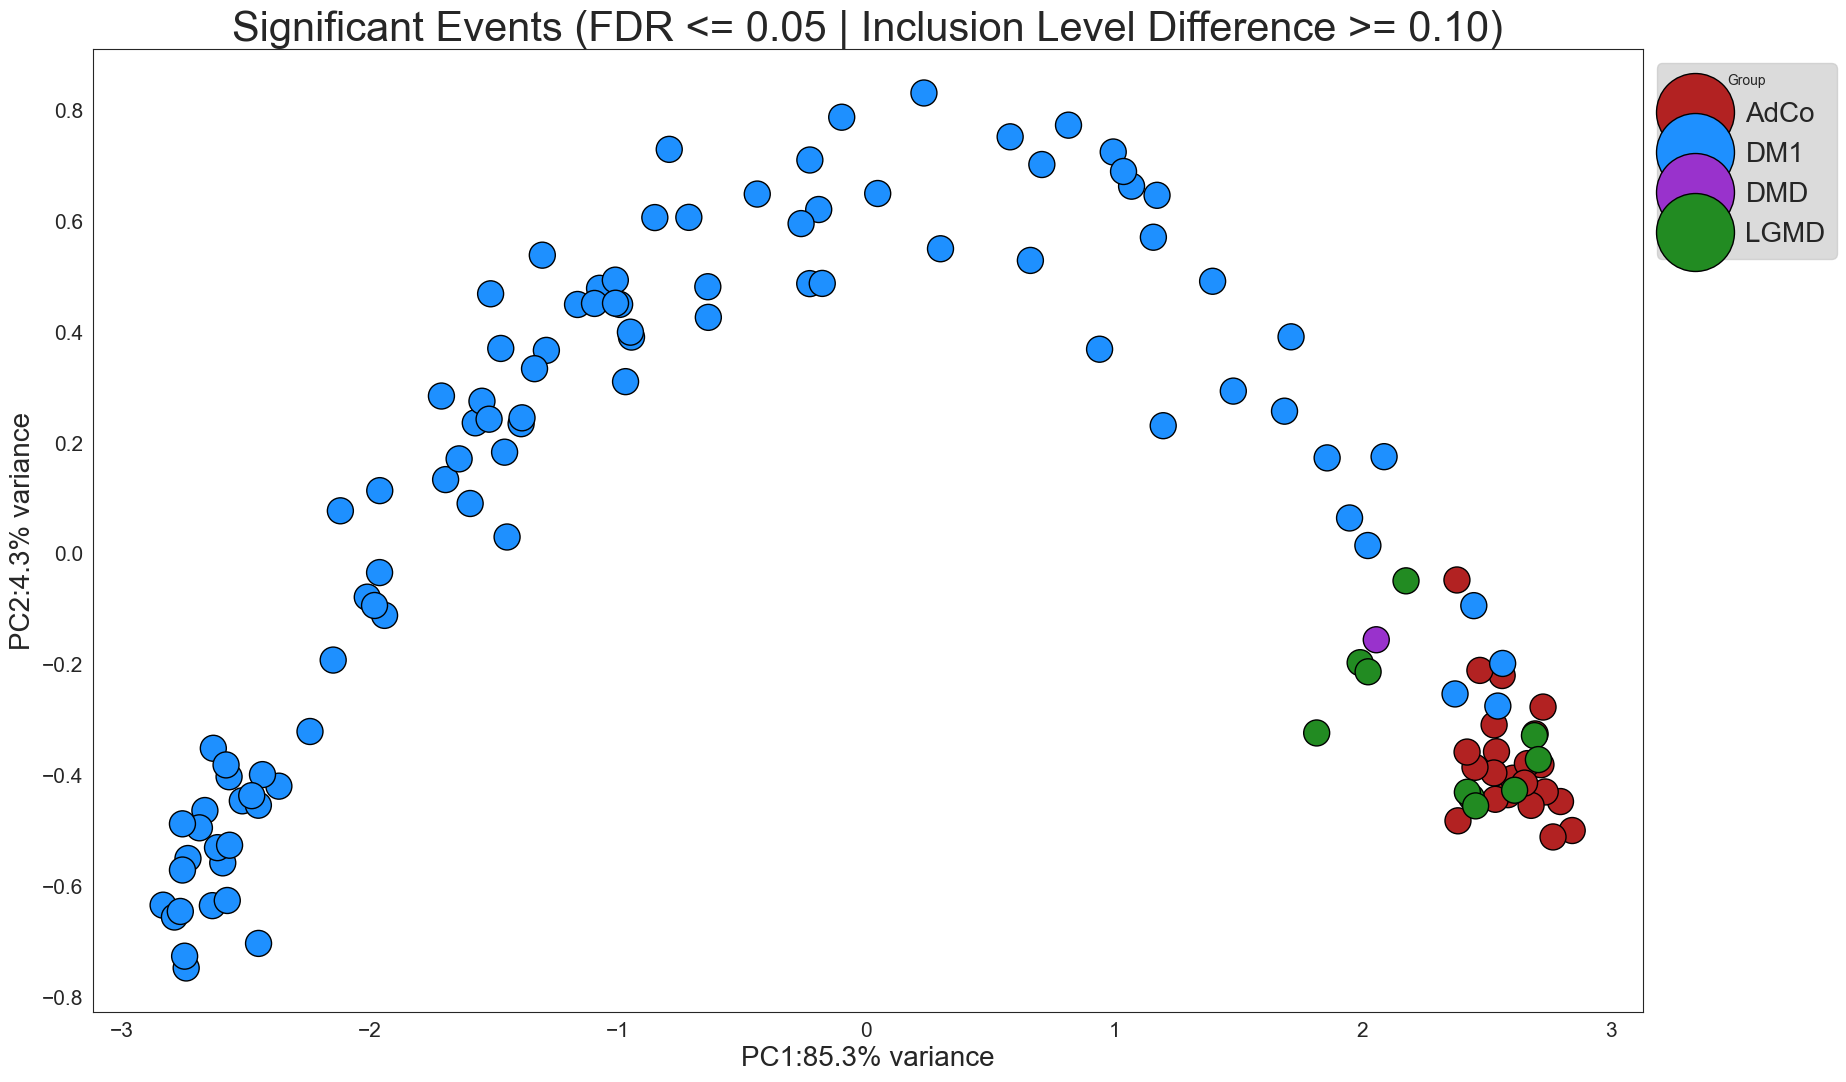

In [23]:
#PCA plot
plt.figure(figsize=(20,12.5))
plt.rcParams['font.family'] = 'arial'
sns.set_style('white')
ax =sns.scatterplot(y = ttrans["PC2"],  x= ttrans["PC1"], hue = ttrans['Group'], palette = diag_pal, s = 350, linewidth=1, edgecolor ='black') 
# ax =sns.scatterplot(y = trans["PC2"],  x= trans["PC1"], hue = trans['Group'], palette = diag_pal, s = 350, linewidth=1, edgecolor ='black') 
plt.xticks( size = 15)
plt.yticks(size = 15)
plt.title("Significant Events (FDR <= 0.05 | Inclusion Level Difference >= 0.10)", size = 30)
plt.ylabel("PC2:" + str((round(tpca.explained_variance_ratio_[1],3)*100)) + "% variance", size = 20)
plt.xlabel('PC1:' + str((round(tpca.explained_variance_ratio_[0],3)*100)) + "% variance", size = 20)
plt.legend(title='Group', bbox_to_anchor=(1.00, 1), loc=2, markerscale=3, fontsize=20, facecolor = 'lightgrey')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("black")

#to identify each point with sample name
# for i in range(ttrans.shape[0]):
#     ax.text(ttrans["PC1"][i], ttrans["PC2"][i], ttrans.index[i], horizontalalignment='right', size='small', color='black', weight='semibold')

# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/targeted_pca.svg", format = "svg", bbox_inches='tight', pad_inches = 0.5, dpi = 300)

In [24]:
#ranking of samples by mean delta psi to force rank subsequent heatmap
top50 = t50_full.transpose()
top50 =  top50.merge(t50_mean_delta_psi['mean_delta_psi'], left_index=True,right_index=True, how='left')
top50 =  top50.merge(meta['SI ID'], left_index=True,right_index=True, how='left')
top50.set_index('SI ID', inplace=True)
# Create a ranking based on the 'sis' column
top50['mdp_rank'] = top50['mean_delta_psi'].rank()

# Sort the DataFrame based on the 'sis_rank' column
top50 = top50.sort_values(by='mdp_rank')

# Drop the 'sis_rank' column if you don't need it for the heatmap
top50 = top50.drop(columns=['mdp_rank'])
top50 = top50.drop(columns=['mean_delta_psi'])
top50 = top50.transpose()
top50

SI ID      LGMD-003  AdCo-022  AdCo-015  AdCo-012  LGMD-014  AdCo-016  \
ABLIM1        0.635     0.716     0.665     0.653     0.631     0.437   
ALPK3         0.157     0.202     0.149     0.230     0.218     0.187   
ANK3          0.850     1.000     0.929     1.000     0.756     1.000   
ANK3.1        0.922     1.000     0.964     1.000     0.819     1.000   
ANK3.2        0.931     1.000     0.951     1.000     0.845     1.000   
ANK3.3        0.892     1.000     1.000     1.000     1.000     1.000   
ARFGAP2       0.660     0.672     0.751     0.699     0.745     0.777   
ARHGEF10L     0.982     1.000     0.957     0.994     0.968     0.949   
ATP2A1        0.996     1.000     1.000     0.998     0.999     0.999   
BEST3         0.833     1.000     0.806     0.853     0.902     0.882   
BIN1          0.250     0.315     0.259     0.206     0.311     0.208   
CACNA2D1      0.963     0.971     0.948     0.954     0.957     0.938   
CAMK2B        0.895     0.964     0.980     0.750     0.965     0.889   
CAMK2B.1      0.952     0.978     0.983     0.924     0.984     0.950   
CAMK2B.2      0.711     0.749     0.791     0.787     0.762     0.747   
CLASP1        0.908     0.948     0.886     0.871     0.956     0.923   
CLCN1         0.253     0.093     0.212     0.185     0.228     0.184   
CLCN1.1       0.106     0.063     0.040     0.080     0.171     0.194   
COPS5         0.796     0.944     0.934     0.927     0.815     0.957   
COPZ2         0.069     0.114     0.201     0.126     0.159     0.147   
FBXO31        0.845     0.917     0.895     0.930     0.844     0.967   
GRIP2         0.264     0.263     0.419     0.386     0.390     0.317   
INSR          0.702     0.756     0.749     0.835     0.740     0.733   
KIF13A        0.731     0.785     0.783     0.766     0.612     0.760   
LDB3          0.036     0.049     0.065     0.036     0.041     0.036   
LDB3.1        0.842     0.604     0.534     0.753     0.364     0.257   
LDB3.2        1.000     0.998     0.999     0.999     0.997     0.995   
LIMCH1        0.614     0.712     0.689     0.580     0.577     0.549   
MAP4K4        0.375     0.371     0.312     0.647     0.318     0.591   
MAPT          0.772     0.911     0.861     0.842     0.859     0.877   
MAPT.1        0.625     0.636     0.632     0.600     0.857     0.778   
MAPT.2        0.975     0.973     0.970     0.976     0.996     0.985   
MBNL1         0.137     0.140     0.101     0.115     0.204     0.178   
MYH10         0.110     0.045     0.151     0.045     0.115     0.000   
MYH11         0.092     0.075     0.108     0.196     0.000     0.108   
NFIX          0.305     0.224     0.282     0.290     0.254     0.300   
OBSCN         0.989     0.993     0.968     0.983     1.000     1.000   
PDLIM3        0.429     0.429     0.875     0.636     0.610     0.241   
PDLIM7        0.142     0.111     0.095     0.151     0.161     0.111   
PDP1          0.207     0.000     0.131     0.289     0.102     0.280   
SEMA6C        0.703     0.783     0.748     0.736     0.751     0.710   
SLC2A8        0.315     0.481     0.349     0.412     0.429     0.235   
SOCS7         0.462     0.250     0.220     0.273     0.243     0.200   
SYNE1         0.315     0.178     0.203     0.153     0.235     0.322   
TJAP1         0.023     0.166     0.090     0.125     0.175     0.101   
TNNT3         0.350     0.310     0.350     0.331     0.198     0.459   
TNNT3.1       0.531     0.185     0.526     0.389     0.248     0.357   
TNNT3.2       0.430     0.442     0.486     0.456     0.269     0.621   
TTN           0.061     0.278     0.130     0.037     0.231     0.182   
TTN.1         0.333     0.263     0.130     0.143     0.300     0.500   

SI ID      AdCo-017  AdCo-007  DM1-103  AdCo-002  ...  DM1-017  DM1-032  \
ABLIM1        0.763     0.495    0.547     0.458  ...    0.003    0.002   
ALPK3         0.138     0.170    0.194     0.209  ...    0.903    0.943   
ANK3          0.907     1.000    0.917     1.000  .

In [25]:
# Setting group colors and combinations, sub meta for meta all depending on the group you want to use
#Uncomment when working with fig_1 cohort
dm1 = ['dodgerblue'] * sum(meta['Group'] == "DM1")
adco = ['firebrick'] * sum(meta['Group'] == "AdCo")
dmd = ['darkorchid'] * sum(meta['Group'] == "DMD")
lgmd = ['forestgreen'] * sum(meta['Group'] == "LGMD")

groups = dm1 + adco + dmd + lgmd


# #Uncomment code block if working with all samples ***
# dm1 = ['dodgerblue'] * sum(meta['Group'] == "DM1")
# adco = ['firebrick'] * sum(meta['Group'] == "AdCo")
# dmd = ['darkorchid'] * sum(meta['Group'] == "DMD")
# lgmd = ['forestgreen'] * sum(meta['Group'] == "LGMD")
# cdm = ['gold'] * sum(meta['Group'] == "CDM")
# dm2 = ['darkorange'] * sum(meta['Group'] == "DM2")
# groups = dm1 + adco + dmd + lgmd + cdm + dm2

df3 = pd.DataFrame()
df3['group'] = meta['Group']

df3['color'] = groups


In [26]:
#For fig 1 dataset
# Create a dictionary to map the group names to the colors and sex
male = ['gold'] * sum(meta['Sex'] =="M")
female = ['lightslategrey'] * sum(meta['Sex'] == "F")

sex = pd.Series(male + female)

df4 = pd.DataFrame()
df4['sex'] = meta['Sex']
df4.loc[meta['Sex']=='M', 'color'] = 'gold'
df4.loc[meta['Sex']=='F', 'color'] = 'slategrey'
df4.loc[meta['Sex'].isnull(), 'color'] = 'white'
group = pd.Series(groups)

meta.loc[meta['Sex'].isnull(), 'Sex'] = "NA" 
 
sex_label = meta["Sex"]
sex_pal = ['dimgrey', 'silver', 'black']
sex_lut = dict(zip(map(str, sex_label.unique()), sex_pal))
sex_col = pd.Series(sex_label).map(sex_lut)
# sex_col

diag_label = meta["Group"]
diag_pal = ["firebrick",'dodgerblue','darkorchid','forestgreen']
diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
diag_col = pd.Series(diag_label).map(diag_lut)
# diag_col

comb_col = pd.DataFrame(sex_col).join(pd.DataFrame(diag_col))
comb_col.columns = ("Sex", "Group")
comb_col

Sex        Group
Subject ID                      
AdCo-001    dimgrey    firebrick
AdCo-002     silver    firebrick
AdCo-004     silver    firebrick
AdCo-005     silver    firebrick
AdCo-006     silver    firebrick
...             ...          ...
LGMD-010    dimgrey  forestgreen
LGMD-012    dimgrey  forestgreen
LGMD-013    dimgrey  forestgreen
LGMD-014    dimgrey  forestgreen
LGMD-015     silver  forestgreen

[128 rows x 2 columns]

In [260]:
# # for entire total rnaseq dataset ALL ***
# # Create a dictionary to map the group names to the colors and sex
# male = ['gold'] * sum(meta['Sex'] =="M")
# female = ['lightslategrey'] * sum(meta['Sex'] == "F")

# sex = pd.Series(male + female)

# df4 = pd.DataFrame()
# df4['sex'] = meta['Sex']
# df4.loc[meta['Sex']=='M', 'color'] = 'gold'
# df4.loc[meta['Sex']=='F', 'color'] = 'slategrey'
# df4.loc[meta['Sex'].isnull(), 'color'] = 'white'
# group = pd.Series(groups)

# meta.loc[meta['Sex'].isnull(), 'Sex'] = "NA" 
 
# sex_label = meta["Sex"]
# sex_pal = ['dimgrey', 'silver', 'black']
# sex_lut = dict(zip(map(str, sex_label.unique()), sex_pal))
# sex_col = pd.Series(sex_label).map(sex_lut)
# # sex_col

# diag_label = meta["Group"]
# diag_pal = ["firebrick",'gold','dodgerblue','darkorange','darkorchid','forestgreen']
# diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
# diag_col = pd.Series(diag_label).map(diag_lut)
# # diag_col

# comb_col = pd.DataFrame(sex_col).join(pd.DataFrame(diag_col))
# comb_col.columns = ("Sex", "Group")
# comb_col

Sex        Group
Subject ID                      
AdCo-001    dimgrey    firebrick
AdCo-002     silver    firebrick
AdCo-004     silver    firebrick
AdCo-005     silver    firebrick
AdCo-006     silver    firebrick
...             ...          ...
LGMD-010    dimgrey  forestgreen
LGMD-012    dimgrey  forestgreen
LGMD-013    dimgrey  forestgreen
LGMD-014    dimgrey  forestgreen
LGMD-015     silver  forestgreen

[140 rows x 2 columns]

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/3374058637.py:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cg.ax_row_dendrogram.set_ylim([0,0])
/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/3374058637.py:17: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cg.ax_col_dendrogram.set_xlim([0,0])


[Text(0.5, 0, 'LGMD-003'), Text(1.5, 0, 'AdCo-022'), Text(2.5, 0, 'AdCo-015'), Text(3.5, 0, 'AdCo-012'), Text(4.5, 0, 'LGMD-014'), Text(5.5, 0, 'AdCo-016'), Text(6.5, 0, 'AdCo-017'), Text(7.5, 0, 'AdCo-007'), Text(8.5, 0, 'DM1-103'), Text(9.5, 0, 'AdCo-002'), Text(10.5, 0, 'LGMD-013'), Text(11.5, 0, 'AdCo-021'), Text(12.5, 0, 'AdCo-010'), Text(13.5, 0, 'DM1-080'), Text(14.5, 0, 'AdCo-004'), Text(15.5, 0, 'AdCo-008'), Text(16.5, 0, 'AdCo-023'), Text(17.5, 0, 'AdCo-011'), Text(18.5, 0, 'LGMD-015'), Text(19.5, 0, 'AdCo-006'), Text(20.5, 0, 'AdCo-024'), Text(21.5, 0, 'AdCo-019'), Text(22.5, 0, 'LGMD-001'), Text(23.5, 0, 'AdCo-020'), Text(24.5, 0, 'LGMD-012'), Text(25.5, 0, 'DM1-056'), Text(26.5, 0, 'DM1-108'), Text(27.5, 0, 'AdCo-025'), Text(28.5, 0, 'AdCo-001'), Text(29.5, 0, 'AdCo-009'), Text(30.5, 0, 'AdCo-018'), Text(31.5, 0, 'DM1-081'), Text(32.5, 0, 'LGMD-007'), Text(33.5, 0, 'AdCo-005'), Text(34.5, 0, 'DM1-050'), Text(35.5, 0, 'DM1-072'), Text(36.5, 0, 'DM1-109'), Text(37.5, 0, 'DMD

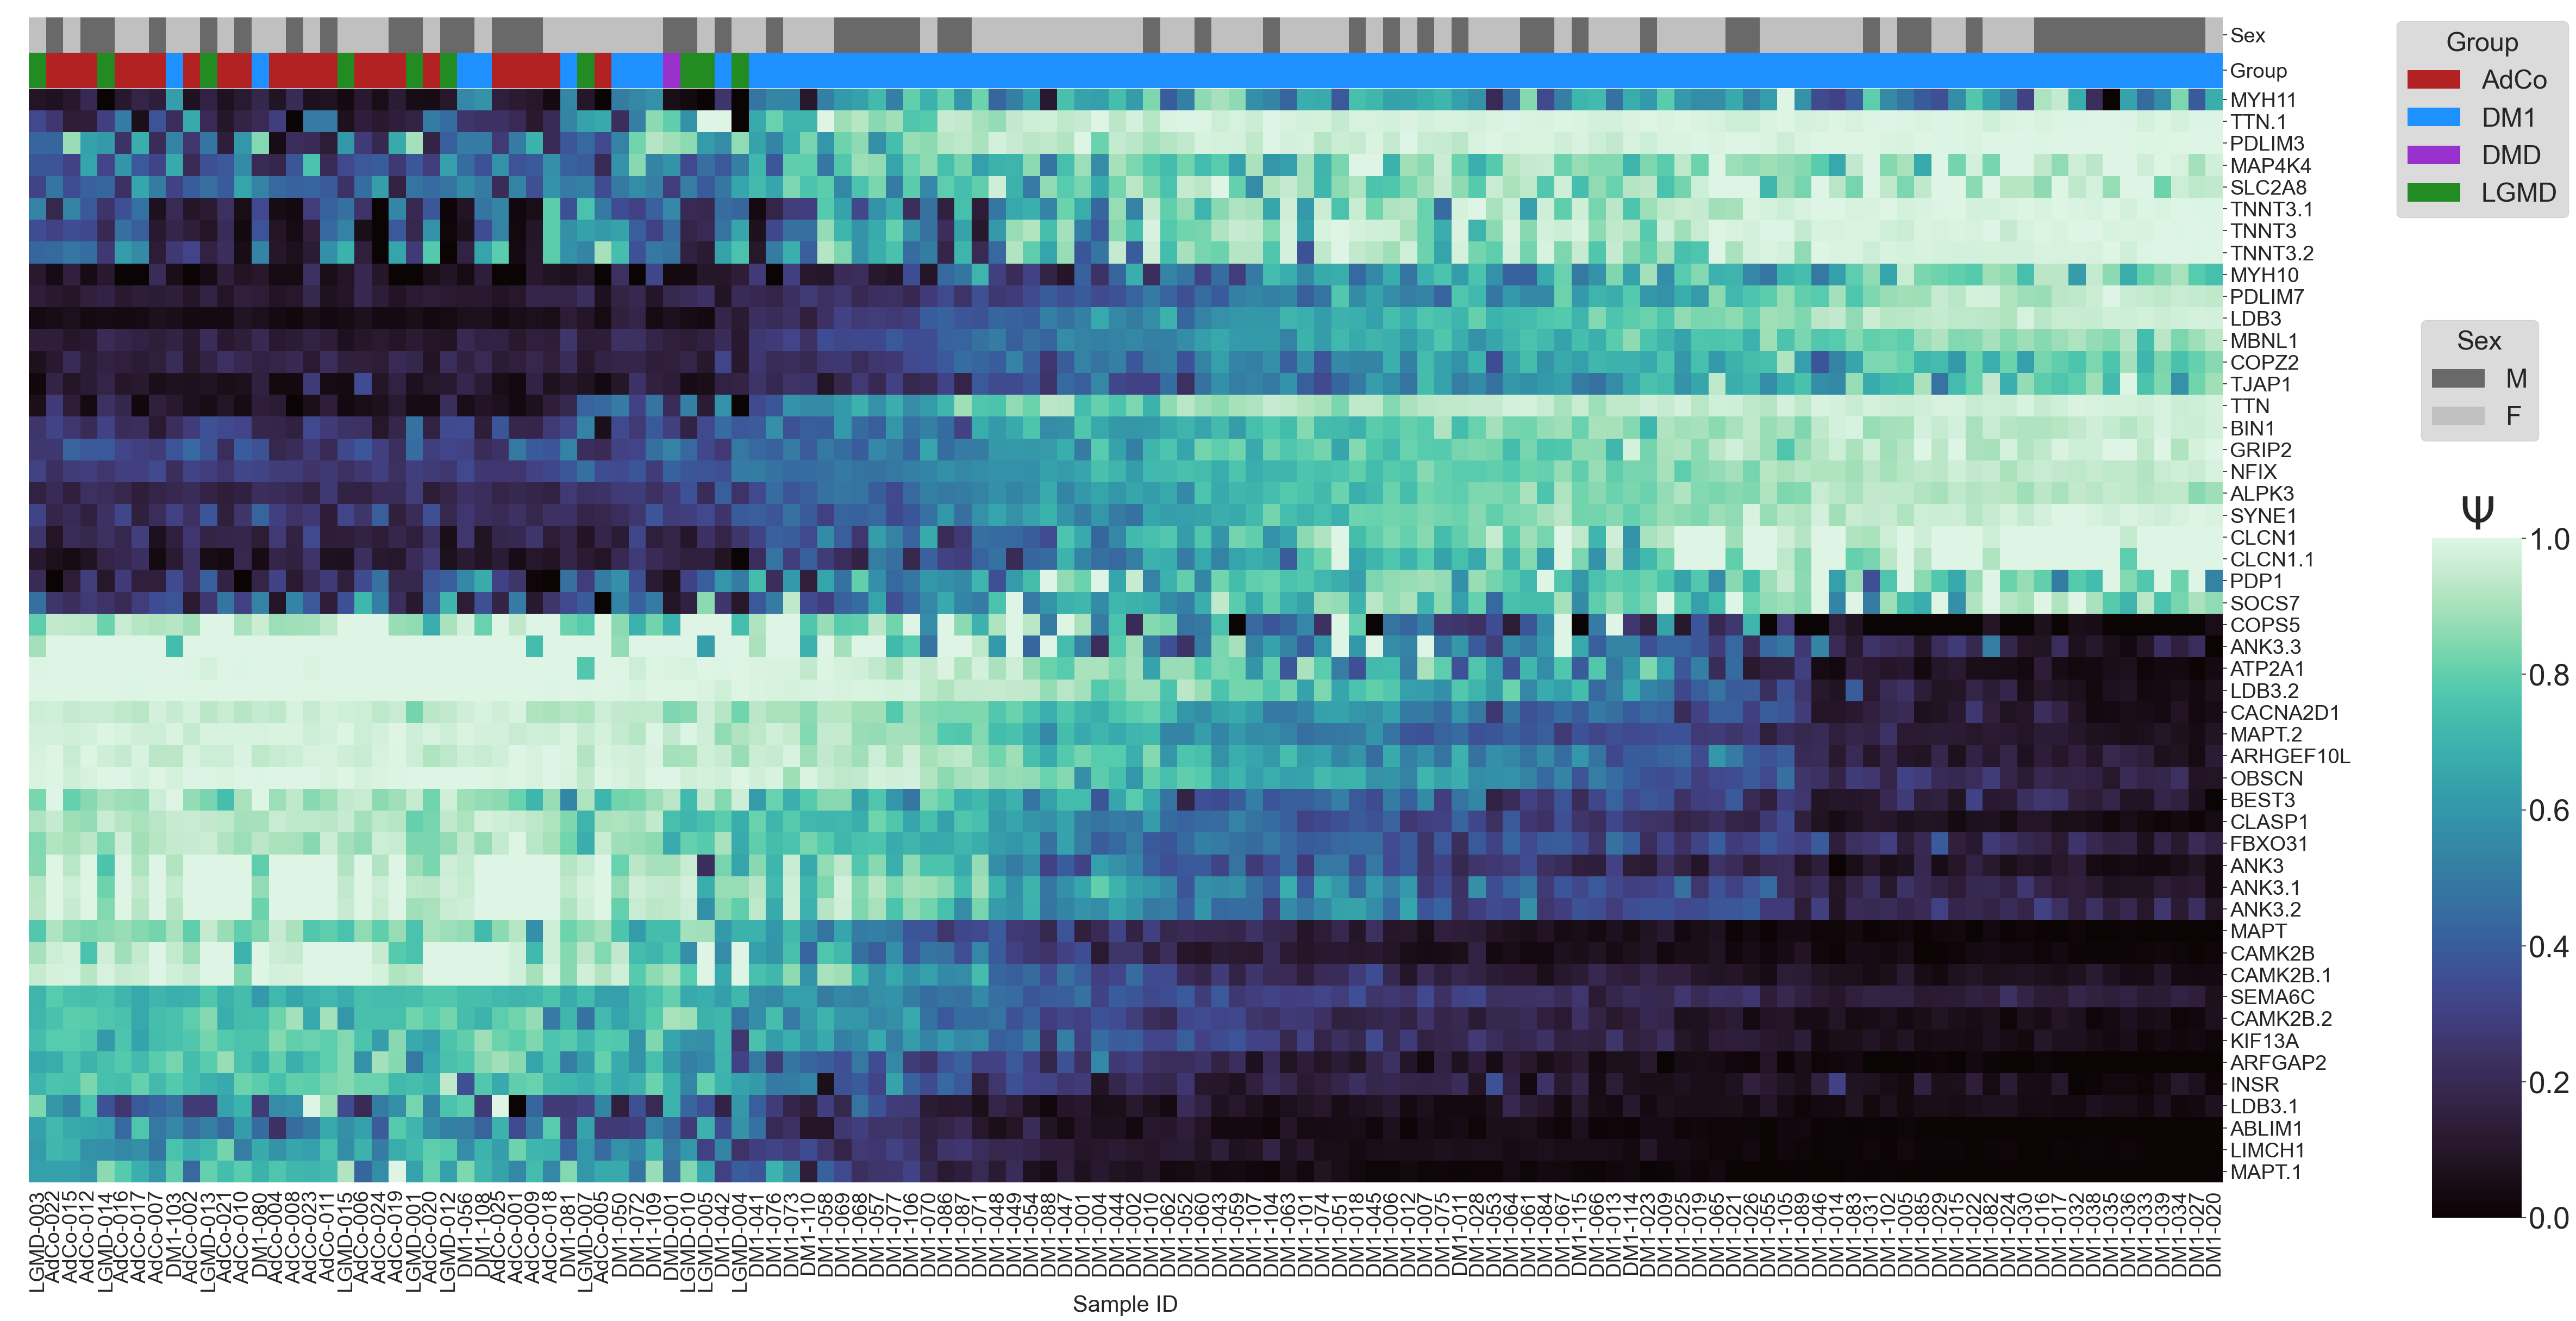

In [27]:
#Heatmap of top 50 events
cmap = sns.cubehelix_palette(as_cmap=True)
sns.set(font_scale=2.5)
cg = sns.clustermap(top50, figsize=(55,25), col_cluster = False, row_cluster=True, cmap = 'mako',
                    col_colors= comb_col, dendrogram_ratio=(0.01, 0.01),xticklabels=True, yticklabels=True)
# Label colorbar for sample-group identity
for label in diag_label.unique():
    cg.ax_row_dendrogram.bar(0, 0, color=diag_lut[label], label=label, linewidth=0);
l1 = cg.ax_row_dendrogram.legend(title='Group', bbox_to_anchor=(.87, 0.98), fontsize = 35, title_fontsize=35,  bbox_transform=plt.gcf().transFigure, facecolor = 'lightgrey')
#label color bar for sample-sex identity
for labels in sex_label.unique():
    cg.ax_col_dendrogram.bar(0, 0, color=sex_lut[labels], label=labels, linewidth=0);
l2 = cg.ax_col_dendrogram.legend(title='Sex', bbox_to_anchor=(.86, 0.76), fontsize = 35, title_fontsize=35, bbox_transform=plt.gcf().transFigure, facecolor = 'lightgrey')

#cg.ax_row_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_ylim([0,0])
cg.ax_col_dendrogram.set_xlim([0,0])


cg.fig.set_facecolor('white')
cg.cax.set_title(r"$\Psi$", size = 60)
cg.ax_heatmap.set_xlabel('Sample ID', size = 30)
new_label = []
#X-axis labels
print(cg.ax_heatmap.get_xticklabels())
for f in cg.ax_heatmap.get_xticklabels():
    b = f.get_text()
    a = meta.loc[meta.index == b, 'SI ID'].values
    f.set_text(a[0])
    new_label.append(f)

cg.ax_heatmap.axes.set_xticklabels(new_label)
cg.fig.subplots_adjust(right=.75)
cg.ax_cbar.set_position((0.82, .09, .03, .5))
cg.ax_cbar.tick_params(labelsize=40)
bottom, top = cg.ax_heatmap.get_ylim()
# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/all_dis_t50_mdp-fr_heatmap.svg", format = "svg", bbox_inches='tight', pad_inches = 0.5, dpi = 300)

The Use of the alternative rmats files stops here. No code below is designed to work with those files/dataset.

In [28]:
#strip plots
top50_strip = top50.loc[top50.index.str.contains('CLCN1|INSR|MBNL1'),]
top50_strip = top50_strip.T
top50_strip = top50_strip.sort_index()
top50_strip['Group'] = meta['Group'].values
top50_strip = top50_strip.drop(columns=['CLCN1.1'])
#custom order of groups for figure aesthetics
group_order = ['DM1', 'AdCo', 'LGMD', 'DMD']
top50_strip['Group'] = pd.Categorical(top50_strip['Group'], categories=group_order, ordered=True)
top50_strip

CLCN1   INSR  MBNL1 Group
SI ID                              
AdCo-001  0.195  0.798  0.112  AdCo
AdCo-002  0.260  0.736  0.116  AdCo
AdCo-004  0.273  0.740  0.117  AdCo
AdCo-005  0.176  0.735  0.134  AdCo
AdCo-006  0.163  0.813  0.101  AdCo
...         ...    ...    ...   ...
LGMD-010  0.100  0.541  0.132  LGMD
LGMD-012  0.058  0.941  0.088  LGMD
LGMD-013  0.165  0.689  0.213  LGMD
LGMD-014  0.228  0.740  0.204  LGMD
LGMD-015  0.137  0.851  0.073  LGMD

[128 rows x 4 columns]

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/1722431092.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.00, 1), loc=2, markerscale=1.5, fontsize=17.5)
/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/1722431092.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.00, 1), loc=2, markerscale=1.5, fontsize=17.5)
/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/1722431092.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.00, 1), loc=2, markerscale=1.5, fontsize=17.5)


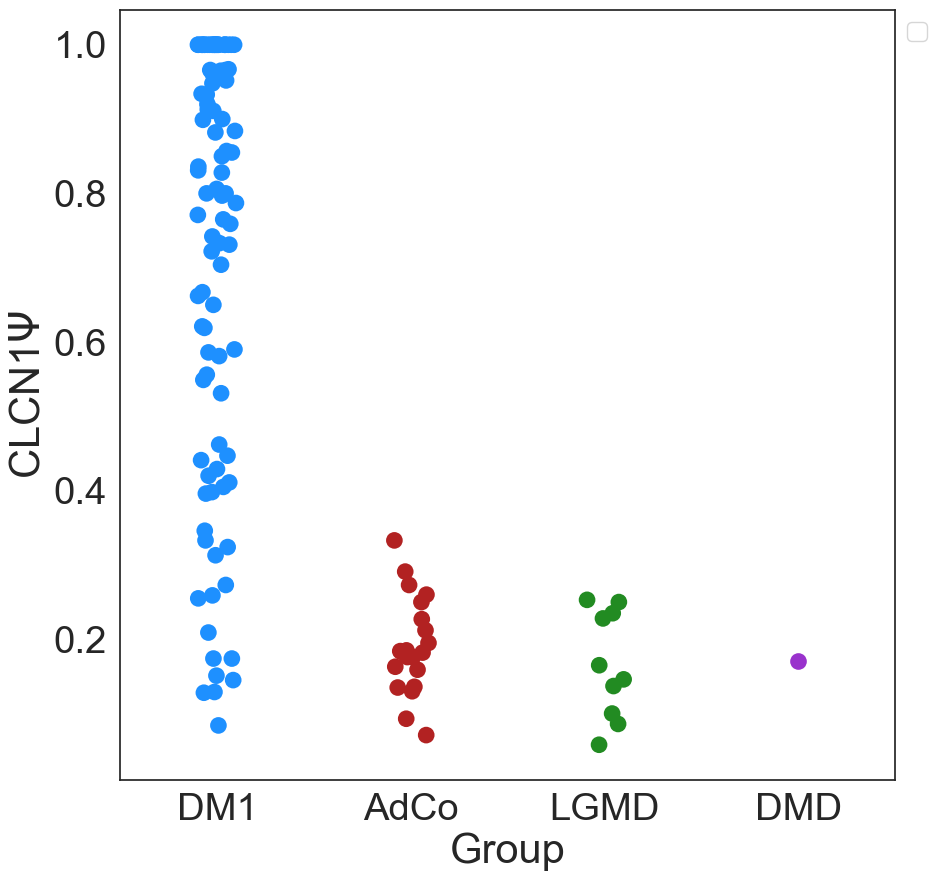

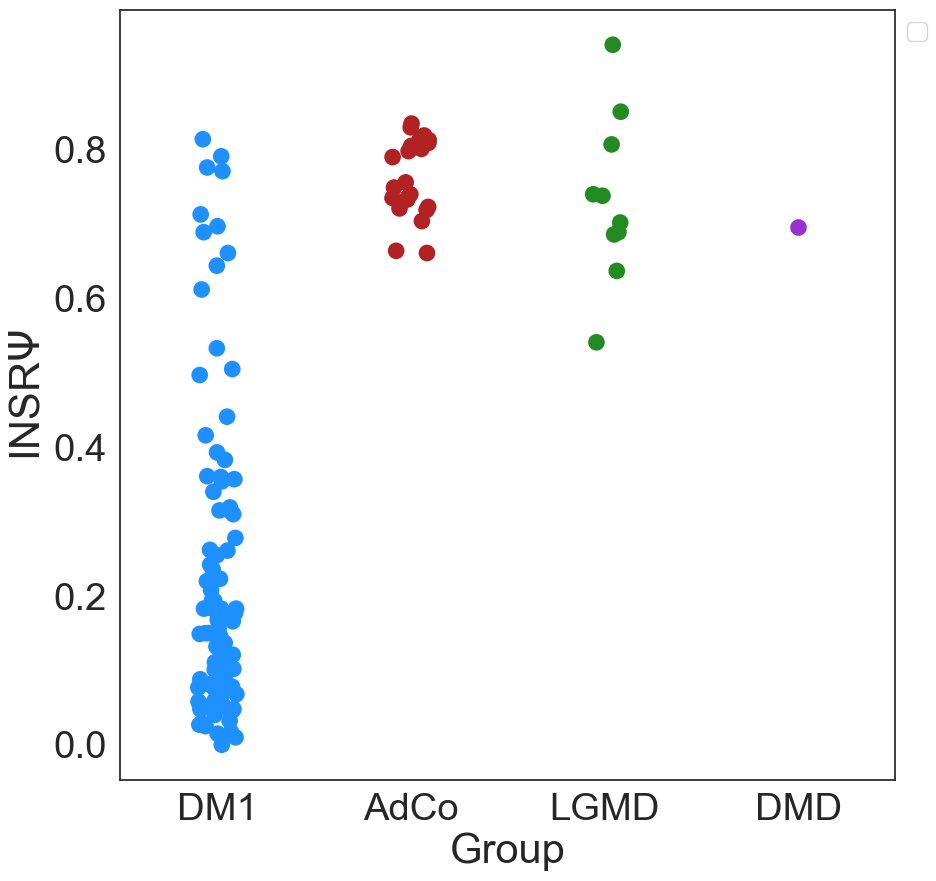

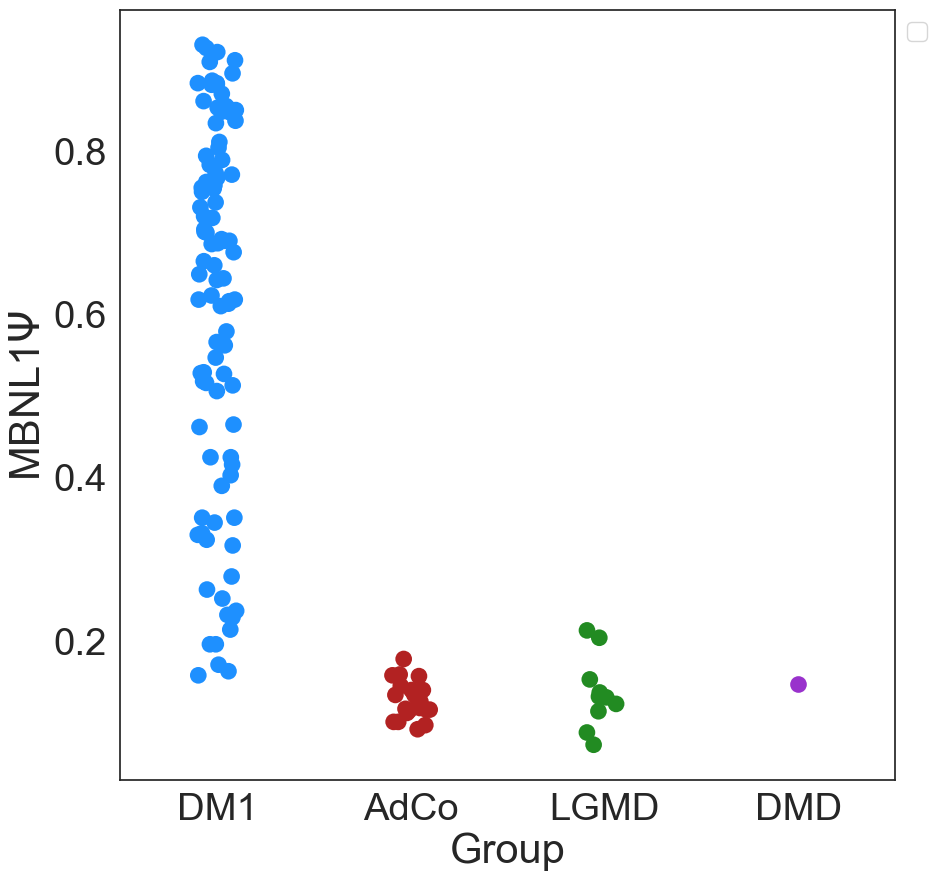

In [29]:
#plotting strip plots for chosen events
for column in top50_strip.columns.drop('Group'):
    diag_label = top50_strip['Group']
    diag_pal = {
        'DM1':'dodgerblue',
        'AdCo':"firebrick",
        'LGMD':"forestgreen",
        'DMD': 'darkorchid'
        
        
    }
    diag_col = pd.Series(diag_label).map(diag_pal)
    plt.figure(figsize=(10, 10))
    sns.set_style('white')
    sns.stripplot(x='Group', y=column, data=top50_strip, hue=diag_label, palette=diag_pal, s=12)
    plt.ylabel(column + r"$\Psi$")
    plt.legend(bbox_to_anchor=(1.00, 1), loc=2, markerscale=1.5, fontsize=17.5)
    # plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig1/{column}_stripplot.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)

In [30]:
#Selecting for panels events with the chosen exonic coordinates
filtered_se_sig = se_all[(se_all['geneSymbol'] != 'CAMK2B') | (se_all['exonStart_0base'] == 44239588)&(se_all['upstreamEE']==44234676)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'ANK2') | (filtered_se_sig['exonStart_0base'] == 113372532)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'ATP2A1') | (filtered_se_sig['exonStart_0base'] == 28903699)&(filtered_se_sig['upstreamES']==28903322)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'BEST3') | (filtered_se_sig['exonStart_0base'] == 69694369)&(filtered_se_sig['upstreamEE']==69693907)& (filtered_se_sig['downstreamES']==69699204)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'BIN1') | (filtered_se_sig['exonStart_0base'] == 127060595)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'CACNA1S') | (filtered_se_sig['exonStart_0base'] == 201054504)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'CAPZB') | (filtered_se_sig['exonStart_0base'] == 19342751)&(filtered_se_sig['downstreamES']==19344357)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'CCPG1') | (filtered_se_sig['exonStart_0base'] == 55374154)&(filtered_se_sig['upstreamEE']==55372044)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'CLASP1') | (filtered_se_sig['exonStart_0base'] == 121445448)&(filtered_se_sig['upstreamES']==121430072)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'DMD') | (filtered_se_sig['exonStart_0base'] == 31126641)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'GOLGA4') | (filtered_se_sig['exonStart_0base'] == 37361242)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'INSR') | (filtered_se_sig['exonStart_0base'] == 7150496)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'MBNL1') | (filtered_se_sig['exonStart_0base'] == 152446703)&(filtered_se_sig['downstreamES']==152447619)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'MBNL2') | (filtered_se_sig['exonStart_0base'] == 97366458)&(filtered_se_sig['upstreamES']==97357481)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'NFIX') | (filtered_se_sig['exonStart_0base'] == 13078612)&(filtered_se_sig['downstreamES'] == 13081679)&(filtered_se_sig['upstreamES'] == 13075534)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'CLCN1') | (filtered_se_sig['exonStart_0base'] == 143323818)&(filtered_se_sig['upstreamES']==143323308)&(filtered_se_sig['downstreamES']==143324413)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'GFPT1') | (filtered_se_sig['exonStart_0base'] == 69354258)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'OPA1') | (filtered_se_sig['exonStart_0base'] == 193617783)&(filtered_se_sig['upstreamES']==193617177)&(filtered_se_sig['downstreamES']==193618868)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'RYR1') | (filtered_se_sig['exonStart_0base'] == 38523914)&(filtered_se_sig['downstreamES']==38525331)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'SOS1') | (filtered_se_sig['exonStart_0base'] == 38989269)&(filtered_se_sig['downstreamES']==38995122)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'VPS39') | (filtered_se_sig['exonStart_0base'] == 42192065)&(filtered_se_sig['downstreamES']==42199895)]
filtered_se_sig = filtered_se_sig[(filtered_se_sig['geneSymbol'] != 'KIF13A') | (filtered_se_sig['exonStart_0base'] == 17821785)&(filtered_se_sig['upstreamES']==17817019)]


In [31]:
#List of panel genes to use to search out put and find their ranking in temrs of how differentially splcied they are between case and control
search_terms = ["ANK2", "ATP2A1", "BEST3", "BIN1", "CACNA1S", "CAMK2B", "CAPZB", "CCPG1", "CLASP1", "CLCN1", "DMD", "GFPT1", "GOLGA4", "INSR", "KIF13A", "MBNL1", "MBNL2", "NFIX", "OPA1", "RYR1", "SOS1", "VPS39"]

#Find panel events in ranked list
match_ranked = filtered_se_sig.sort_values(by = "IncLevelDifference", key = abs, ascending = False)
matches = match_ranked[match_ranked['geneSymbol'].isin(search_terms)]

matches = matches.sort_values(by='geneSymbol')
match_tab = matches.iloc[:, [2,3,4,5,6,7,8,9,10,11]]
# match_tab.to_csv('/Users/ikegamik/Documents/kikegami/splice_index/match_tab.csv', index=False)

matches

ID           GeneID geneSymbol    chr strand  exonStart_0base  \
86347    94200  ENSG00000145362       ANK2   chr4      +        113372532   
35309    38847  ENSG00000196296     ATP2A1  chr16      +         28903699   
32584    35822  ENSG00000127325      BEST3  chr12      -         69694369   
96903   105698  ENSG00000136717       BIN1   chr2      -        127060595   
143513  156127  ENSG00000081248    CACNA1S   chr1      -        201054504   
178875  194777  ENSG00000058404     CAMK2B   chr7      -         44239588   
118443  128884  ENSG00000077549      CAPZB   chr1      -         19342751   
21264    23319  ENSG00000260916      CCPG1  chr15      -         55374154   
84567    92233  ENSG00000074054     CLASP1   chr2      -        121445448   
184760  201246  ENSG00000188037      CLCN1   chr7      +        143323818   
78152    85112  ENSG00000198947        DMD   chrX      -         31126641   
89538    97713  ENSG00000198380      GFPT1   chr2      -         69354258   
112668  122581  ENSG00000144674     GOLGA4   chr3      +         37361242   
96741   105531  ENSG00000171105       INSR  chr19      -          7150496   
165647  180335  ENSG00000137177     KIF13A   chr6      -         17821785   
63600    69288  ENSG00000152601      MBNL1   chr3      +        152446703   
79651    86891  ENSG00000139793      MBNL2  chr13      +         97366458   
4787      5360  ENSG00000008441       NFIX  chr19      +         13078612   
72143    78672  ENSG00000198836       OPA1   chr3      +        193617783   
124547  135447  ENSG00000196218       RYR1  chr19      +         38523914   
126898  137968  ENSG00000115904       SOS1   chr2      -         38989269   
21983    24077  ENSG00000166887      VPS39  chr15      -         42192065   

          exonEnd  upstreamES  upstreamEE  downstreamES  ...  \
86347   113372625   113369513   113369805     113373089  ...   
35309    28903741    28903322    28903440      28904179  ...   
32584    69694464    69693673    69693907      69699204  ...   
96903   127060640   127059010   127059155     127062114  ...   
143513  201054561   201053458   201053587     201058407  ...   
178875   44239663    44234638    44234676      44240706  ...   
118443   19342864    19338822    19339617      19344357  ...   
21264    55374250    55371872    55372044      55376948  ...   
84567   121445496   121430072   121430177     121447336  ...   
184760  143323897   143323308   143323386     143324413  ...   
78152    31126673    31119227    31121930      31134101  ...   
89538    69354312    69350077    69350183      69354488  ...   
112668   37361305    37355100    37355187      37366079  ...   
96741     7150532     7142815     7143090       7152725  ...   
165647   17821905    17817019    17817233      17825767  ...   
63600   152446757   152445281   152445539     152447619  ...   
79651    97366553    97357481    97357635      97391321  ...   
4787     13078735    13075534    13075671      13081679  ...   
72143   193617837   193617177   193617285     193618868  ...   
124547   38523929    38523216    38523309      38525331  ...   
126898   38989314    38987472    38987591      38995122  ...   
21983    42192098    42191495    42191560      42199895  ...   

                                             SJC_SAMPLE_1  \
86347   20,7,7,17,3,5,14,7,9,7,18,42,35,12,23,7,17,54,...   
35309   184,334,351,170,612,164,577,535,1690,162,479,4...   
32584   12,5,15,38,60,64,33,26,45,30,42,78,109,26,34,3...   
96903   95,105,27,211,84,97,133,81,220,80,220,373,438,...   
143513  83,96,77,121,140,155,138,94,194,97,213,182,183...   
178875  97,81,42,62,107,79,95,113,111,89,141,106,128,1...   
118443  88,81,48,133,142,116,115,102,95,148,127,283,19...   
21264   55,66,23,88,92,68,71,87,90,72,83,73,101,68,75,...   
84567   97,87,47,114,109,128,128,73,117,125,160,169,24...   
184760  13,5,10,0,6,4,2,8,5,3,1,0,0,0,0,8,0,0,4,0,2,0,...   
78152   20,29,4,39,25,20,27,3,16,39,54,69,64,53,58,22,...   
89538   6,11,9,17,9,14,27,21,16,24,

In [32]:
#Assign Case and Control samples their psi scores for each event, order among files and psi scores is conserved/the same 

# For matching 22 events
case_psi = matches.IncLevel1.str.split(",", expand = True)
case_psi =case_psi.rename(index =matches['geneSymbol'])
cntrl_psi = matches.IncLevel2.str.split(',', expand =True)
cntrl_psi =cntrl_psi.rename(index =matches['geneSymbol'])

case_psi.columns = case_frame.index
cntrl_psi.columns = cntrl_frame.index

#concatenate case and control psi scores for each event to create data frames of PSI

# 22 SI events
full_match = pd.concat([case_psi, cntrl_psi], axis=1)
full_match = full_match.apply(pd.to_numeric)
full_match = full_match.sort_index()
# full_match.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/rna_match_psi.csv")

#transposing full_match df
ep22 = pd.concat([full_match], axis = 0)
ep22 = ep22.transpose()
ep22 = ep22.sort_index()

In [33]:
#merge top50 with mean delta psi
t50_mdp = t50_all.merge(t50_mean_delta_psi, left_index=True, right_index=True, how='left')
#merge group from meta
t50_mdp = t50_mdp.merge(meta['Group'], left_index=True, right_index=True, how='left')
# t50_mdp

ep22_mdp = ep22.merge(t50_mean_delta_psi, left_index=True, right_index=True, how='left')
#merge group from meta
ep22_mdp = ep22_mdp.merge(meta['Group'], left_index=True, right_index=True, how='left')
#filter out rows containing LGMD or DMD in the index
ep22_mdp = ep22_mdp[~ep22_mdp.index.str.contains('LGMD|UDX|DMD')]
ep22_mdp

ANK2  ATP2A1  BEST3   BIN1  CACNA1S  CAMK2B  CAPZB  CCPG1  CLASP1  \
SI_ID                                                                          
AdCo-001  0.976   1.000  0.812  0.998    0.969   0.824  0.837  0.611   0.956   
AdCo-002  0.993   0.995  0.869  0.993    0.961   0.793  0.893  0.352   0.955   
AdCo-004  0.984   0.999  0.880  0.996    0.970   0.817  0.819  0.544   0.955   
AdCo-005  0.983   1.000  0.710  0.997    0.981   0.723  0.837  0.535   0.905   
AdCo-006  0.970   0.998  0.956  0.994    0.967   0.743  0.882  0.361   0.893   
...         ...     ...    ...    ...      ...     ...    ...    ...     ...   
DM1-108   0.985   0.999  0.871  0.996    0.985   0.697  0.911  0.453   0.977   
DM1-109   0.970   0.994  0.880  0.991    0.944   0.779  0.800  0.489   0.944   
DM1-110   0.821   0.945  0.780  0.976    0.929   0.617  0.591  0.207   0.715   
DM1-114   0.855   0.602  0.333  0.903    0.578   0.142  0.489  0.031   0.263   
DM1-115   0.677   0.392  0.211  0.908    0.598   0.234  0.306  0.063   0.253   

          CLCN1  ...  KIF13A  MBNL1  MBNL2   NFIX   OPA1   RYR1   SOS1  VPS39  \
SI_ID            ...                                                            
AdCo-001  0.195  ...   0.790  0.112  0.220  0.261  0.386  0.506  1.000  0.745   
AdCo-002  0.260  ...   0.766  0.116  0.110  0.316  0.450  0.285  1.000  0.833   
AdCo-004  0.273  ...   0.849  0.117  0.109  0.284  0.342  0.365  1.000  0.760   
AdCo-005  0.176  ...   0.774  0.134  0.036  0.349  0.447  0.441  1.000  0.797   
AdCo-006  0.163  ...   0.756  0.101  0.234  0.265  0.430  0.375  0.977  0.809   
...         ...  ...     ...    ...    ...    ...    ...    ...    ...    ...   
DM1-108   0.084  ...   0.879  0.158  0.136  0.265  0.434  0.395  1.000  0.244   
DM1-109   0.145  ...   0.843  0.171  0.208  0.285  0.467  0.472  1.000  0.860   
DM1-110   0.333  ...   0.590  0.232  0.183  0.454  0.287  0.258  0.922  0.467   
DM1-114   0.586  ...   0.151  0.861  0.550  0.831  0.155  0.105  0.496  0.223   
DM1-115   0.934  ...   0.162  0.737  0.484  0.797  0.119  0.243  0.693  0.279   

          mean_delta_psi  Group  
SI_ID                            
AdCo-001        0.084988   AdCo  
AdCo-002        0.066646   AdCo  
AdCo-004        0.072344   AdCo  
AdCo-005        0.100118   AdCo  
AdCo-006        0.076368   AdCo  
...                  ...    ...  
DM1-108         0.080487    DM1  
DM1-109         0.104760    DM1  
DM1-110         0.189096    DM1  
DM1-114         0.583815    DM1  
DM1-115         0.572255    DM1  

[117 rows x 24 columns]

In [48]:
#merge top50 with mbnl from meta
mbnl_v_mdp = t50_mean_delta_psi.merge(meta[['Group','mbnl']], left_index=True, right_index=True, how='left')

ep22_mbnl = ep22.merge(meta[['mbnl','Group']], left_index=True, right_index=True, how='left')

#filter out rows containing LGMD or DMD in the index
ep22_mbnl = ep22_mbnl[~ep22_mbnl.index.str.contains('LGMD|UDX|DMD')]
mbnl_v_mdp = mbnl_v_mdp[~mbnl_v_mdp.index.str.contains('LGMD|UDX|DMD')]

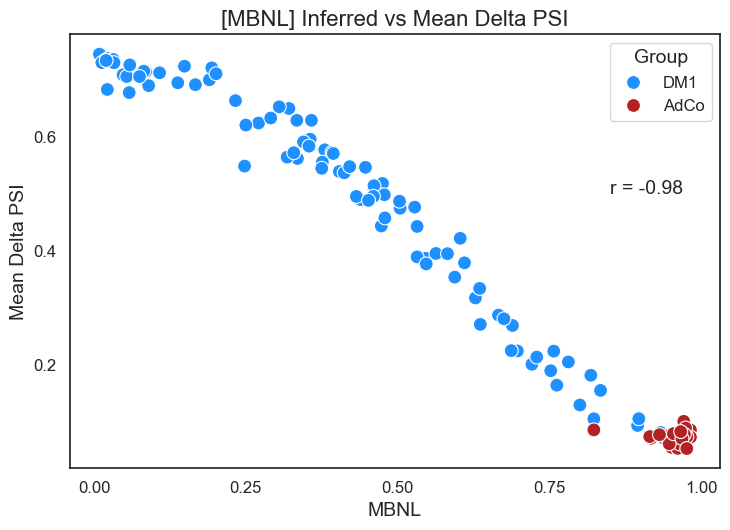

In [60]:
#make a scatterplot plot of MBNL vs mean delta psi
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mbnl_v_mdp, x='mbnl', y='mean_delta_psi', hue='Group', palette=diag_pal, s=100)

# Add plot title and labels
plt.title('[MBNL] Inferred vs Mean Delta PSI', fontsize=16)
plt.xlabel('MBNL', fontsize=14)
plt.ylabel('Mean Delta PSI', fontsize=14)
#make legend size smaller
plt.legend(title='Group', fontsize=12, title_fontsize=14)
#add pearson r
r = mbnl_v_mdp['mbnl'].corr(mbnl_v_mdp['mean_delta_psi'])
plt.text(0.85, 0.5, 'r = ' + str(round(r, 2)), fontsize=14)
#reduce tick font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Show plot
plt.tight_layout()
plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig2/mbnl_v_mdp.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_30454/1077566482.py:61: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)


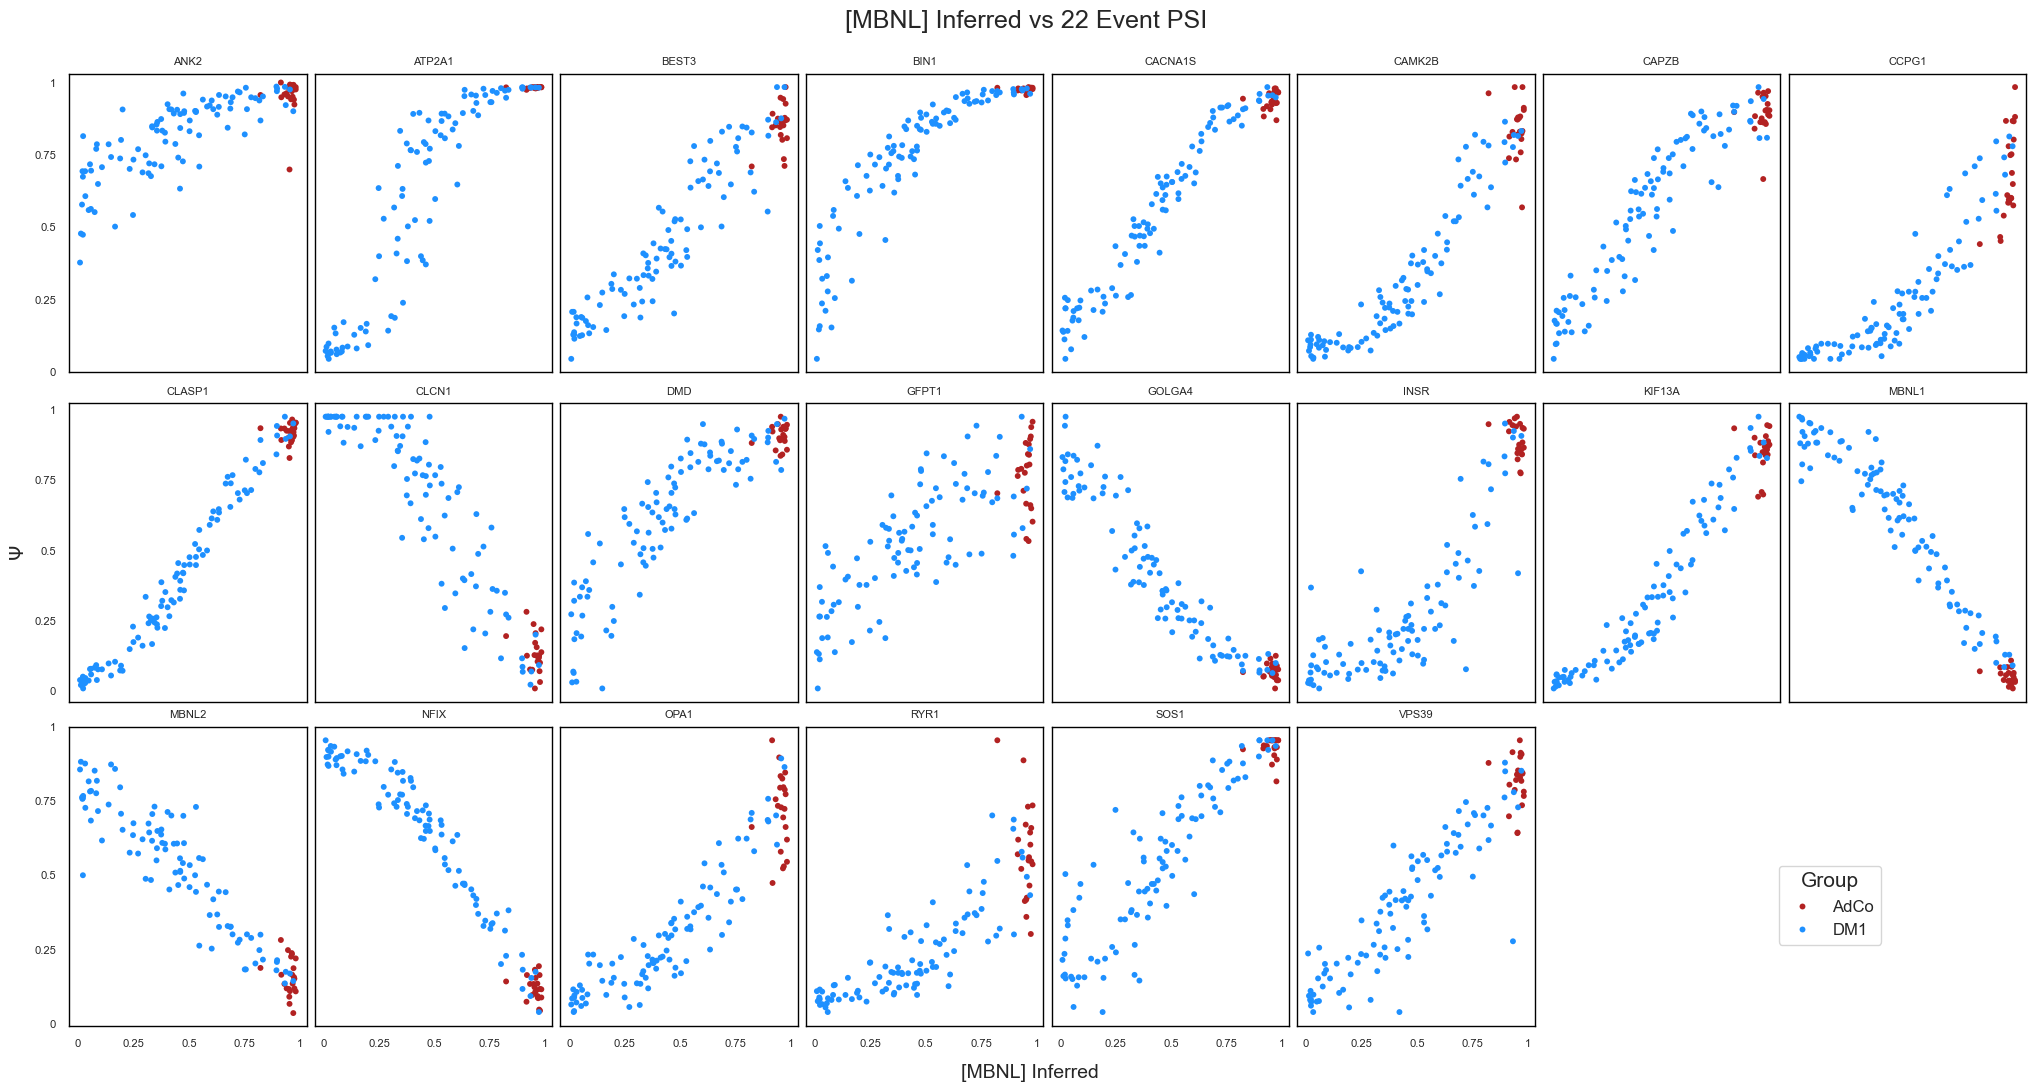

In [ ]:
#MBNL Inferred vs 22 event psi
fig, axes = plt.subplots(3, 8, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

# Set y-ticks values
y_ticks = [0, 0.25, 0.5, 0.75, 1]
# Set x-ticks values
x_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plot each scatter plot in the grid
for idx, col in enumerate(ep22_mbnl.columns[:22]):
    scatter_plot = sns.scatterplot(
        data=ep22_mbnl, 
        y=col, 
        x='mbnl', 
        hue='Group', 
        palette=diag_pal, 
        s=18, 
        linewidth=1, 
        edgecolor='none', 
        ax=axes[idx]
    )
    axes[idx].set_xticks([])  # Remove x ticks
    axes[idx].set_yticks([])  # Remove y ticks
    axes[idx].set_ylabel("")  # Remove y labels
    axes[idx].set_xlabel("")  # Remove x labels
    axes[idx].legend().set_visible(False)  # Remove legend
    axes[idx].set_title(col, fontsize=8)  # Set the title as the column name
    axes[idx].set_facecolor('white')  # Ensure consistent background color
    # sns.set_style('white')
    axes[idx].grid(False)  # Ensure grid lines
    axes[idx].set_axisbelow(False)  # Ensure grid lines are below the plots
    for spine in axes[idx].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
# Add y-ticks to the first plot in each row
for row in range(3):
    axes[row * 8].set_yticks(y_ticks)
    axes[row * 8].set_yticklabels(y_ticks, fontsize=8)

# Add x-ticks to the bottom plot in each column
for col in range(8):
    if 2 * 8 + col < len(ep22.columns):  # Check to avoid index error for columns less than 22
        axes[2 * 8 + col].set_xticks(x_ticks)
        axes[2 * 8 + col].set_xticklabels(x_ticks, fontsize=8)

# Hide extra axes
for idx in range(len(ep22.columns), len(axes)):
    axes[idx].set_visible(False)

# Add a common y-axis label, x-axis label, title
fig.text(-0.01, 0.5, r"$\Psi$", va='center', rotation='vertical', fontsize=14)
fig.text(0.5, -0.025, '[MBNL] Inferred', ha='center', fontsize=14)
fig.text(0.5, 1.025, '[MBNL] Inferred vs 22 Event PSI ', ha='center', fontsize=18)
# Add the legend to the bottom of the figure
handles, labels = scatter_plot.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', ncol=1, fontsize=10, frameon=False)
fig.legend(handles, labels, loc='lower center', ncol=1, fontsize=12, frameon=True, title='Group', title_fontsize='15', bbox_to_anchor=(0.9, 0.1))

# Adjust layout and reduce white space, increase space at the bottom
plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)

# Save the plot
plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig2/ep22_psi_v_mbnl_no-discntl.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_73610/2638464674.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)


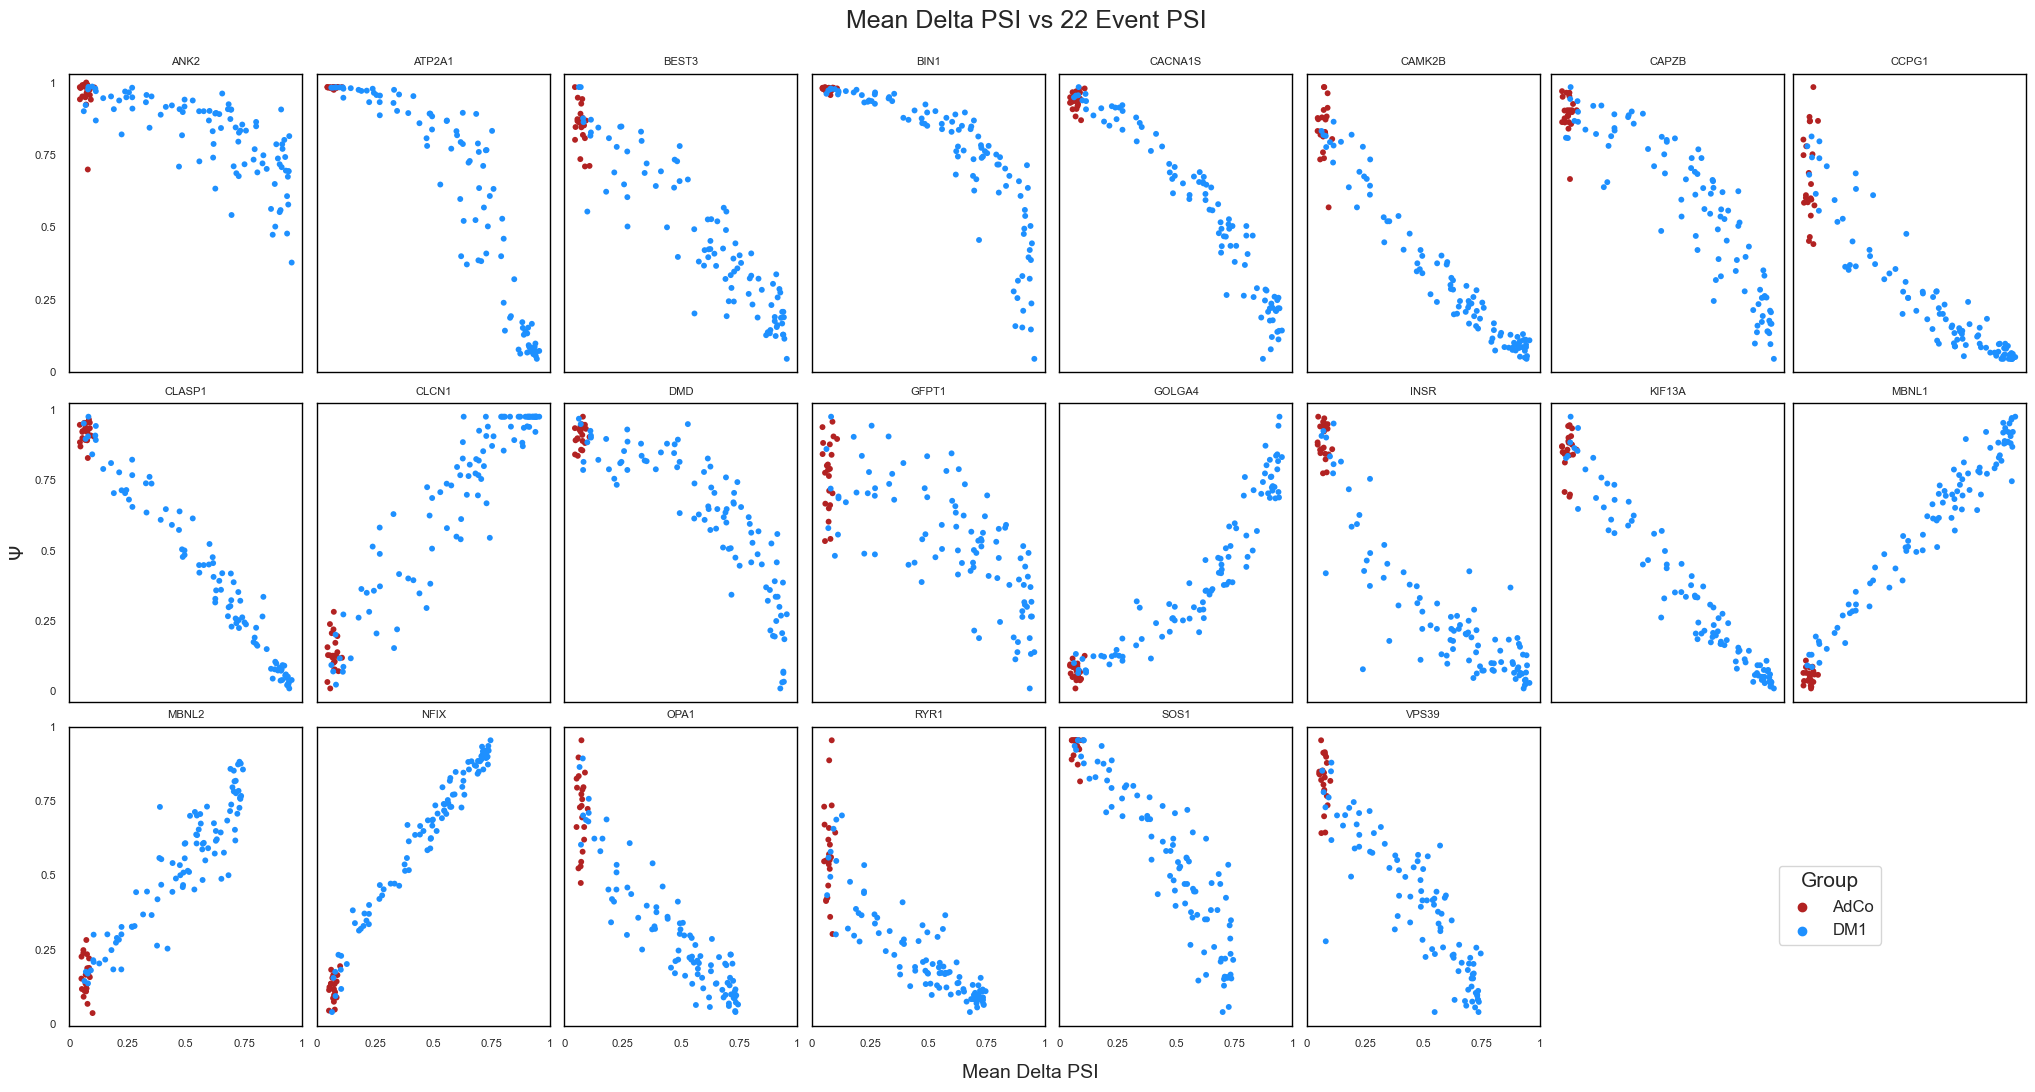

In [116]:
#Mean delta psi vs 22 event psi
fig, axes = plt.subplots(3, 8, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

# Set y-ticks values
y_ticks = [0, 0.25, 0.5, 0.75, 1]
# Set x-ticks values
x_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plot each scatter plot in the grid
for idx, col in enumerate(ep22_mdp.columns[:22]):
    scatter_plot = sns.scatterplot(
        data=ep22_mdp, 
        y=col, 
        x='mean_delta_psi', 
        hue='Group', 
        palette=diag_pal, 
        s=18, 
        linewidth=1, 
        edgecolor='none', 
        ax=axes[idx]
    )
    axes[idx].set_xticks([])  # Remove x ticks
    axes[idx].set_yticks([])  # Remove y ticks
    axes[idx].set_ylabel("")  # Remove y labels
    axes[idx].set_xlabel("")  # Remove x labels
    axes[idx].legend().set_visible(False)  # Remove legend
    axes[idx].set_title(col, fontsize=8)  # Set the title as the column name
    axes[idx].set_facecolor('white')  # Ensure consistent background color
    # sns.set_style('white')
    axes[idx].grid(False)  # Ensure grid lines
    axes[idx].set_axisbelow(False)  # Ensure grid lines are below the plots
    for spine in axes[idx].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
# Add y-ticks to the first plot in each row
for row in range(3):
    axes[row * 8].set_yticks(y_ticks)
    axes[row * 8].set_yticklabels(y_ticks, fontsize=8)

# Add x-ticks to the bottom plot in each column
for col in range(8):
    if 2 * 8 + col < len(ep22.columns):  # Check to avoid index error for columns less than 22
        axes[2 * 8 + col].set_xticks(x_ticks)
        axes[2 * 8 + col].set_xticklabels(x_ticks, fontsize=8)

# Hide extra axes
for idx in range(len(ep22.columns), len(axes)):
    axes[idx].set_visible(False)

# Add a common y-axis label, x-axis label, title
fig.text(-0.01, 0.5, r"$\Psi$", va='center', rotation='vertical', fontsize=14)
fig.text(0.5, -0.025, 'Mean Delta PSI', ha='center', fontsize=14)
fig.text(0.5, 1.025, 'Mean Delta PSI vs 22 Event PSI ', ha='center', fontsize=18)
# Add the legend to the bottom of the figure
handles, labels = scatter_plot.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', ncol=1, fontsize=10, frameon=False)
fig.legend(handles, labels, loc='lower center', ncol=1, fontsize=12, frameon=True, title='Group', title_fontsize='15', bbox_to_anchor=(0.9, 0.1))

# Adjust layout and reduce white space, increase space at the bottom
plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)

# Save the plot
# plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig2/ep22_psi_v_mdp_no-discntl.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/2915623378.py:43: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)


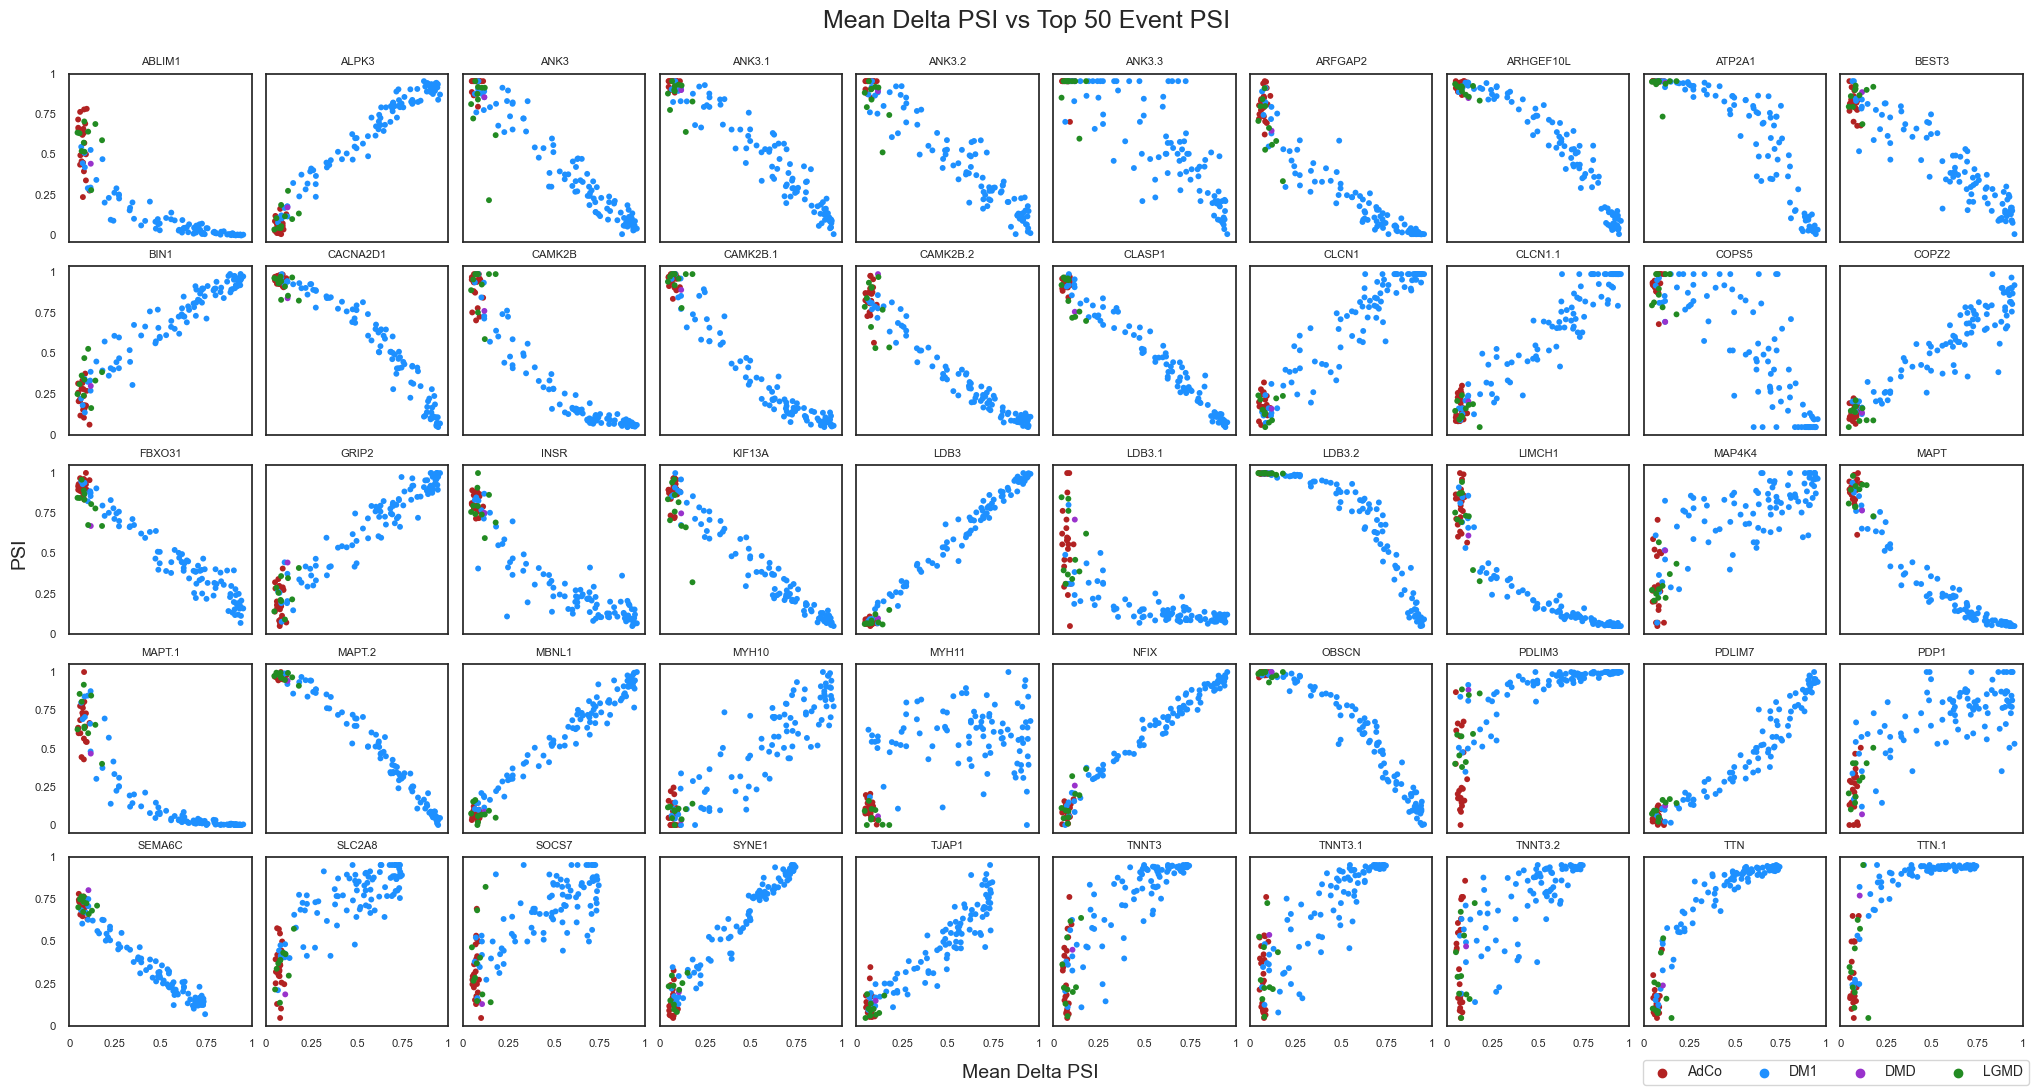

In [38]:
 #Mean delta psi vs top 50 event psi
# Create a grid of subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

# Set x and y-ticks values
y_ticks = [0, 0.25, 0.5, 0.75, 1]
x_ticks = [0, 0.25, 0.5, 0.75, 1]
# Plot each scatter plot in the grid
for idx, col in enumerate(t50_mdp.columns[:50]): 
    scatter_plot = sns.scatterplot(
        data=t50_mdp, 
        y=col, 
        x='mean_delta_psi', 
        hue='Group', 
        palette=diag_pal, 
        s=18, 
        linewidth=1, 
        edgecolor='none', 
        ax=axes[idx]
    )
    axes[idx].set_xticks([])  # Remove x ticks
    axes[idx].set_yticks([])  # Remove y ticks
    axes[idx].set_ylabel("")  # Remove y labels
    axes[idx].set_xlabel("")  # Remove x labels
    axes[idx].legend().set_visible(False)  # Remove legend
    axes[idx].set_title(col, fontsize=8)  # Set the title as the column name

# Add y-ticks to the first plot in each row
for row in range(5):
    axes[row * 10].set_yticks(y_ticks)
    axes[row * 10].set_yticklabels(y_ticks, fontsize=8)
# Add x-ticks to the last plot in each column
for col in range(10):
    axes[4 * 10 + col].set_xticks(x_ticks)
    axes[4 * 10 + col].set_xticklabels(x_ticks, fontsize=8)

# Add the legend to the bottom of the figure
handles, labels = scatter_plot.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=4, fontsize=10, frameon=True)

# Adjust layout and reduce white space, increase space at the bottom
plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)
# add axis labels and title
fig.text(-0.01, 0.5, 'PSI', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, -0.025, 'Mean Delta PSI', ha='center', fontsize=14)
fig.text(0.5, 1.025, 'Mean Delta PSI vs Top 50 Event PSI ', ha='center', fontsize=18)
# Save the plot
# plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig2/t50_psi_v_mdp.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()

In [39]:
#rename metaical columns
meta = meta.rename(columns = {'Ankle Dorsiflexion (Average % Predicted)':'ADF'})
meta = meta.rename(columns = {'Hand Grip Strength (Average % Predicted)':'HGS'})
meta = meta.rename(columns = {'Knee Extension (Average % Predicted)':'KE'})
meta = meta.rename(columns = {'10-meter Run/Fast Walk Speed (m/s)':'10m Walk'})
meta = meta.rename(columns = {'vHOT - Middle Finger  Time to Open (s) ':'vHOT Middle'})
meta = meta.rename(columns = {'vHOT - Thumb Time to Open (s) ':'vHOT Thumb'})
meta

No.  DM1 Participant ID Visit   Age Sex Group Biopsy Method  \
Subject ID                                                                
AdCo-001     96                 NaN   NaN  25.0   M  AdCo           NaN   
AdCo-002     97                 NaN   NaN  25.0   F  AdCo           NaN   
AdCo-004     98                 NaN   NaN  27.0   F  AdCo           NaN   
AdCo-005     99                 NaN   NaN  26.0   F  AdCo           NaN   
AdCo-006    100                 NaN   NaN  53.0   F  AdCo        needle   
...         ...                 ...   ...   ...  ..   ...           ...   
LGMD-010    136                 NaN   NaN  16.0   M  LGMD        needle   
LGMD-012    137                 NaN   NaN  26.0   M  LGMD        needle   
LGMD-013    138                 NaN   NaN  55.0   M  LGMD        needle   
LGMD-014    139                 NaN   NaN  16.0   M  LGMD        needle   
LGMD-015    140                 NaN   NaN  63.0   F  LGMD        needle   

              Biopsy Location  Longitudinal Cohort Longitudinal Collection  \
Subject ID                                                                   
AdCo-001     vastus lateralis                  0.0                     NaN   
AdCo-002     vastus lateralis                  0.0                     NaN   
AdCo-004     vastus lateralis                  0.0                     NaN   
AdCo-005     vastus lateralis                  0.0                     NaN   
AdCo-006    tibialis anterior                  0.0                     NaN   
...                       ...                  ...                     ...   
LGMD-010    tibialis anterior                  NaN                     NaN   
LGMD-012    tibialis anterior                  NaN                     NaN   
LGMD-013    tibialis anterior                  NaN                     NaN   
LGMD-014    tibialis anterior                  NaN                     NaN   
LGMD-015    tibialis anterior                  NaN                     NaN   

            HGS  ADF  KE  10m Walk  vHOT Middle  vHOT Thumb     SI ID  
Subject ID                                                             
AdCo-001    NaN  NaN NaN       NaN          NaN         NaN  AdCo-001  
AdCo-002    NaN  NaN NaN       NaN          NaN         NaN  AdCo-002  
AdCo-004    NaN  NaN NaN       NaN          NaN         NaN  AdCo-004  
AdCo-005    NaN  NaN NaN       NaN          NaN         NaN  AdCo-005  
AdCo-006    NaN  NaN NaN       NaN          NaN         NaN  AdCo-006  
...         ...  ...  ..       ...          ...         ...       ...  
LGMD-010    NaN  NaN NaN       NaN          NaN         NaN  LGMD-010  
LGMD-012    NaN  NaN NaN       NaN          NaN         NaN  LGMD-012  
LGMD-013    NaN  NaN NaN       NaN          NaN         NaN  LGMD-013  
LGMD-014    NaN  NaN NaN       NaN          NaN         NaN  LGMD-014  
LGMD-015    NaN  NaN NaN       NaN          NaN         NaN  LGMD-015  

[128 rows x 17 columns]

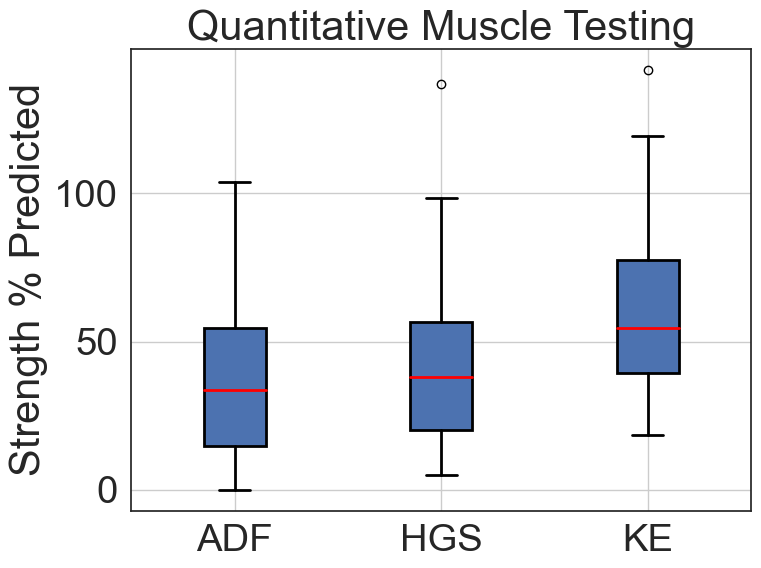

In [40]:
#Figure 1f - Box and Whiskers Plot
plt.rcParams['font.family'] = 'arial'
plt.figure(figsize=(8, 6)) 
meta.boxplot(column=['ADF', "HGS", "KE"], boxprops = dict(linewidth=2), whiskerprops = dict(linewidth=2), capprops=dict(linewidth=2), medianprops=dict(linewidth=2, color= 'red'), patch_artist=True)

plt.title('Quantitative Muscle Testing')
plt.ylabel('Strength % Predicted')
# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig1/qmt_boxplot.svg", format="svg")
plt.show()

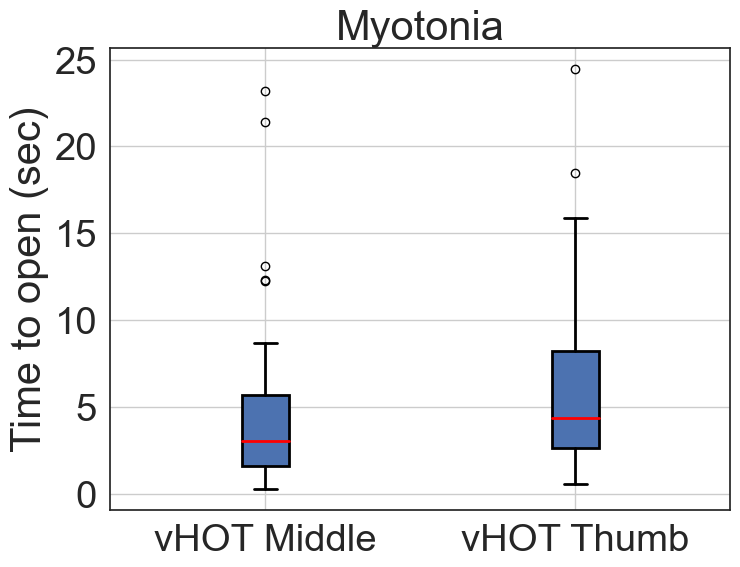

In [41]:
#Figure 1f - Box and Whiskers Plot
plt.rcParams['font.family'] = 'arial'
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
meta.boxplot(column=['vHOT Middle', "vHOT Thumb"], boxprops = dict(linewidth=2), whiskerprops = dict(linewidth=2), capprops=dict(linewidth=2), medianprops=dict(linewidth=2, color= 'red'), patch_artist=True)

plt.title('Myotonia')
plt.ylabel('Time to open (sec)')
# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig1/vhot_boxplot.svg", format="svg")
plt.show()

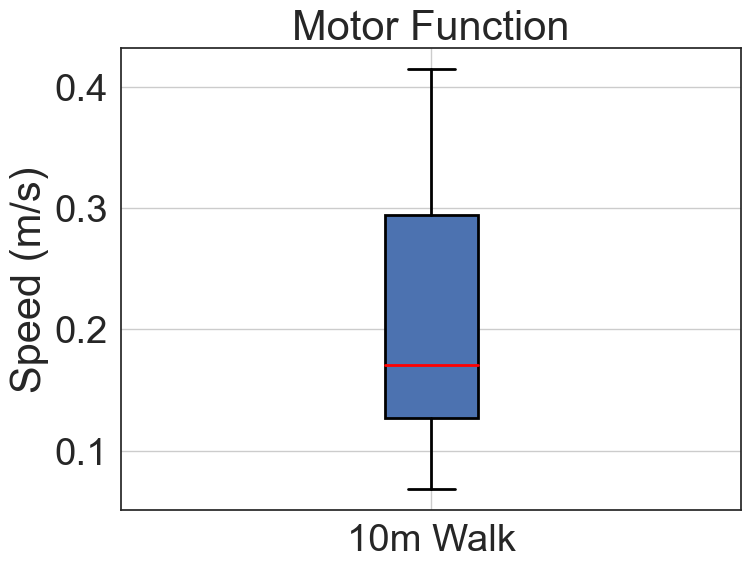

In [42]:
#Figure 1f - Box and Whiskers Plot
plt.rcParams['font.family'] = 'arial'
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
meta.boxplot(column=['10m Walk'], boxprops = dict(linewidth=2), whiskerprops = dict(linewidth=2), capprops=dict(linewidth=2), medianprops=dict(linewidth=2, color= 'red'), patch_artist=True)

plt.title('Motor Function')
plt.ylabel('Speed (m/s)')
# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/fig1/tmw_boxplot.svg", format="svg")
plt.show()

In [43]:
#subset meta by visit, then merge subset dfs by study_id
baseline = meta[meta['Visit'] == "Baseline"]
baseline = baseline.set_index('DM1 Participant ID')
month3 = meta[meta['Visit'] == "3-months"]
month3 = month3.set_index('DM1 Participant ID')
merged = pd.merge(baseline, month3, on='DM1 Participant ID', suffixes=('_BL', '_3M'))
#filter meta by removinf duplicate study ids
meta1 = meta.drop_duplicates(subset='DM1 Participant ID')
merged

No._BL  Visit_BL  Age_BL Sex_BL Group_BL Biopsy Method_BL  \
DM1 Participant ID                                                              
1.0                      1  Baseline    35.0      F      DM1        bergstrom   
4.0                      5  Baseline    38.0      M      DM1        bergstrom   
6.0                      8  Baseline    29.0      M      DM1        bergstrom   
7.0                     10  Baseline    30.0      F      DM1        bergstrom   
8.0                     12  Baseline    44.0      F      DM1        bergstrom   
9.0                     14  Baseline    29.0      M      DM1        bergstrom   
11.0                    17  Baseline    39.0      F      DM1        bergstrom   
12.0                    19  Baseline    41.0      M      DM1        bergstrom   
14.0                    22  Baseline    55.0      F      DM1        bergstrom   
15.0                    24  Baseline    49.0      M      DM1        bergstrom   
17.0                    27  Baseline    57.0      F      DM1        bergstrom   
18.0                    29  Baseline    37.0      M      DM1        bergstrom   
19.0                    31  Baseline    38.0      M      DM1        bergstrom   
20.0                    33  Baseline    36.0      M      DM1           needle   
21.0                    35  Baseline    42.0      M      DM1           needle   
24.0                    39  Baseline    42.0      F      DM1           needle   
25.0                    41  Baseline    42.0      F      DM1           needle   
26.0                    43  Baseline    41.0      F      DM1           needle   
27.0                    45  Baseline    45.0      F      DM1           needle   
29.0                    48  Baseline    38.0      F      DM1           needle   
30.0                    50  Baseline    38.0      F      DM1           needle   
31.0                    52  Baseline    45.0      M      DM1           needle   
32.0                    54  Baseline    21.0      F      DM1           needle   
33.0                    56  Baseline    20.0      M      DM1           needle   
35.0                    59  Baseline    62.0      F      DM1           needle   
37.0                    62  Baseline    32.0      F      DM1           needle   
38.0                    64  Baseline    31.0      M      DM1           needle   
39.0                    66  Baseline    21.0      F      DM1           needle   
40.0                    68  Baseline    44.0      F      DM1           needle   
41.0                    70  Baseline    38.0      F      DM1           needle   
42.0                    72  Baseline    69.0      M      DM1           needle   
43.0                    74  Baseline    24.0      F      DM1           needle   
44.0                    76  Baseline    47.0      F      DM1           needle   
45.0                    78  Baseline    34.0      M      DM1           needle   
46.0                    80  Baseline    30.0      M      DM1           needle   
47.0                    82  Baseline    45.0      F      DM1           needle   
57.0                    93  Baseline    21.0      M      DM1           needle   

                   Biopsy Location_BL  Longitudinal Cohort_BL  \
DM1 Participant ID                                              
1.0                 tibialis anterior                     1.0   
4.0                 tibialis anterior                     1.0   
6.0                 tibialis anterior                     1.0   
7.0                 tibialis anterior                     1.0   
8.0                 tibialis anterior                     1.0   
9.0                 tibialis anterior                     1.0   
11.0                tibialis anterior                     1.0   
12.0                tibialis anterior                     1.0   
14.0                tibialis anterior                     1.0   
15.0                tibialis anterior                     1.0   
17.0                tibialis anterior                     1.0   
18.0           

In [44]:
#Table 1 - DM1 and Control Sample Demographics

bl_count = (meta['Visit'] == "Baseline").sum()
m3_count = (meta['Visit'] == "3-months").sum()
print("Baseline:", bl_count, "3M:", m3_count)

fem_count = (merged['Sex_BL'] == "F").sum()
male_count = (merged['Sex_BL'] == "M").sum()
print("Females:",fem_count, "Males:", male_count)

fem_count1 = (meta1['Sex'] == "F").sum()
male_count1 = (meta1['Sex'] == "M").sum()
print("Females:",fem_count1, "Males:", male_count1)
ind_count = meta1.shape[0]
case_count = meta.shape[0]
print("Individuals:", ind_count)
print("Cases:", case_count)

age_min_value = meta['Age'].min()
age_max_value = meta['Age'].max()
print("Min age:",age_min_value, "Max age:", age_max_value)


Baseline: 52 3M: 37
Females: 21 Males: 16
Females: 37 Males: 22
Individuals: 59
Cases: 128
Min age: 9.0 Max age: 70.0


In [45]:
adf_mean = meta['ADF'].mean()
adf_std = meta['ADF'].std()
adf_n = meta['ADF'].count()
adf_se = adf_std/np.sqrt(adf_n)
adf_ci = sp.norm.interval(0.95, loc=adf_mean, scale=adf_se)

hgs_mean = meta['HGS'].mean()
hgs_std = meta['HGS'].std()
hgs_n = meta['HGS'].count()
hgs_se = hgs_std/np.sqrt(hgs_n)
hgs_ci = sp.norm.interval(0.95, loc=hgs_mean, scale=hgs_se)

ke_mean = meta['KE'].mean()
ke_std = meta['KE'].std()
ke_n = meta['KE'].count()
ke_se = ke_std/np.sqrt(ke_n)
ke_ci = sp.norm.interval(0.95, loc=ke_mean, scale=ke_se)

tmw_mean = meta['10m Walk'].mean()
tmw_std = meta['10m Walk'].std()
tmw_n = meta['10m Walk'].count()
tmw_se = tmw_std/np.sqrt(tmw_n)
tmw_ci = sp.norm.interval(0.95, loc=tmw_mean, scale=tmw_se)

vhotm_mean = meta['vHOT Middle'].mean()
vhotm_std = meta['vHOT Middle'].std()
vhotm_n = meta['vHOT Middle'].count()
vhotm_se = vhotm_std/np.sqrt(vhotm_n)
vhotm_ci = sp.norm.interval(0.95, loc=vhotm_mean, scale=vhotm_se)

vhotth_mean = meta['vHOT Thumb'].mean()
vhotth_std = meta['vHOT Thumb'].std()
vhotth_n = meta['vHOT Thumb'].count()
vhotth_se = vhotth_std/np.sqrt(vhotth_n)
vhotth_ci = sp.norm.interval(0.95, loc=vhotth_mean, scale=vhotth_se)

print("ADF:", adf_mean, adf_ci)
print("HGS:", hgs_mean, hgs_ci)
print("KE:", ke_mean, ke_ci)
print("10m Walk:", tmw_mean, tmw_ci)
print("vHOT Middle:", vhotm_mean, vhotm_ci)
print("vHOT Thumb:", vhotth_mean, vhotth_ci)


ADF: 36.24253738960385 (30.941543856641314, 41.54353092256638)
HGS: 41.41144759092246 (35.87165033684197, 46.95124484500295)
KE: 59.86082354506508 (54.224279199246, 65.49736789088416)
10m Walk: 0.20573551159026532 (0.18535931420540472, 0.22611170897512592)
vHOT Middle: 4.537559999999998 (3.2141940911142624, 5.860925908885735)
vHOT Thumb: 5.8903469387755045 (4.526716389622652, 7.253977487928357)


In [47]:
#read in amplicon psi values ***
amp = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/rMATS/amp_psi.csv")
amp = amp.set_index('event')
#order columns alphabetically
amp = amp.reindex(sorted(amp.columns), axis=1)
amp
# remove columns in amp that are not in meta_amp['Fastq ID']
amp = amp[amp.columns.intersection(meta_amp['SI ID'])]
amp = amp.transpose()
#set index to study sample names
meta_amp.sort_index(inplace=True)
amp.index = meta_amp.index
amp = amp.transpose()
amp

Subject ID  AdCo-001  AdCo-002  AdCo-004  AdCo-005  AdCo-006  AdCo-007  \
event                                                                    
ANK2        0.978723  0.934953  0.934118  0.941889  0.939035  0.866861   
ATP2A1      0.996970  0.997066  0.997104  0.996550  0.986245  0.995751   
BEST3       0.718295  0.787531  0.862912  0.677956  0.739331  0.798484   
BIN1        0.988700  0.988719  0.987961  0.989684  0.985458  0.985967   
CACNA1S     0.964886  0.954232  0.949754  0.954303  0.933543  0.927967   
CAMK2B      0.755052  0.654211  0.620323  0.664208  0.472149  0.577455   
CAPZB       0.838078  0.858408  0.760576  0.802819  0.812859  0.699270   
CCPG1       0.420352  0.332775  0.342507  0.394572  0.202968  0.329442   
CLASP1      0.913761  0.941500  0.937626  0.819338  0.915445  0.906444   
CLCN1       0.066746  0.071737  0.069386  0.074484  0.118060  0.034388   
DMD         0.929555  0.921675  0.899652  0.879690  0.906933  0.897837   
GFPT1       0.848806  0.908960  0.736341  0.804939  0.860901  0.792088   
GOLGA4      0.038287  0.046254  0.033412  0.062451  0.058453  0.055515   
INSR        0.314815  0.903209  0.538117  0.082192  0.711225  0.672269   
KIF13A      0.537594  0.459627  0.371981  0.408273  0.455390  0.378378   
MBNL1       0.060145  0.067892  0.068891  0.085223  0.074789  0.066905   
MBNL2       0.109821  0.113794  0.084547  0.095836  0.138086  0.099487   
NFIX        0.147597  0.141062  0.139915  0.178309  0.149837  0.168467   
OPA1        0.447413  0.469892  0.385096  0.475103  0.435901  0.398902   
RYR1        0.420292  0.285022  0.400044  0.410109  0.335118  0.272321   
SOS1        0.997696  0.980198  0.915709  0.878453  1.000000  0.938802   
VPS39       0.857490  0.831074  0.682449  0.813161  0.824921  0.698377   

Subject ID  AdCo-008  AdCo-009  AdCo-010  AdCo-011  ...   DM1-107   DM1-108  \
event                                               ...                       
ANK2        0.917093  0.924565  0.907384  0.918590  ...  0.719783  0.911124   
ATP2A1      0.995688  0.995518  0.991480  0.993033  ...  0.518487  0.994008   
BEST3       0.832335  0.739403  0.841107  0.823371  ...  0.353844  0.854273   
BIN1        0.986880  0.987669  0.985049  0.990348  ...  0.941488  0.984829   
CACNA1S     0.965442  0.947427  0.911706  0.940428  ...  0.684181  0.970013   
CAMK2B      0.690201  0.764719  0.583427  0.638334  ...  0.149452  0.660182   
CAPZB       0.752693  0.813293  0.817080  0.786072  ...  0.549305  0.825201   
CCPG1       0.399401  0.154500  0.213396  0.375951  ...  0.056631  0.390968   
CLASP1      0.897225  0.952991  0.841083  0.912636  ...  0.367180  0.926247   
CLCN1       0.058728  0.115634  0.118719  0.055729  ...  0.572763  0.059020   
DMD         0.842419  0.913235  0.929253  0.893519  ...  0.843681  0.916496   
GFPT1       0.760516  0.719059  0.880637  0.889666  ...  0.618982  0.863301   
GOLGA4      0.046561  0.047812  0.065901  0.045384  ...  0.162732  0.055375   
INSR        0.672241  0.990385  0.522099  0.518727  ...  0.098148  0.698652   
KIF13A      0.462264  0.560976  0.694175  0.623881  ...  0.056399  0.501880   
MBNL1       0.072305  0.076056  0.073474  0.059953  ...  0.355041  0.074004   
MBNL2       0.125000  0.228901  0.131281  0.120505  ...  0.379211  0.103465   
NFIX        0.130405  0.158463  0.154104  0.121696  ...  0.489923  0.176691   
OPA1        0.417649  0.396057  0.396911  0.419049  ...  0.168478  0.466792   
RYR1        0.444848  0.685472  0.376494  0.545567  ...  0.106127  0.375587   
SOS1        0.964557  1.000000  0.979915  0.992711  ...  0.551440  0.971722   
VPS39       0.805005  0.696466  0.778818  0.783936  ...  0.379301  0.487494   

Subject ID   DM1-109   DM1-110   DM1-114   DM1-115   DM2-001   DM2-002  \
event                                                                    
ANK2        0.929051  0.589875  0.750297  0.596099  0.705357  0.588903   
ATP2A1      0.996510  0.934847  0.531363  0.305087  0.449436  0.505978   
BEST3       0.826479  0.698243

In [48]:
#merge full/t50_all and mean delta psi data frames and then save to csv
sup_t3 = ep22.merge(t50_mean_delta_psi, left_index=True, right_index=True, how='left')
#filter out indexes starting with DMD, UDX, and LGMD
sup_t3 = sup_t3[~sup_t3.index.str.contains('DMD|UDX|LGMD')]
sup_t5 = t50_all.merge(t50_mean_delta_psi, left_index=True, right_index=True, how='left')

sup_t3_amp = amp.transpose()
sup_t3_amp = sup_t3_amp.sort_index()
sup_t3_amp = sup_t3_amp.merge(t50_mean_delta_psi, left_index=True, right_index=True, how='left')

# sup_t3.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_t3.csv")
# sup_t5.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_t5.csv")
# sup_t3_amp.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_t3_amp.csv")

In [49]:
#remove rows with indexes containing DM2 and CDM ***
amp_pca = amp.transpose()
amp_pca_cvc = amp_pca[~amp_pca.index.str.contains('CDM|DM2', na=False)]
#pca for all significant events ***
pca = PCA(n_components = 2)

pca_fit = pca.fit(amp_pca)
trans = pca.fit_transform(amp_pca)

# trans# Create a DataFrame 'trans' using the data from 'trans' and set column names as "PC1" and "PC2"
trans = pd.DataFrame(trans, columns=("PC1", "PC2"))
trans.index = meta_amp.index
trans.index.names = ['SI ID']
# Add a group column
trans['Group'] = meta_amp['Group'].values

trans


PC1       PC2 Group
SI ID                             
AdCo-001 -1.430185  0.063516  AdCo
AdCo-002 -1.507533  0.327688  AdCo
AdCo-004 -1.338272  0.155547  AdCo
AdCo-005 -1.217703 -0.111487  AdCo
AdCo-006 -1.351143  0.155940  AdCo
...            ...       ...   ...
DM1-115   0.738009  0.007063   DM1
DM2-001   0.006734 -0.079893   DM2
DM2-002   0.072722 -0.078967   DM2
DM2-003  -1.269835  0.178817   DM2
DM2-004   0.192273 -0.086590   DM2

[129 rows x 3 columns]

In [50]:
#creating color pallete for groups 
diag_label = meta_amp["Group"]
diag_pal = { 
    
    'AdCo':"firebrick",
    'DM1':'dodgerblue',
    'DMD': 'darkorchid',
    'DM2':"darkorange",
    'CDM':'gold',
    'LGMD':"forestgreen",  
}
diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
diag_col = pd.Series(diag_label).map(diag_lut)


/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/1257308599.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ha in ax.legend_.legendHandles:


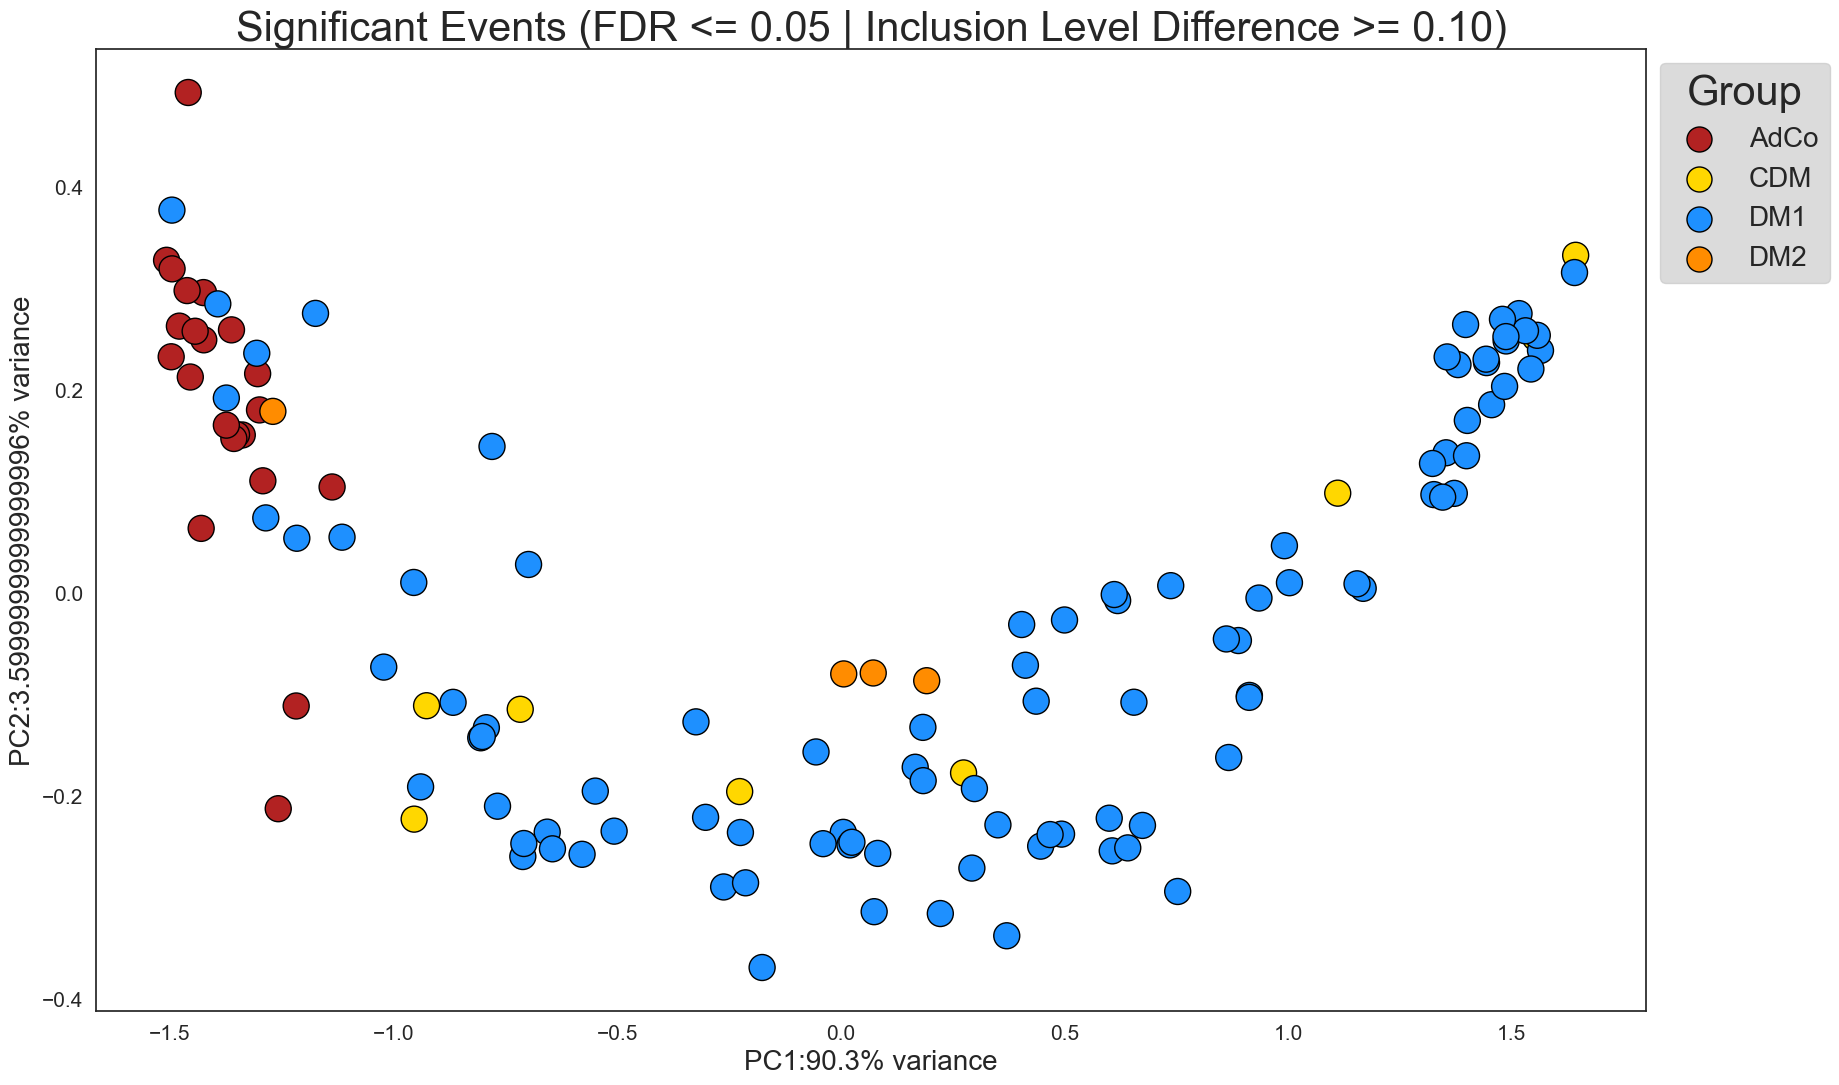

In [51]:
#PCA plot for amplicon data
plt.figure(figsize=(20,12.5))
plt.rcParams['font.family'] = 'arial'
sns.set_style('white') 
ax =sns.scatterplot(y = trans["PC2"],  x= trans["PC1"], hue = trans['Group'], palette = diag_pal, s = 350, linewidth=1, edgecolor ='black') 
plt.xticks( size = 15)
plt.yticks(size = 15)
plt.title("Significant Events (FDR <= 0.05 | Inclusion Level Difference >= 0.10)", size = 30)
plt.ylabel("PC2:" + str((round(pca.explained_variance_ratio_[1],3)*100)) + "% variance", size = 20)
plt.xlabel('PC1:' + str((round(pca.explained_variance_ratio_[0],3)*100)) + "% variance", size = 20)
plt.legend(title='Group', bbox_to_anchor=(1.00, 1), loc=2, markerscale=3, fontsize=20, facecolor = 'lightgrey')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("black")

#to identify each point with sample name
# for i in range(ttrans.shape[0]):
#     ax.text(ttrans["PC1"][i], ttrans["PC2"][i], ttrans.index[i], horizontalalignment='right', size='small', color='black', weight='semibold')

# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/targeted_pca.svg", format = "svg", bbox_inches='tight', pad_inches = 0.5, dpi = 300)

In [87]:
#pca for all significant events
stran = sig_all.transpose()
stran = stran[~stran.index.str.contains('CDM|DM2|DMD|UDX|LGMD', na=False)]
stran
stran.sort_index(inplace=True)
meta_cvc.sort_index(inplace=True)
spca = PCA(n_components = 2)
spca_fit = spca.fit(stran)
strans = spca.fit_transform(stran)

strans = pd.DataFrame(strans, columns=("PC1", "PC2"))
strans.index = meta_cvc.index
strans.index.names = ['SI ID']
strans['Group'] = meta_cvc['Group'].values
strans

PC1       PC2 Group
SI ID                             
AdCo-001 -5.622322  1.444586  AdCo
AdCo-002 -5.622618  1.014646  AdCo
AdCo-004 -5.726505  1.431627  AdCo
AdCo-005 -5.581727  1.090287  AdCo
AdCo-006 -5.026733  0.400404  AdCo
...            ...       ...   ...
DM1-108  -4.985282  0.388162   DM1
DM1-109  -4.920094  0.349162   DM1
DM1-110  -2.897123  0.257508   DM1
DM1-114   2.388743 -1.468274   DM1
DM1-115   2.469908  0.174305   DM1

[117 rows x 3 columns]

In [88]:
#make a df of PC1 of trans_1 and strans_1 indexed by the Fastq ID
pc1s = pd.DataFrame(strans['PC1'])
pc1s = pc1s.rename(columns = {'PC1':'PC1_strans'})
pc1s = pc1s.merge(trans, left_index=True, right_index=True, how='left')
pc1s = pc1s.rename(columns = {'PC1':'PC1_trans'})
pc1s

PC1_strans  PC1_trans       PC2 Group
SI ID                                          
AdCo-001   -5.622322  -1.430185  0.063516  AdCo
AdCo-002   -5.622618  -1.507533  0.327688  AdCo
AdCo-004   -5.726505  -1.338272  0.155547  AdCo
AdCo-005   -5.581727  -1.217703 -0.111487  AdCo
AdCo-006   -5.026733  -1.351143  0.155940  AdCo
...              ...        ...       ...   ...
DM1-108    -4.985282  -1.392986  0.284756   DM1
DM1-109    -4.920094  -1.495586  0.377130   DM1
DM1-110    -2.897123  -0.779779  0.144242   DM1
DM1-114     2.388743   0.674785 -0.229182   DM1
DM1-115     2.469908   0.738009  0.007063   DM1

[117 rows x 4 columns]

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/1842835256.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ha in ax.legend_.legendHandles:


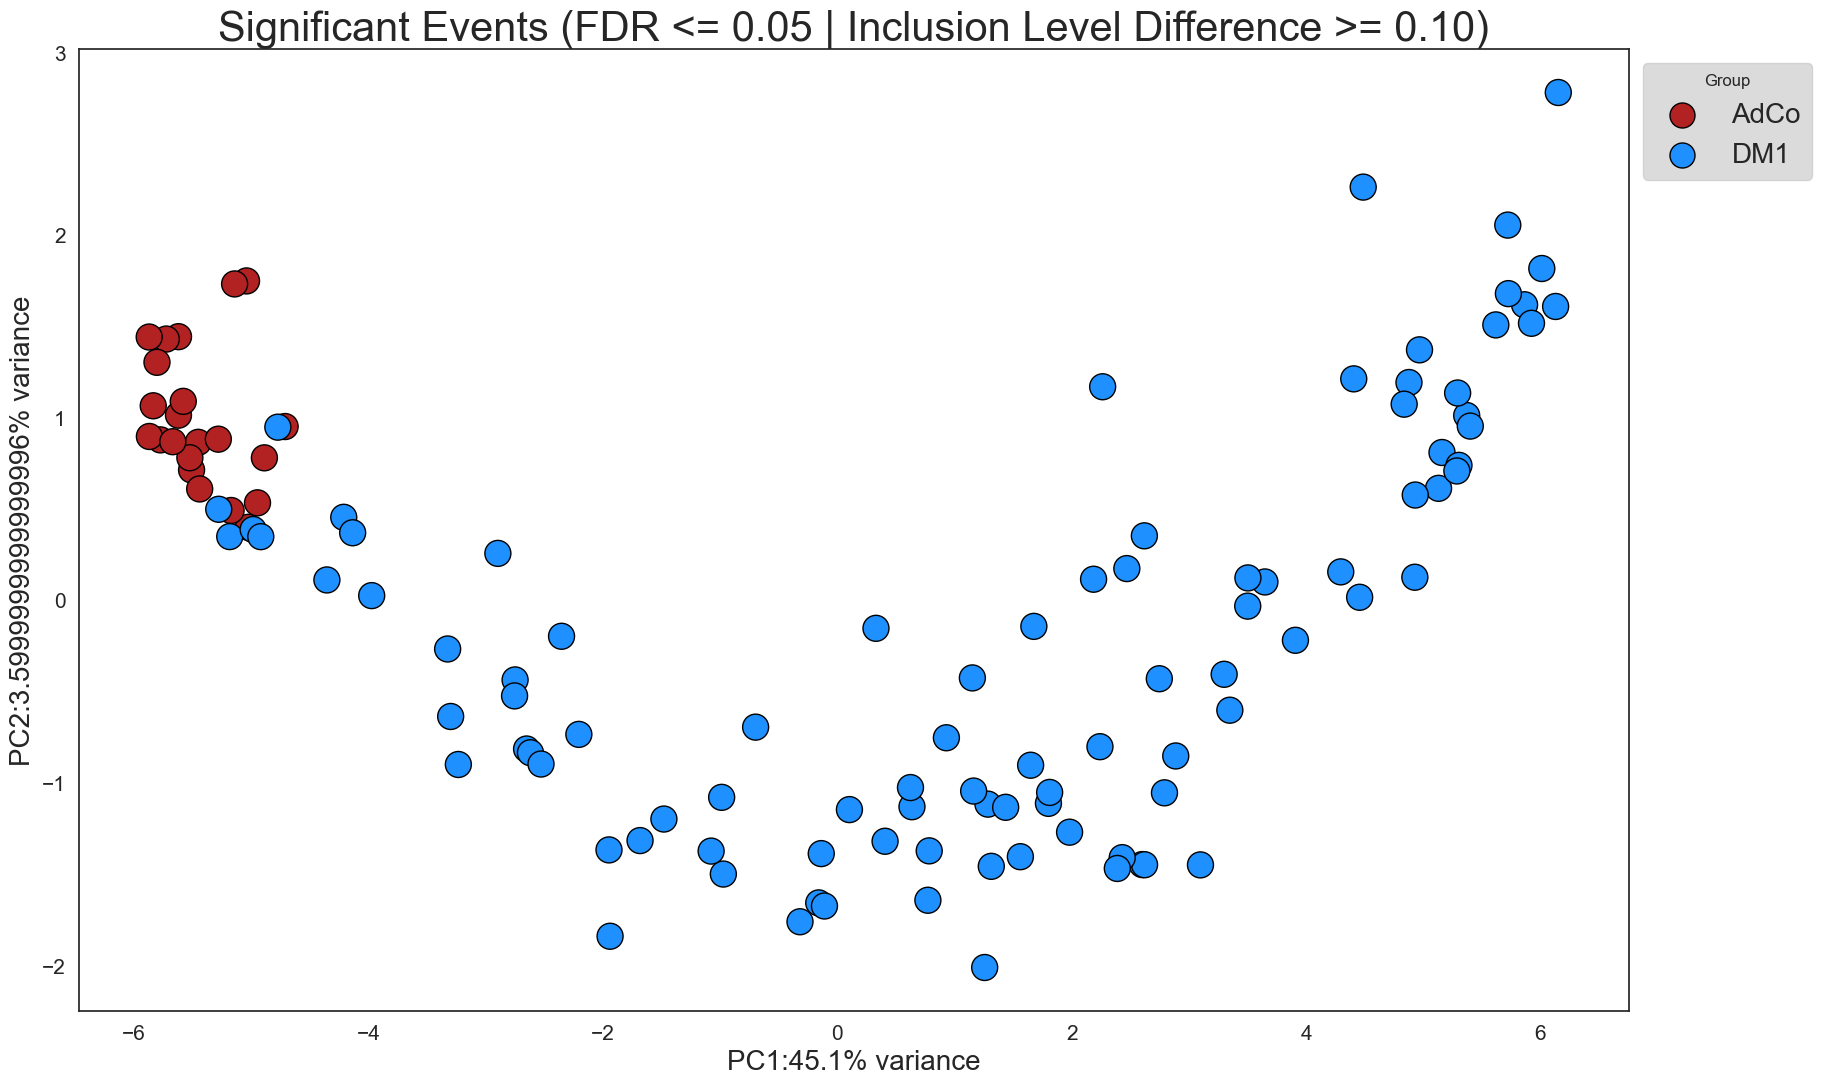

In [91]:
plt.figure(figsize=(20,12.5))
plt.rcParams['font.family'] = 'arial'
sns.set_style('white')
ax =sns.scatterplot(y = strans["PC2"],  x= strans["PC1"], hue = strans['Group'], palette = diag_pal, s = 350, linewidth=1, edgecolor ='black') 
plt.xticks( size = 15)
plt.yticks(size = 15)
plt.title("Significant Events (FDR <= 0.05 | Inclusion Level Difference >= 0.10)", size = 30)
plt.ylabel("PC2:" + str((round(spca.explained_variance_ratio_[1],3)*100)) + "% variance", size = 20)
plt.xlabel('PC1:' + str((round(spca.explained_variance_ratio_[0],3)*100)) + "% variance", size = 20)
plt.legend(title='Group', bbox_to_anchor=(1.00, 1), loc=2, markerscale=3, fontsize=20, facecolor = 'lightgrey')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("black")
# for i in range(strans.shape[0]):
    # ax.text(strans["PC1"][i], strans["PC2"][i], strans.index[i], horizontalalignment='right', size='medium', color='black', weight='semibold')

# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/total_all_sig_pca.svg", format = "svg", bbox_inches='tight', pad_inches = 0.5, dpi = 300)

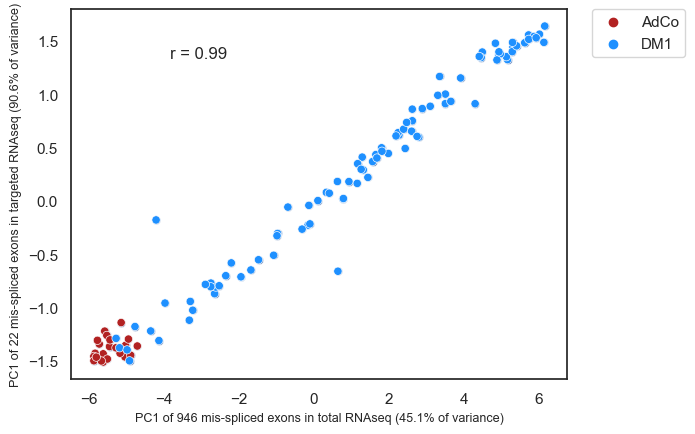

In [93]:
#Scatterplot comparing PC1 of 946 mis-spliced exons in total RNAseq and PC1 of 22 mis-spliced exons in targeted RNAseq
sns.set(style='white')  # Optional: Set the style
scatterplot = sns.scatterplot(x='PC1_strans', y='PC1_trans', data=pc1s)
sns.scatterplot(x='PC1_strans', y='PC1_trans', hue=pc1s['Group'], palette=diag_pal, data=pc1s)
plt.rcParams['font.family'] = 'arial'
# Calculate Pearson correlation coefficient
correlation_coefficient = pc1s['PC1_trans'].corr(pc1s['PC1_strans'], method='pearson')
#calculate coeffiecient of determination (R-squared)

# Add Pearson correlation coefficient to the plot
text = f'r = {correlation_coefficient:.2f}'
plt.text(0.20, 0.90, text, transform=scatterplot.transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('PC1 of 946 mis-spliced exons in total RNAseq (45.1% of variance)', size = 9)
plt.ylabel('PC1 of 22 mis-spliced exons in targeted RNAseq (90.6% of variance)', size = 9)

#label each dot with Fastq ID to find outliers
# for i in range(pc1s.shape[0]):
#     scatterplot.text(pc1s["PC1_strans"][i], pc1s["PC1_trans"][i], pc1s.index[i], horizontalalignment='right', size='small', color='black')

#move legend to upper right corner
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/pc1_v_pc1.svg', format='svg')
plt.show()

In [94]:
norms = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/norms/nej_norms_02jul2024.csv")
norms = pd.DataFrame(norms)
norms.set_index('event', inplace=True)
norms

95th_dm1_psi  med_cntl_psi
event                              
ANK2         0.389732      0.929341
ATP2A1       0.013940      0.995928
BEST3        0.064702      0.800157
BIN1         0.637234      0.987815
CACNA1S      0.215924      0.944751
CAMK2B       0.017415      0.614877
CAPZB        0.090928      0.807839
CCPG1        0.006691      0.336800
CLASP1       0.034969      0.915728
CLCN1        0.937154      0.072884
DMD          0.576615      0.914452
GFPT1        0.317102      0.837051
GOLGA4       0.513339      0.047496
INSR         0.003717      0.682065
KIF13A       0.007760      0.457509
MBNL1        0.787854      0.069253
MBNL2        0.723890      0.110850
NFIX         0.877234      0.152887
OPA1         0.077496      0.443150
RYR1         0.035256      0.373822
SOS1         0.162011      0.976119
VPS39        0.056004      0.809083

In [95]:
#Generating SI scores from raw amp psi
si_scores = pd.DataFrame(index=amp.columns, columns=['si_score'])
ndsi = amp.copy()

for column in ndsi.columns:
    x_result = 0
    for index, value in ndsi[column].items():
        # normalize psi
        x = ((value - norms.loc[index, 'med_cntl_psi'])/(norms.loc[index, '95th_dm1_psi'] - norms.loc[index, 'med_cntl_psi']))
        #save normalized psi to a new df
        ndsi[column][index] = x
        #sum normalized psi
        x_result += x
    # Calculate the average for the column and store it in 'splice_index_scores'
    si_scores.loc[column, 'si_score'] = x_result / len(amp)
    #if si_score is greater than 1, set to 1, less than 0, set to 0
    if si_scores.loc[column, 'si_score'] > 1:
        si_scores.loc[column, 'si_score'] = 1
    elif si_scores.loc[column, 'si_score'] < 0:
        si_scores.loc[column, 'si_score'] = 0

# si_scores.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_scores_02jul2024.csv")
# ndsi.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/ndsi_02jul2024.csv")
si_scores


si_score
SI ID             
AdCo-001         0
AdCo-002         0
AdCo-004  0.035452
AdCo-005  0.051269
AdCo-006  0.039997
...            ...
DM1-115   0.678175
DM2-001   0.480618
DM2-002   0.503371
DM2-003   0.062713
DM2-004   0.526069

[129 rows x 1 columns]

In [96]:
#force ranking raw psi df for heatmap
amp_heat = amp.transpose()
amp_heat =  amp_heat.merge(si_scores, left_index=True,right_index=True, how='left')

#remove index title
amp_heat.index.name = None
# Create a ranking based on the 'si_score' column
amp_heat['si_rank'] = amp_heat['si_score'].rank()

# Sort the DataFrame based on the 'sis_rank' column
amp_heat = amp_heat.sort_values(by='si_rank')

# Drop the 'sis_rank' column if you don't need it for the heatmap
amp_heat = amp_heat.drop(columns=['si_rank'])
amp_heat = amp_heat.drop(columns=['si_score'])
amp_heat = amp_heat.transpose()
amp_heat


AdCo-001  AdCo-025  AdCo-019  AdCo-016  AdCo-015   DM1-108  AdCo-009  \
ANK2     0.978723  0.868373  0.944865  0.937534  0.914518  0.911124  0.924565   
ATP2A1   0.996970  0.995356  0.996619  0.996367  0.996501  0.994008  0.995518   
BEST3    0.718295  0.854776  0.892710  0.857868  0.785105  0.854273  0.739403   
BIN1     0.988700  0.988329  0.988572  0.990281  0.988068  0.984829  0.987669   
CACNA1S  0.964886  0.956330  0.952753  0.944166  0.957375  0.970013  0.947427   
CAMK2B   0.755052  0.692791  0.671616  0.609432  0.585147  0.660182  0.764719   
CAPZB    0.838078  0.799762  0.813416  0.800207  0.835185  0.825201  0.813293   
CCPG1    0.420352  0.341803  0.340825  0.377143  0.360813  0.390968  0.154500   
CLASP1   0.913761  0.964755  0.911032  0.939297  0.985577  0.926247  0.952991   
CLCN1    0.066746  0.069223  0.076892  0.073377  0.092622  0.059020  0.115634   
DMD      0.929555  0.927234  0.917565  0.911969  0.938931  0.916496  0.913235   
GFPT1    0.848806  0.776750  0.866496  0.843224  0.870160  0.863301  0.719059   
GOLGA4   0.038287  0.054137  0.044807  0.054584  0.034693  0.055375  0.047812   
INSR     0.314815  0.705556  0.748775  0.702703  0.703470  0.698652  0.990385   
KIF13A   0.537594  0.428934  0.566327  0.522782  0.491497  0.501880  0.560976   
MBNL1    0.060145  0.069615  0.067199  0.084734  0.095125  0.074004  0.076056   
MBNL2    0.109821  0.125321  0.109586  0.093044  0.152137  0.103465  0.228901   
NFIX     0.147597  0.138106  0.150242  0.152714  0.191414  0.176691  0.158463   
OPA1     0.447413  0.486597  0.476896  0.438887  0.469835  0.466792  0.396057   
RYR1     0.420292  0.397043  0.433035  0.370683  0.485331  0.375587  0.685472   
SOS1     0.997696  0.927318  0.925847  0.982500  0.934579  0.971722  1.000000   
VPS39    0.857490  0.867898  0.816283  0.881201  0.761439  0.487494  0.696466   

         AdCo-011   DM1-109  AdCo-002  ...   DM1-085   DM1-035   CDM-034  \
ANK2     0.918590  0.929051  0.934953  ...  0.418919  0.374842  0.430086   
ATP2A1   0.993033  0.996510  0.997066  ...  0.021915  0.023901  0.015085   
BEST3    0.823371  0.826479  0.787531  ...  0.102548  0.081236  0.060394   
BIN1     0.990348  0.986898  0.988719  ...  0.567111  0.691282  0.604364   
CACNA1S  0.940428  0.953587  0.954232  ...  0.245219  0.240168  0.209070   
CAMK2B   0.638334  0.658595  0.654211  ...  0.017376  0.018046  0.024852   
CAPZB    0.786072  0.812525  0.858408  ...  0.111333  0.116898  0.045070   
CCPG1    0.375951  0.306989  0.332775  ...  0.006906  0.005259  0.007505   
CLASP1   0.912636  0.928410  0.941500  ...  0.058863  0.016909  0.036897   
CLCN1    0.055729  0.078438  0.071737  ...  0.933103  0.920213  0.948344   
DMD      0.893519  0.941104  0.921675  ...  0.678263  0.630023  0.646570   
GFPT1    0.889666  0.849894  0.908960  ...  0.390433  0.260184  0.461801   
GOLGA4   0.045384  0.041332  0.046254  ...  0.435449  0.473507  0.444899   
INSR     0.518727  0.872321  0.903209  ...  0.066589  0.018224  0.052402   
KIF13A   0.623881  0.575988  0.459627  ...  0.015198  0.029478  0.006897   
MBNL1    0.059953  0.077362  0.067892  ...  0.747390  0.778540  0.816046   
MBNL2    0.120505  0.132100  0.113794  ...  0.708128  0.722109  0.730018   
NFIX     0.121696  0.167412  0.141062  ...  0.823861  0.788314  0.886584   
OPA1     0.419049  0.473832  0.469892  ...  0.082716  0.093362  0.071538   
RYR1     0.545567  0.439612  0.285022  ...  0.041422  0.064545  0.077513   
SOS1     0.992711  0.932432  0.980198  ...  0.140992  0.305842  0.142857   
VPS39    0.783936  0.829053  0.831074  ...  0.078265  0.061653  0.105979   

          DM1-038   DM1-039   DM1-027   DM1-033   DM1-034   DM1-020   CDM-001  
ANK2     0.475158  0.456177  0.550989  0.499712  0.470544  0.298890  0.386034  
ATP2A1   0.014672  0.011837  0.009931  0.010235  0.013443  0.014153  0.015840  
BEST3    0.124103  0.156075  0.073119  0.081906  0.064824  0.031065  0.048725  
BIN1     0.691311  0.662567  0.746205  0.590360  0.639344  0.528943  0.52471

In [97]:
#Force ranking ndsi datafram for heatmap
ndsi_heat = ndsi.transpose()
ndsi_heat =  ndsi_heat.merge(si_scores, left_index=True,right_index=True, how='left')

#remove index title
ndsi_heat.index.name = None
# Create a ranking based on the 'si_score' column
ndsi_heat['si_rank'] = ndsi_heat['si_score'].rank()

# Sort the DataFrame based on the 'sis_rank' column
ndsi_heat = ndsi_heat.sort_values(by='si_rank')

# Drop the 'sis_rank' column if you don't need it for the heatmap
ndsi_heat = ndsi_heat.drop(columns=['si_rank'])
ndsi_heat = ndsi_heat.drop(columns=['si_score'])
ndsi_heat = ndsi_heat.transpose()
ndsi_heat

AdCo-001  AdCo-025  AdCo-019  AdCo-016  AdCo-015   DM1-108  AdCo-009  \
ANK2    -0.091515  0.112986 -0.028769 -0.015182  0.027470  0.033760  0.008852   
ATP2A1  -0.001060  0.000583 -0.000703 -0.000447 -0.000583  0.001956  0.000418   
BEST3    0.111307 -0.074266 -0.125845 -0.078470  0.020466 -0.073583  0.082606   
BIN1    -0.002526 -0.001466 -0.002159 -0.007033 -0.000721  0.008518  0.000416   
CACNA1S -0.027627 -0.015887 -0.010979  0.000803 -0.017320 -0.034661 -0.003671   
CAMK2B  -0.234618 -0.130408 -0.094967  0.009114  0.049761 -0.075830 -0.250798   
CAPZB   -0.042179  0.011267 -0.007779  0.010646 -0.038144 -0.024218 -0.007607   
CCPG1   -0.253104 -0.015157 -0.012194 -0.122212 -0.072743 -0.164091  0.552243   
CLASP1   0.002232 -0.055665  0.005331 -0.026760 -0.079306 -0.011944 -0.042309   
CLCN1   -0.007102 -0.004237  0.004636  0.000569  0.022837 -0.016041  0.049463   
DMD     -0.044707 -0.037835 -0.009215  0.007350 -0.072460 -0.006051  0.003601   
GFPT1   -0.022608  0.115975 -0.056630 -0.011873 -0.063678 -0.050487  0.226930   
GOLGA4  -0.019769  0.014256 -0.005773  0.015214 -0.027485  0.016912  0.000678   
INSR     0.541389 -0.034630 -0.098342 -0.030424 -0.031555 -0.024452 -0.454516   
KIF13A  -0.178066  0.063535 -0.241952 -0.145132 -0.075571 -0.098657 -0.230055   
MBNL1   -0.012674  0.000504 -0.002858  0.021544  0.036004  0.006612  0.009467   
MBNL2   -0.001678  0.023605 -0.002062 -0.029045  0.067348 -0.012046  0.192567   
NFIX    -0.007304 -0.020406 -0.003651 -0.000239  0.053188  0.032863  0.007697   
OPA1    -0.011658 -0.118818 -0.092289  0.011658 -0.072979 -0.064655  0.128791   
RYR1    -0.137258 -0.068588 -0.174894  0.009269 -0.329358 -0.005216 -0.920501   
SOS1    -0.026504  0.059943  0.061750 -0.007838  0.051024  0.005400 -0.029334   
VPS39   -0.064278 -0.078099 -0.009561 -0.095764  0.063266  0.427033  0.149543   

         AdCo-011   DM1-109  AdCo-002  ...   DM1-085   DM1-035   CDM-034  \
ANK2     0.019925  0.000538 -0.010400  ...  0.945911  1.027594  0.925216   
ATP2A1   0.002948 -0.000592 -0.001159  ...  0.991879  0.989857  0.998834   
BEST3   -0.031565 -0.035791  0.017167  ...  0.948541  0.977519  1.005858   
BIN1    -0.007225  0.002615 -0.002579  ...  1.200020  0.845833  1.093759   
CACNA1S  0.005932 -0.012123 -0.013008  ...  0.959806  0.966736  1.009404   
CAMK2B  -0.039261 -0.073173 -0.065835  ...  1.000066  0.998945  0.987552   
CAPZB    0.030363 -0.006537 -0.070538  ...  0.971538  0.963775  1.063966   
CCPG1   -0.118603  0.090306  0.012194  ...  0.999349  1.004340  0.997536   
CLASP1   0.003510 -0.014400 -0.029262  ...  0.972871  1.020505  0.997811   
CLCN1   -0.019850  0.006426 -0.001328  ...  0.995312  0.980398  1.012947   
DMD      0.061962 -0.078889 -0.021381  ...  0.699119  0.841911  0.792930   
GFPT1   -0.101194 -0.024701 -0.138300  ...  0.858965  1.109469  0.721706   
GOLGA4  -0.004534 -0.013232 -0.002668  ...  0.832796  0.914494  0.853084   
INSR     0.240788 -0.280471 -0.326004  ...  0.907316  0.978614  0.928230   
KIF13A  -0.369922 -0.263434 -0.004710  ...  0.983463  0.951710  1.001920   
MBNL1   -0.012942  0.011285 -0.001894  ...  0.943690  0.987039  1.039232   
MBNL2    0.015750  0.034664  0.004802  ...  0.974289  0.997095  1.009997   
NFIX    -0.043061  0.020053 -0.016324  ...  0.926315  0.877240  1.012908   
OPA1     0.065913 -0.083908 -0.073136  ...  0.985724  0.956610  1.016294   
RYR1    -0.507273 -0.194321  0.262282  ...  0.981787  0.913492  0.875188   
SOS1    -0.020381  0.053662 -0.005011  ...  1.025819  0.823327  1.023528   
VPS39    0.033393 -0.026518 -0.029201  ...  0.970441  0.992499  0.933640   

          DM1-038   DM1-039   DM1-027   DM1-033   DM1-034   DM1-020   CDM-001  
ANK2     0.841689  0.876865  0.701160  0.796186  0.850239  1.168346  1.006853  
ATP2A1   0.999255  1.002142  1.004083  1.003773  1.000506  0.999783  0.998065  
BEST3    0.919233  0.875760  0.988556  0.976609  0.999835  1.045737  1.021724  
BIN1     0.845748  0.927741  0.689170  1.133702  0.993980  1.308890  1.32094

In [98]:
dm1 = ['dodgerblue'] * sum(meta_amp['Group'] == "DM1")
adco = ['firebrick'] * sum(meta_amp['Group'] == "AdCo")
dm2 = ['darkorange'] * sum(meta_amp['Group'] == "DM2")
cdm = ['gold'] * sum(meta_amp['Group'] == "CDM")
groups = adco+cdm+dm1+dm2
df3 = pd.DataFrame()
df3['group'] = meta_amp['Group']
#remove LGMD and DMD from group
df3 = df3[~df3['group'].str.contains('LGMD|DMD')]
df3['color'] = groups
df3.index = meta_amp['Group']
df3

group       color
Group                  
AdCo   AdCo   firebrick
AdCo   AdCo   firebrick
AdCo   AdCo   firebrick
AdCo   AdCo   firebrick
AdCo   AdCo   firebrick
...     ...         ...
DM1     DM1  dodgerblue
DM2     DM2  darkorange
DM2     DM2  darkorange
DM2     DM2  darkorange
DM2     DM2  darkorange

[129 rows x 2 columns]

In [99]:
male = ['gold'] * sum(meta_amp['Sex'] =="M")
female = ['lightslategrey'] * sum(meta_amp['Sex'] == "F")

sex = pd.Series(male + female)

df4 = pd.DataFrame()
df4['sex'] = meta_amp['Sex']
df4.loc[meta_amp['Sex']=='M', 'color'] = 'gold'
df4.loc[meta_amp['Sex']=='F', 'color'] = 'slategrey'
df4.loc[meta_amp['Sex'].isnull(), 'color'] = 'white'
group = pd.Series(groups)

meta_amp.loc[meta_amp['Sex'].isnull(), 'Sex'] = "NA" 
 
sex_label = meta_amp["Sex"]
sex_pal = ['dimgrey', 'silver', 'black']
sex_lut = dict(zip(map(str, sex_label.unique()), sex_pal))
sex_col = pd.Series(sex_label).map(sex_lut)

diag_label = meta_amp["Group"]
diag_pal = ["firebrick",'gold','dodgerblue','darkorange']
diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
diag_col = pd.Series(diag_label).map(diag_lut)

comb_col = pd.DataFrame(sex_col).join(pd.DataFrame(diag_col))
comb_col.columns = ("Sex", "Group")
comb_col.index = meta_amp.index
comb_col


Sex       Group
SI ID                        
AdCo-001  dimgrey   firebrick
AdCo-002   silver   firebrick
AdCo-004   silver   firebrick
AdCo-005   silver   firebrick
AdCo-006   silver   firebrick
...           ...         ...
DM1-115   dimgrey  dodgerblue
DM2-001    silver  darkorange
DM2-002    silver  darkorange
DM2-003   dimgrey  darkorange
DM2-004    silver  darkorange

[129 rows x 2 columns]

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/430488365.py:18: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cg.ax_row_dendrogram.set_ylim([0,0])
/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/430488365.py:19: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cg.ax_col_dendrogram.set_xlim([0,0])


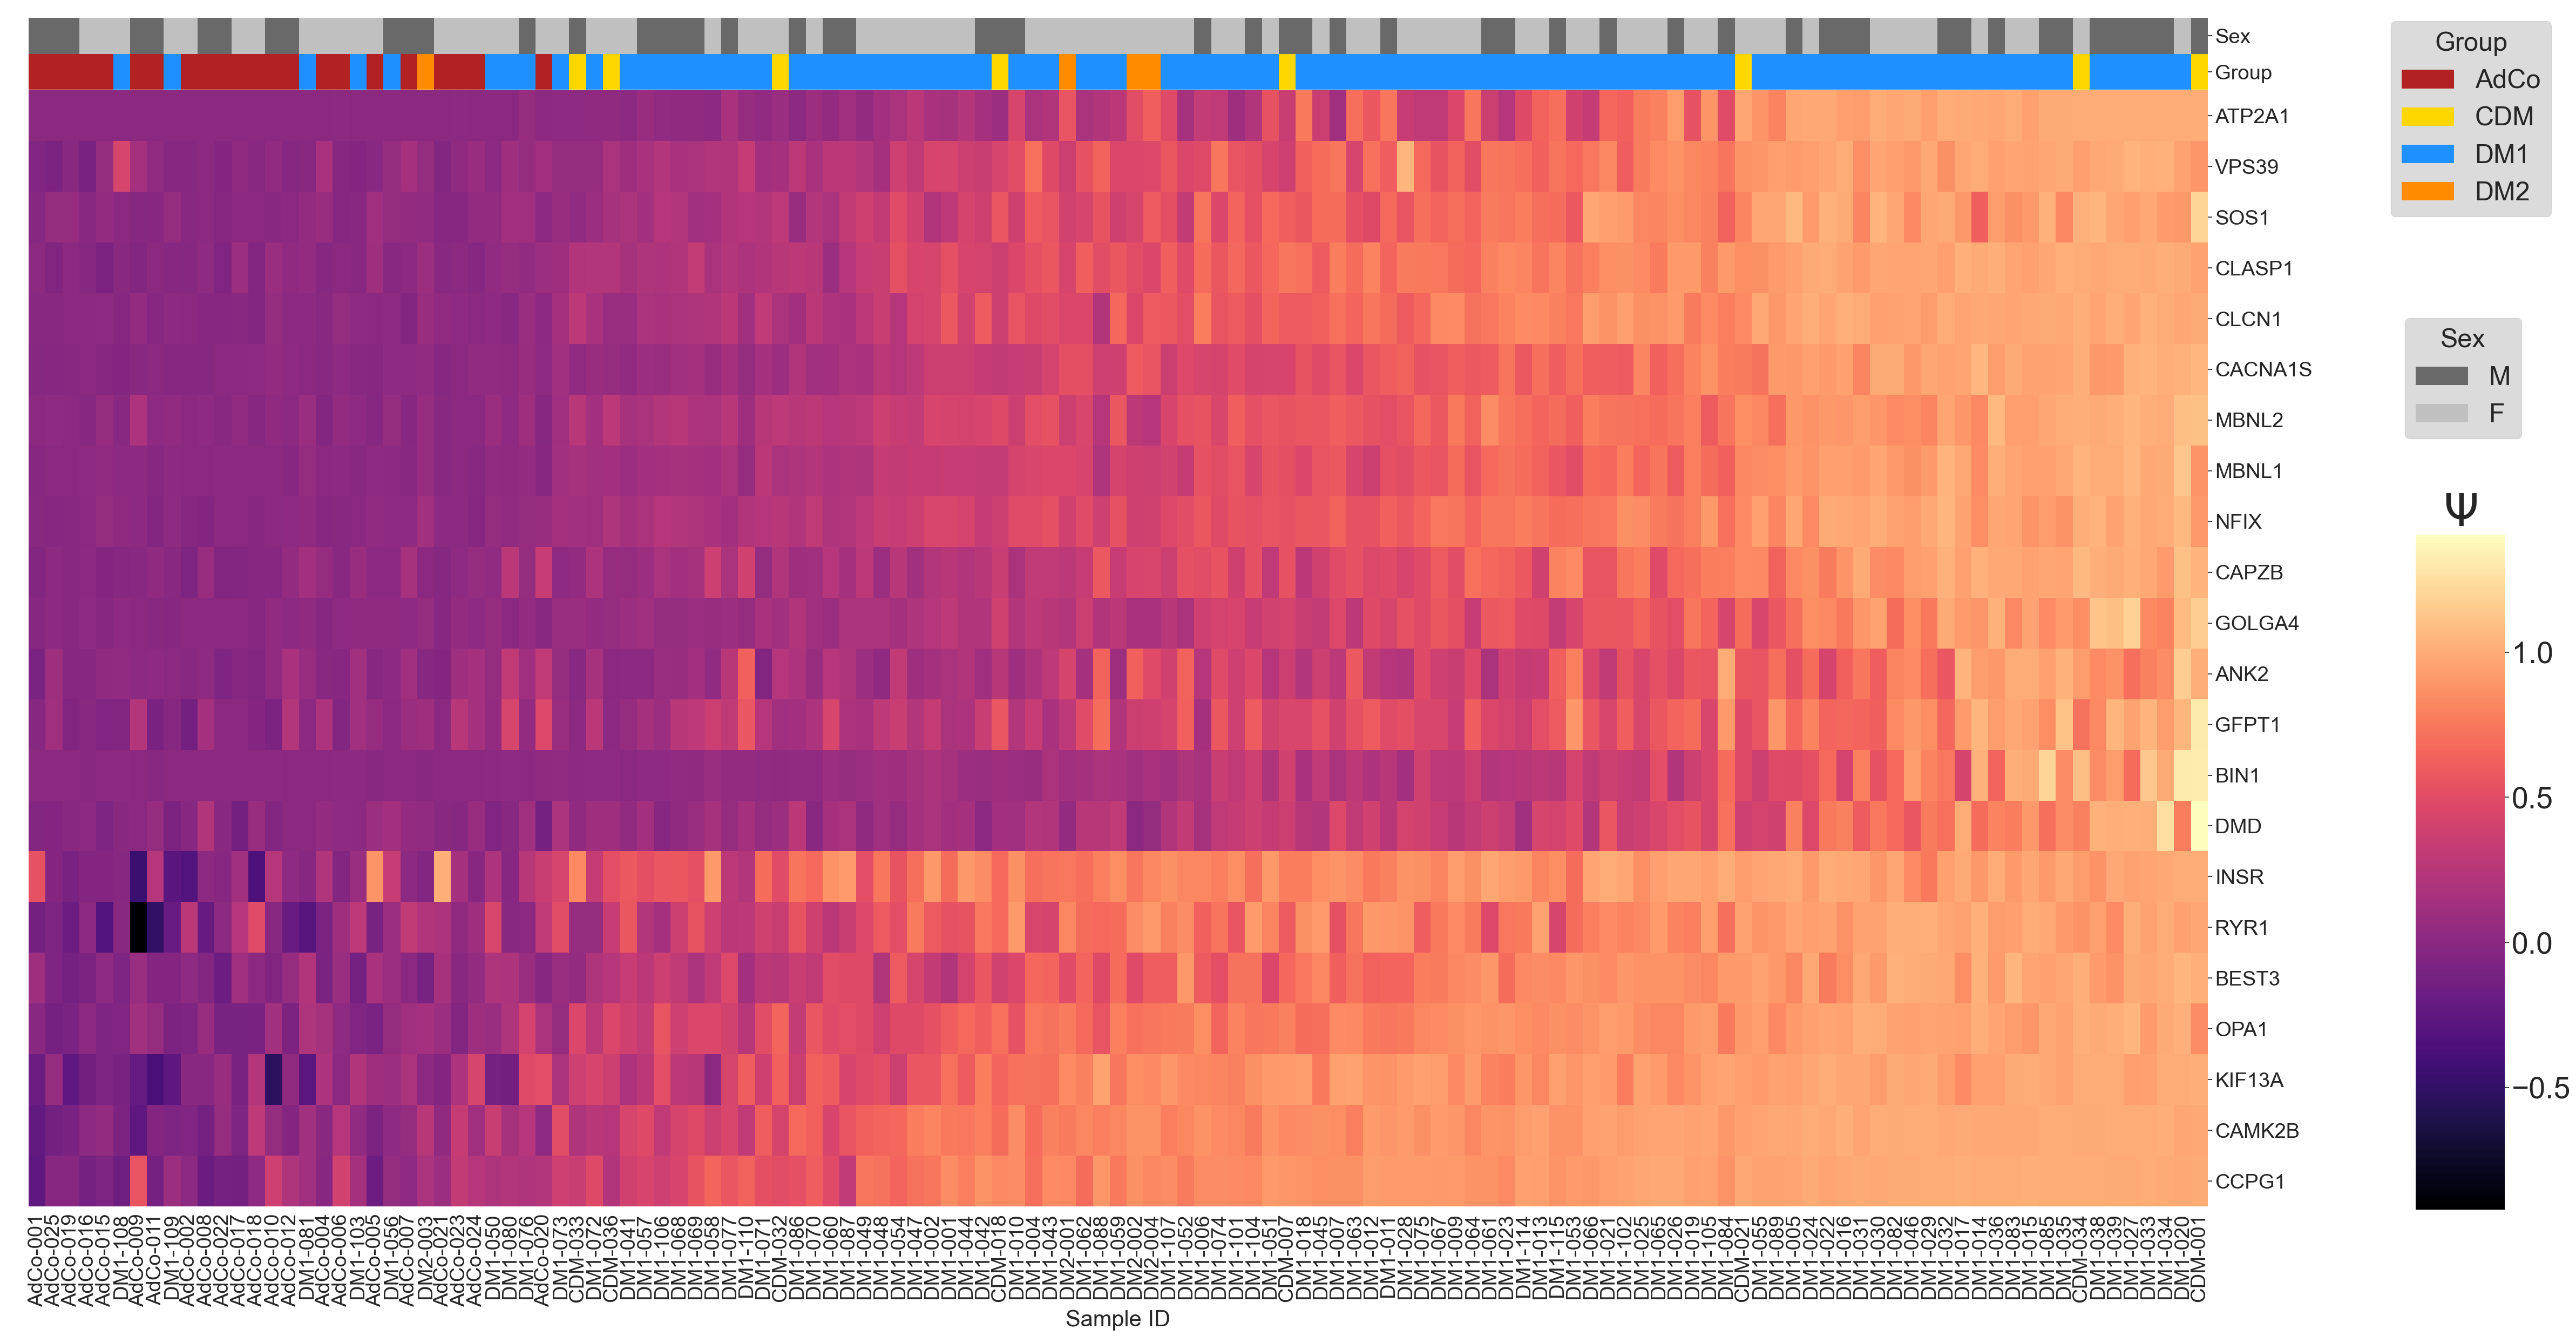

In [100]:
#amplicon heatmap
cmap = sns.cubehelix_palette(as_cmap=True)
sns.set(font_scale=2.5)
cg = sns.clustermap(ndsi_heat, figsize=(55,25), col_cluster = False, row_cluster=True, cmap = 'magma',
                    col_colors= comb_col, dendrogram_ratio=(0.01, 0.01),xticklabels=True, yticklabels=True)

for label in diag_label.unique():
    cg.ax_row_dendrogram.bar(0, 0, color=diag_lut[label], label=label, linewidth=0);
l1 = cg.ax_row_dendrogram.legend(title='Group', bbox_to_anchor=(.87, 0.98), fontsize = 35, title_fontsize=35,  bbox_transform=plt.gcf().transFigure, facecolor = 'lightgrey')

for labels in sex_label.unique():
    cg.ax_col_dendrogram.bar(0, 0, color=sex_lut[labels], label=labels, linewidth=0);
l2 = cg.ax_col_dendrogram.legend(title='Sex', bbox_to_anchor=(.86, 0.76), fontsize = 35, title_fontsize=35, bbox_transform=plt.gcf().transFigure, facecolor = 'lightgrey')



#cg.ax_row_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_ylim([0,0])
cg.ax_col_dendrogram.set_xlim([0,0])


cg.fig.set_facecolor('white')
cg.cax.set_title(r"$\Psi$", size = 60)
cg.ax_heatmap.set_xlabel('Sample ID', size = 30)
new_label = []
for f in cg.ax_heatmap.get_xticklabels():
    b = f.get_text()
    a = meta_amp.loc[meta_amp['SI ID'] == b, 'SI ID'].values
    f.set_text(a[0])
    new_label.append(f)

cg.ax_heatmap.axes.set_xticklabels(new_label)
cg.fig.subplots_adjust(right=.75)
cg.ax_cbar.set_position((0.82, .09, .03, .5))
cg.ax_cbar.tick_params(labelsize=40)
bottom, top = cg.ax_heatmap.get_ylim()
# plt.savefig("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/ndsi_amp_heatmap.svg", format = "svg", bbox_inches='tight', pad_inches = 0.5, dpi = 300)

In [101]:
# Making df to compare PSI values between total and amplicon rnaseq
# x = total rnaseq, y = amplicon rnaseq
sup_2g = full_match.transpose()
sup_2g = sup_2g.merge(amp.transpose(), left_index=True, right_index=True, how='left')
#remove rows with nan values
sup_2g = sup_2g.dropna()
sup_2g = sup_2g.merge(pc1s["Group"], left_index=True, right_index=True, how='left')
sup_2g

ANK2_x  ATP2A1_x  BEST3_x  BIN1_x  CACNA1S_x  CAMK2B_x  CAPZB_x  \
SI_ID                                                                       
DM1-001    0.818     0.903    0.727   0.944      0.716     0.302    0.696   
DM1-002    0.941     0.893    0.783   0.941      0.725     0.289    0.736   
DM1-004    0.898     0.903    0.375   0.973      0.674     0.364    0.635   
DM1-005    0.738     0.107    0.276   0.836      0.327     0.039    0.263   
DM1-006    0.962     0.730    0.506   0.961      0.624     0.199    0.521   
...          ...       ...      ...     ...        ...       ...      ...   
AdCo-021   0.951     1.000    0.735   0.994      0.945     0.680    0.837   
AdCo-022   0.984     1.000    1.000   0.997      0.939     0.749    0.898   
AdCo-023   1.000     0.990    0.852   0.994      0.921     0.661    0.778   
AdCo-024   0.959     0.997    0.859   0.994      0.929     0.746    0.893   
AdCo-025   0.975     0.997    0.859   0.994      0.981     0.796    0.793   

          CCPG1_x  CLASP1_x  CLCN1_x  ...    INSR_y  KIF13A_y   MBNL1_y  \
SI_ID                                 ...                                 
DM1-001     0.173     0.505    0.662  ...  0.212062  0.136784  0.314891   
DM1-002     0.137     0.485    0.722  ...  0.072755  0.205451  0.307707   
DM1-004     0.281     0.478    0.429  ...  0.208556  0.132678  0.393455   
DM1-005     0.000     0.074    1.000  ...  0.002805  0.032742  0.727433   
DM1-006     0.089     0.420    0.836  ...  0.129187  0.087404  0.454114   
...           ...       ...      ...  ...       ...       ...       ...   
AdCo-021    0.418     0.936    0.176  ...  0.000000  0.474249  0.066957   
AdCo-022    0.493     0.948    0.093  ...  0.691860  0.423729  0.079947   
AdCo-023    0.274     0.935    0.333  ...  0.582317  0.372990  0.071175   
AdCo-024    0.322     0.935    0.136  ...  0.692987  0.266756  0.061898   
AdCo-025    0.460     0.967    0.182  ...  0.705556  0.428934  0.069615   

           MBNL2_y    NFIX_y    OPA1_y    RYR1_y    SOS1_y   VPS39_y  Group  
SI_ID                                                                        
DM1-001   0.366651  0.476417  0.219543  0.191320  0.744541  0.487888    DM1  
DM1-002   0.381177  0.474006  0.248802  0.174359  0.794118  0.481903    DM1  
DM1-004   0.423754  0.509359  0.170335  0.222571  0.487805  0.277371    DM1  
DM1-005   0.664470  0.858958  0.110916  0.048752  0.109375  0.116741    DM1  
DM1-006   0.447089  0.570005  0.131770  0.161664  0.386885  0.447774    DM1  
...            ...       ...       ...       ...       ...       ...    ...  
AdCo-021  0.103600  0.158791  0.405068  0.307366  0.990909  0.840476   AdCo  
AdCo-022  0.105130  0.153060  0.481683  0.371149  0.993878  0.832838   AdCo  
AdCo-023  0.111878  0.159588  0.459066  0.362664  0.993080  0.785056   AdCo  
AdCo-024  0.109603  0.137576  0.401589  0.336982  0.941176  0.753742   AdCo  
AdCo-025  0.125321  0.138106  0.486597  0.397043  0.927318  0.867898   AdCo  

[117 rows x 45 columns]

In [102]:
#creating color pallete for groups 
diag_label = meta_amp["Group"]
diag_pal = { 
    
    'AdCo':"firebrick",
    'DM1':'dodgerblue'
 
}
diag_lut = dict(zip(map(str, diag_label.unique()), diag_pal))
diag_col = pd.Series(diag_label).map(diag_lut)


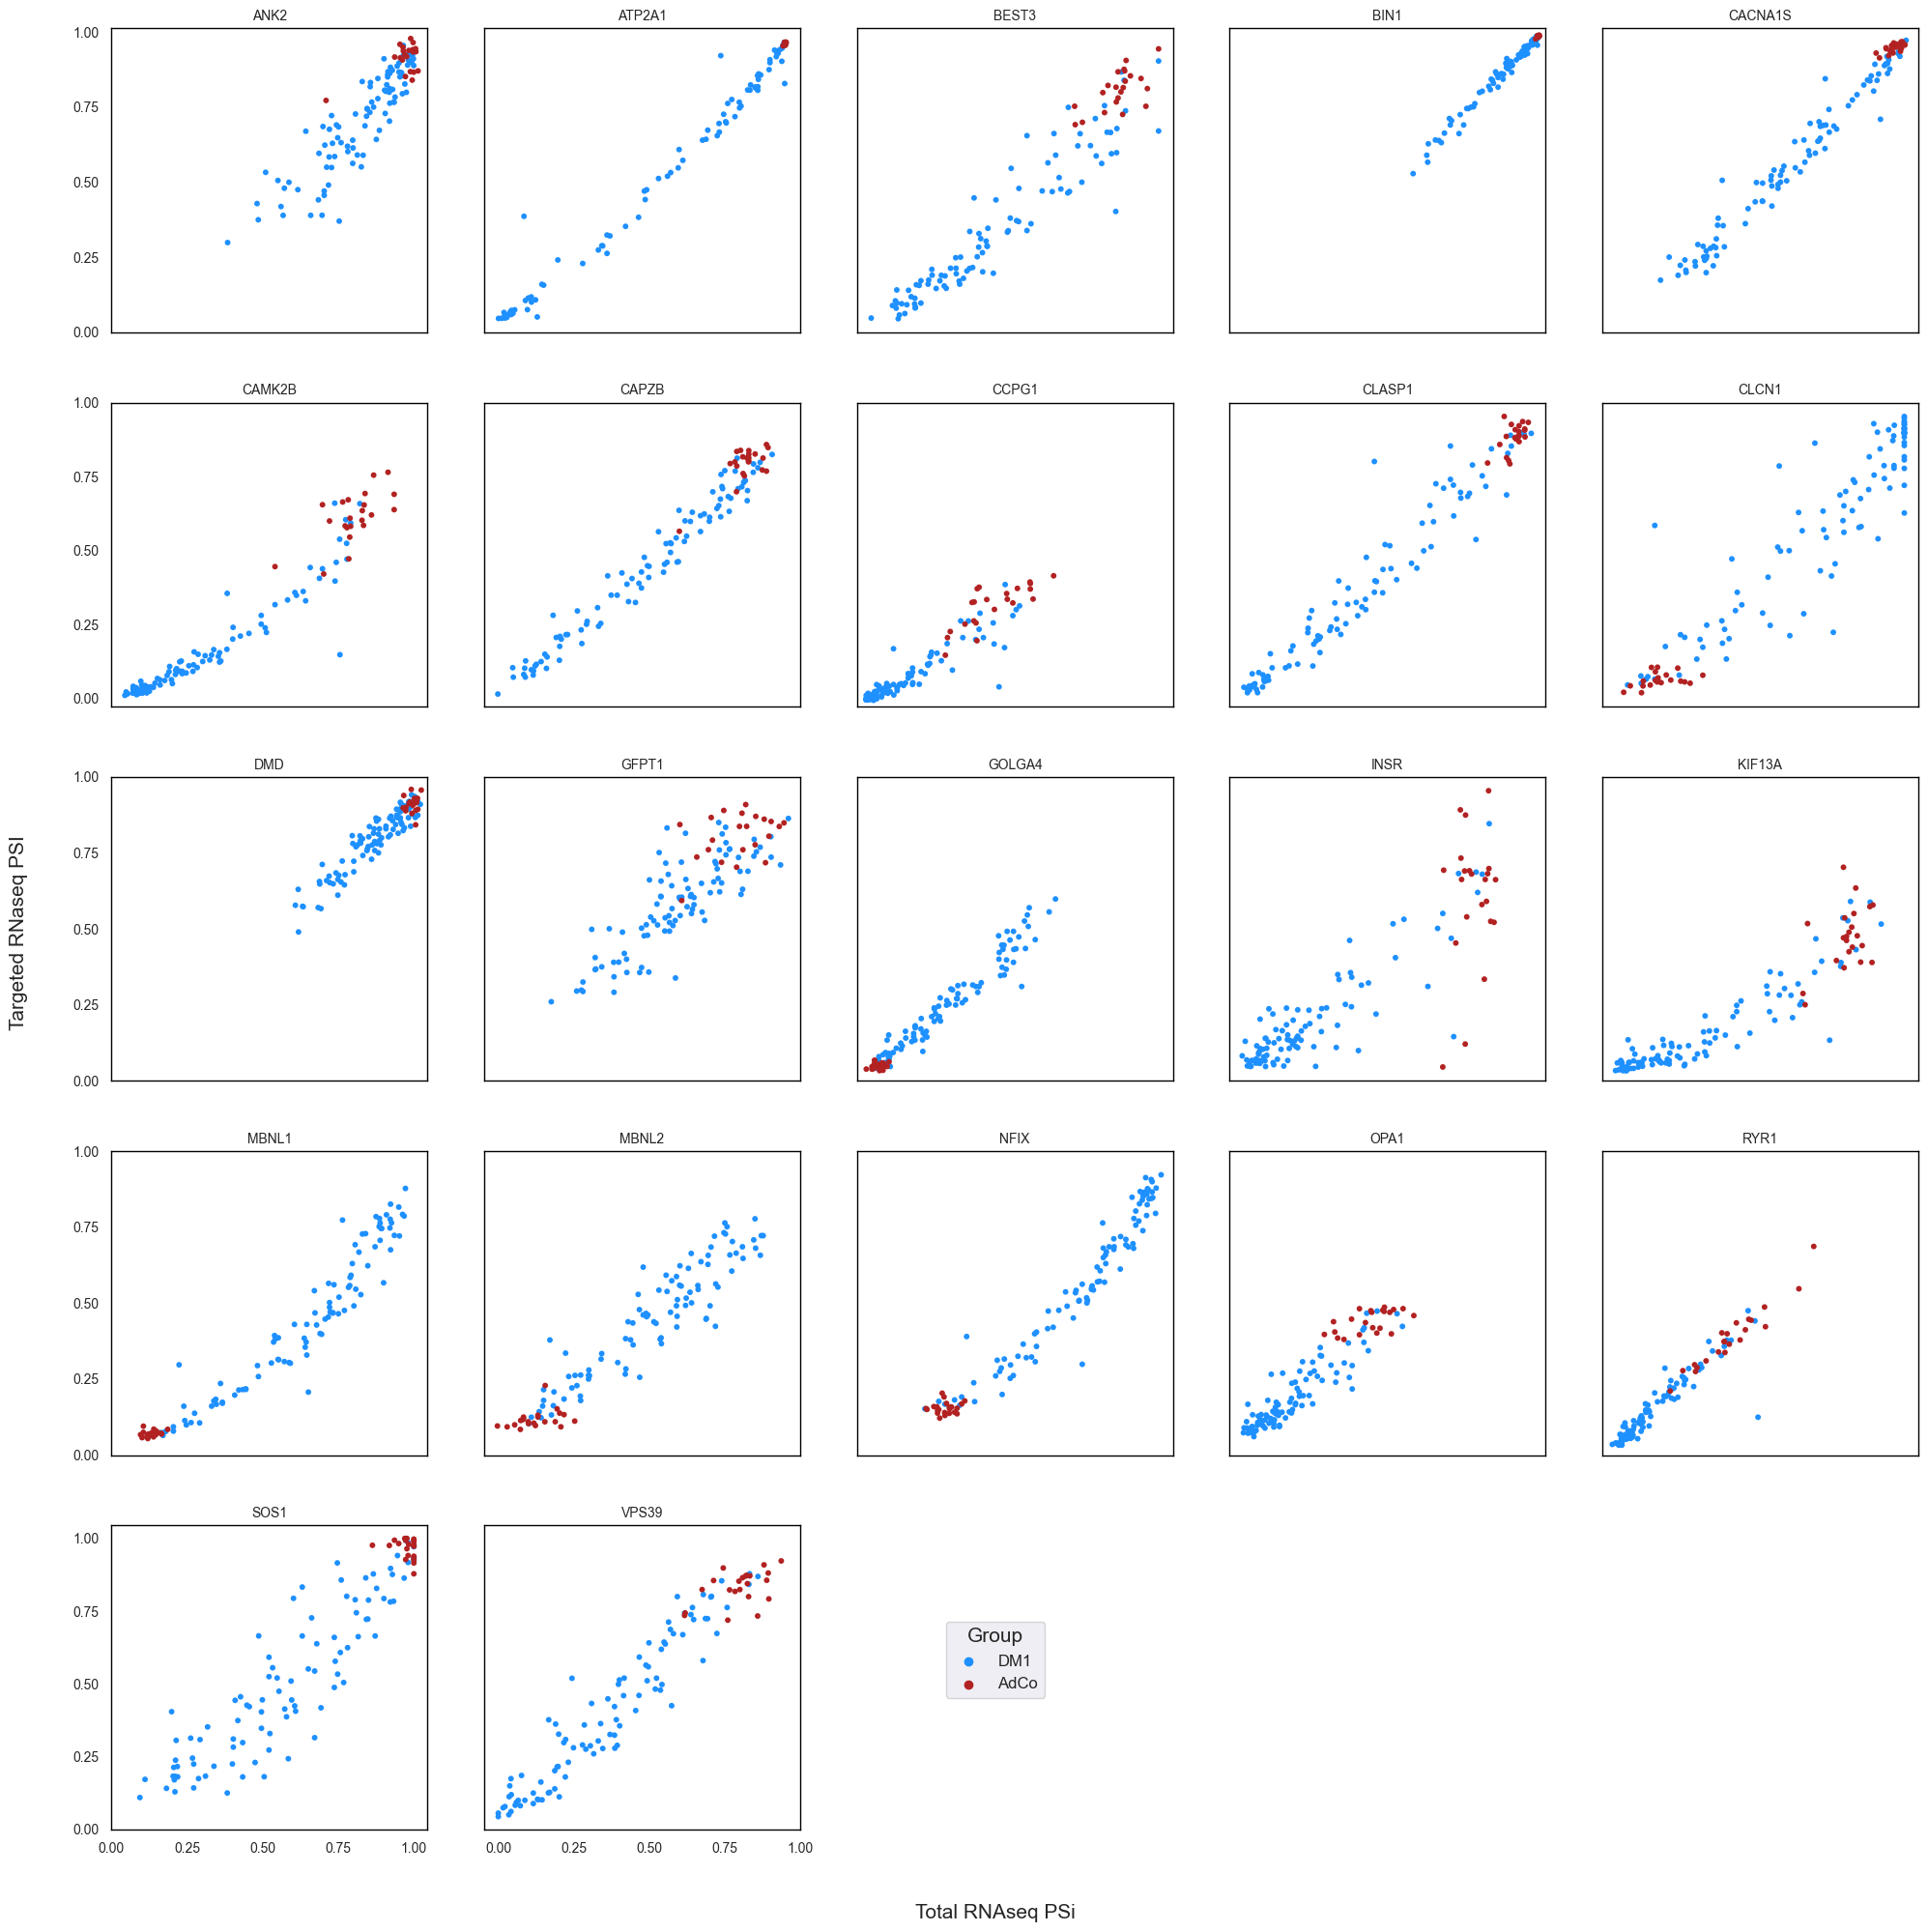

In [103]:
# Extract the column names for rater 1 and rater 2
rater1_cols = [col for col in sup_2g.columns if col.endswith('_x')]
rater2_cols = [col for col in sup_2g.columns if col.endswith('_y')]

# Sort the columns to ensure they are in the correct order
rater1_cols.sort()
rater2_cols.sort()

# Initialize the figure and axes
num_plots = len(rater1_cols)
num_rows = (num_plots + 4) // 5  # Calculate the number of rows needed for the grid
fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
axes = axes.flatten()

# Define the ticks for both axes
y_ticks = [0, 0.25, 0.5, 0.75, 1]
x_ticks = [0, 0.25, 0.5, 0.75, 1]

# Loop over each pair of measurement columns and create scatter plots
for idx, (rater1_col, rater2_col) in enumerate(zip(rater1_cols, rater2_cols)):
    scatter = sns.scatterplot(x=sup_2g[rater1_col], y=sup_2g[rater2_col], ax=axes[idx],hue=sup_2g["Group"], palette=diag_pal, s=18, linewidth=1, edgecolor='none')
    axes[idx].get_legend().remove()
    axes[idx].set_title(f"{rater1_col.split('_')[0]}", fontsize=10)
    axes[idx].set_facecolor('white')
    #box each plot in with black border
    for spine in axes[idx].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    # Set the same ticks for both x and y axes
    axes[idx].set_yticks(y_ticks)
    axes[idx].set_xticks(x_ticks)
    axes[idx].set_ylabel("")
    axes[idx].set_xlabel("")
    # Show x and y axis labels and ticks only on the left side and bottom of the grid, small font
    if idx % 5 != 0:
        axes[idx].set_yticklabels([])

    if idx < num_rows * 5 - 5:
        axes[idx].set_xticklabels([])
        #set font size of ticks
    axes[idx].tick_params(axis='both', which='major', labelsize=10)
    #grid lines
    axes[idx].grid(True)


# Remove empty subplots
for j in range(len(rater1_cols), len(axes)):
    fig.delaxes(axes[j])

# Add a common y-axis label on the left side and x-axis label on the bottom
fig.text(-0.01, 0.5, 'Targeted RNaseq PSI', va='center', rotation='vertical', fontsize=15)
fig.text(0.5, -0.01, 'Total RNAseq PSi', ha='center', fontsize=15)

# Adjust layout to make room for the labels and title
handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, fontsize=12, frameon=True, title='Group', title_fontsize='15', bbox_to_anchor=(0.5, 0.1))

# Adjust layout and reduce white space, increase space at the bottom
plt.subplots_adjust(wspace=0.1, hspace=0.5, bottom=0.25)
plt.tight_layout()
# plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/tot_v_tar_psi.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()



In [104]:
counts = pd.read_csv("/Users/ikegamik/Documents/kikegami/splice_index/merged_counts.txt", sep='\t')

#remove _counts from col names
counts.columns = counts.columns.str.replace('_counts', '')
#remove first row of counts
counts = counts.drop(0)
counts.set_index('Geneid', inplace=True)
#drop last col
counts = counts.drop(columns='merged')
#calculate row means save to df called mean counts, indexed by Geneid
#remove cols not in meta['si_id']
counts = counts[counts.columns.intersection(meta_amp['SI ID'])]
counts = counts.transpose()
counts.index = meta_amp.index
counts = counts.transpose()

mean_counts = counts.mean(axis=1)
#make mean_counts a dataframe, name 2nd col mean_counts#
mean_counts = pd.DataFrame(mean_counts)
mean_counts = mean_counts.rename(columns = {0:'mean_counts'})

#remove everything after the first '_' in the index incuding the '_', columns with the same index should be summed
mean_counts.index = mean_counts.index.str.split('_').str[0]
mean_counts = mean_counts.groupby(mean_counts.index).sum()
# mean_counts.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/mean_tar-rnaseq_event_counts.csv")
# counts.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/tar-rnaseq_event_counts.csv")
mean_counts

mean_counts
Geneid                
ANK2       4774.596899
ATP2A1   198349.689922
BEST3     11110.294574
BIN1     108243.744186
CACNA1S   38467.364341
CAMK2B    14035.906977
CAPZB     16795.937984
CCPG1     22267.984496
CLASP1     3551.286822
CLCN1      3308.038760
DMD        3317.798450
GFPT1      8602.813953
GOLGA4    21707.581395
INSR       2055.798450
KIF13A     1255.441860
MBNL1     42063.286822
MBNL2     38302.689922
NFIX       7887.612403
OPA1       6341.813953
RYR1      17666.085271
SOS1        659.891473
VPS39     12727.457364

In [105]:
psi_difs = {}
for col in sup_2g.columns:
    # Check if the column ends with '_x'
    if col.endswith('_y'):
        # Construct the corresponding '_y' column name
        col_x = col[:-2] + '_x'
        # Calculate the difference and store in results dictionary
        prefix = col[:-2]  # Extract the prefix before '_x'
        psi_difs[prefix] = sup_2g[col].sub(sup_2g[col_x])  # Absolute difference
# Create a new DataFrame from the results dictionary
psi_difs = pd.DataFrame(psi_difs)

# transpose the df and take row means for each event, saving to new df
psi_difs = psi_difs.transpose()
dif_psi = psi_difs.mean(axis=1)
dif_psi = pd.DataFrame(dif_psi)
dif_psi = dif_psi.rename(columns = {0:'mean_psi_dif'})
# dif_psi


In [106]:
#read in exon lengths df
lengths = pd.read_excel("/Users/ikegamik/Documents/kikegami/splice_index/event_nt_lengths.xlsx")
lengths = lengths.set_index('event')

#merge mean_counts and dif_psi
sup_2h = mean_counts.merge(dif_psi, left_index=True, right_index=True, how='left')
#merge mean_counts with lengths
sup_2h = sup_2h.merge(lengths, left_index=True, right_index=True, how='left')
sup_2h

mean_counts  mean_psi_dif  exon_size
Geneid                                         
ANK2       4774.596899     -0.094309         93
ATP2A1   198349.689922     -0.031049         42
BEST3     11110.294574     -0.096678         95
BIN1     108243.744186     -0.015031         45
CACNA1S   38467.364341     -0.041115         57
CAMK2B    14035.906977     -0.118356         75
CAPZB     16795.937984     -0.060611        113
CCPG1     22267.984496     -0.058614         96
CLASP1     3551.286822     -0.020819         48
CLCN1      3308.038760     -0.121404         79
DMD        3317.798450     -0.049113         32
GFPT1      8602.813953     -0.029344         54
GOLGA4    21707.581395     -0.032360         63
INSR       2055.798450     -0.076664         36
KIF13A     1255.441860     -0.191107        120
MBNL1     42063.286822     -0.143990         54
MBNL2     38302.689922     -0.072654         95
NFIX       7887.612403     -0.151718        123
OPA1       6341.813953     -0.006260         54
RYR1      17666.085271     -0.000901         15
SOS1        659.891473     -0.060902         45
VPS39     12727.457364      0.005463         33

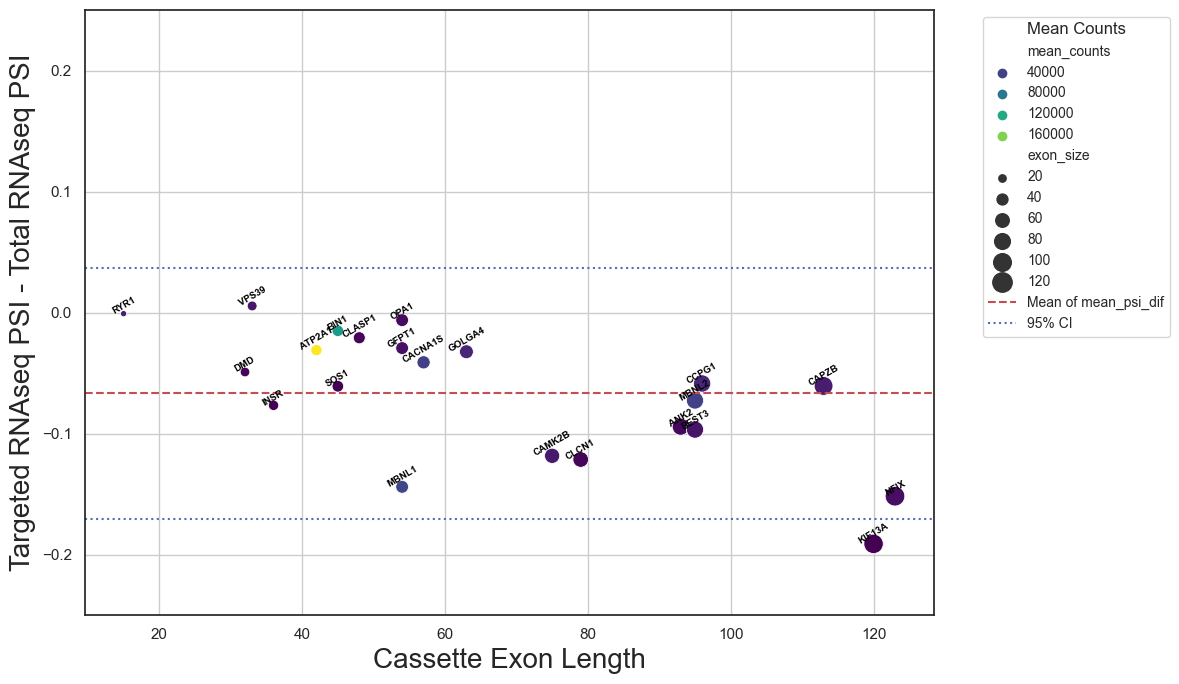

In [107]:
# Calculate mean of mean_psi_dif
mean_psi_dif_mean = sup_2h['mean_psi_dif'].mean()

# Calculate 95% confidence intervals for mean_psi_dif
ci = sp.norm.interval(0.95, loc=sup_2h['mean_psi_dif'].mean(), scale=sup_2h['mean_psi_dif'].std())

sns.set(style='white')  # Optional: Set the style
plt.figure(figsize=(12, 7))
scatterplot = sns.scatterplot(data=sup_2h, x='exon_size', y='mean_psi_dif', hue='mean_counts', palette='viridis', size='exon_size', sizes=(20, 200))
# Add mean_psi_dif mean line
plt.axhline(y=mean_psi_dif_mean, color='r', linestyle='--', label='Mean of mean_psi_dif')
# Add 95% confidence interval lines
plt.axhline(y=ci[0], color='b', linestyle=':', label='95% CI')
plt.axhline(y=ci[1], color='b', linestyle=':')
#label dots with event names

for i in range(sup_2h.shape[0]):
    scatterplot.text(sup_2h["exon_size"][i], sup_2h["mean_psi_dif"][i], sup_2h.index[i] , size='xx-small', color='black', weight='semibold' , rotation=30, ha='center')

plt.xlabel('Cassette Exon Length', fontsize=20)
plt.ylabel('Targeted RNAseq PSI - Total RNAseq PSI', fontsize=20)
#set y axis limits
plt.ylim(-.25, .25)
#move legend to right of graph
plt.legend(title='Mean Counts', bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1, fontsize=10, facecolor = 'white')
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/dif_psi_v_size.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()


In [108]:
ct_norms = pd.read_excel("/Users/ikegamik/Documents/kikegami/splice_index/norms/normalized_values.xlsx")
ct_norms.set_index('event', inplace=True)

#add column called rater to ct_norms where each value is 'ct'
ct_norms['rater'] = 'ct'
#add rater column to norms where each value is 'nej'
nej_norms = norms.copy()
nej_norms['rater'] = 'nej'
#rowbind ct_norms and norms
norms_icc_df = pd.concat([ct_norms, nej_norms])
#make index its own column
norms_icc_df = norms_icc_df.reset_index()

#ICC for 95th_dm1_psi values between normative value sets
icc_result = pg.intraclass_corr(data=norms_icc_df, targets='event', raters='rater', ratings='95th_dm1_psi', nan_policy='omit')

#ICC for med_cntl_psi values between normative value sets
icc_result2 = pg.intraclass_corr(data=norms_icc_df, targets='event', raters='rater', ratings='med_cntl_psi', nan_policy='omit')

icc_result
# icc_result2

Type              Description       ICC           F  df1  df2  \
0   ICC1   Single raters absolute  0.995977  496.098949   21   22   
1   ICC2     Single random raters  0.995977  548.966576   21   21   
2   ICC3      Single fixed raters  0.996363  548.966576   21   21   
3  ICC1k  Average raters absolute  0.997984  496.098949   21   22   
4  ICC2k    Average random raters  0.997985  548.966576   21   21   
5  ICC3k     Average fixed raters  0.998178  548.966576   21   21   

           pval        CI95%  
0  8.751622e-25  [0.99, 1.0]  
1  2.991411e-24  [0.99, 1.0]  
2  2.991411e-24  [0.99, 1.0]  
3  8.751622e-25   [1.0, 1.0]  
4  2.991411e-24  [0.99, 1.0]  
5  2.991411e-24   [1.0, 1.0]

In [109]:
#Getting mean counts for each event across all samples
matches = pd.DataFrame(matches)
event_counts = matches[['IJC_SAMPLE_1', 'SJC_SAMPLE_1','IJC_SAMPLE_2', 'SJC_SAMPLE_2']]

#split IJC_SAMPLE_1, SJC_SAMPLE_1, IJC_SAMPLE_2, SJC_SAMPLE_2 into separate columns
ijc_s1 = event_counts.IJC_SAMPLE_1.str.split(",", expand = True)
ijc_s1  =ijc_s1.rename(index =matches['geneSymbol'])
ijc_s1 = pd.DataFrame(ijc_s1)
ijc_s1 = ijc_s1.apply(pd.to_numeric, errors='coerce')
sjc_s1 = event_counts.SJC_SAMPLE_1.str.split(',', expand =True)
sjc_s1 =sjc_s1.rename(index =matches['geneSymbol'])
sjc_s1 = pd.DataFrame(sjc_s1)
sjc_s1 = sjc_s1.apply(pd.to_numeric, errors='coerce')
ijc_s2 = event_counts.IJC_SAMPLE_2.str.split(",", expand = True)
ijc_s2 =ijc_s2.rename(index =matches['geneSymbol'])
ijc_s2 = ijc_s2.apply(pd.to_numeric, errors='coerce')
sjc_s2 = event_counts.SJC_SAMPLE_2.str.split(',', expand =True)
sjc_s2 =sjc_s2.rename(index =matches['geneSymbol'])
sjc_s2 = pd.DataFrame(sjc_s2)
sjc_s2 = sjc_s2.apply(pd.to_numeric, errors='coerce')

ijc_s1.columns = case_frame.index
sjc_s1.columns = case_frame.index
ijc_s2.columns = cntrl_frame.index
sjc_s2.columns = cntrl_frame.index

# matrix addition to get total counts for each event
s1 = ijc_s1 + sjc_s1
s2 = ijc_s2 + sjc_s2

sample_counts = pd.concat([s1, s2], axis = 1)
sample_counts = pd.DataFrame(sample_counts)

total_mean_event_counts = sample_counts.mean(axis = 1)
total_mean_event_counts = pd.DataFrame(total_mean_event_counts)

total_mean_event_counts = total_mean_event_counts.rename(columns={0: 'mean count'})
#avg_event_counts.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/total_event_mean_counts.csv")
# total_mean_event_counts


In [110]:
#merge mean counts from sup_2h and total_mean_event_counts, rename each column
count_comp = total_mean_event_counts.merge(sup_2h['mean_counts'], left_index=True, right_index=True, how='left')
count_comp = count_comp.rename(columns = {'mean count':'total_mean_count', 'mean_counts':'targeted_mean_count'})

#create new col called fold change, which is the ratio of total_mean_count to targeted_mean_count
count_comp['fold_change'] = count_comp['targeted_mean_count']/count_comp['total_mean_count']
# count_comp.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/total_targeted_mean_counts.csv")
print(count_comp['fold_change'].mean())

72.18675441948356


In [111]:
#Sup Table 3
#concat ijc_s1 with ijc_s2, append "inc" to each rowname
ijc = pd.concat([ijc_s1, ijc_s2],axis=1)
ijc = ijc.rename(index = lambda x: x + "_inc")
sjc = pd.concat([sjc_s1, sjc_s2],axis=1)
sjc = sjc.rename(index = lambda x: x + "_exc")
all_jc = pd.concat([ijc, sjc])
all_jc.sort_index(inplace=True)
# all_jc.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_table3_total.csv")

#calc median for each row and 95% CI for full_match psi values, save to a new df and then export to csv
sup_full_match = full_match.transpose()
meta_sup_3b = meta.copy()
meta_sup_3b = meta_sup_3b.set_index('SI ID')
#merge meta group with sup_full_match
sup_full_match = sup_full_match.merge(meta_sup_3b['Group'], left_index=True, right_index=True, how='left')

sup_tab_3a = sup_full_match.groupby('Group').mean()
sup_tab_3a = pd.DataFrame(sup_tab_3a)
sup_tab_3a = sup_tab_3a.transpose()

#calculate median psi per event for each group and its corresponding 95% CI
sup_tab_3b = sup_full_match.groupby('Group').median()
sup_tab_3b = pd.DataFrame(sup_tab_3b)
sup_tab_3b = sup_tab_3b.transpose()
sup_full_match.transpose()

#calculate standard error of the mean for each group
sup_tab_3c = sup_full_match.groupby('Group').apply(sp.stats.sem)
sup_tab_3c = pd.DataFrame(sup_tab_3c)
#split lists in each cell into separate columns, rename them with index from sup_tab_2b
sup_tab_3c = sup_tab_3c[0].apply(pd.Series)
sup_tab_3c = sup_tab_3c.transpose()
sup_tab_3c.set_index(sup_tab_3b.index, inplace=True)
sup_tab_3c
#calculate confidence intervals
sup_tab_3d = sup_tab_3c.apply(lambda x: sp.norm.interval(0.95, loc=x.mean(), scale=x.std()), axis=1)

# sup_tab_3a.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_table_3a.csv")
# sup_tab_3b.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_table_3b.csv")
# sup_tab_3c.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/sup_table_3c.csv")
# sup_tab_3b
sup_tab_3c


/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/4162141456.py:29: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  sup_tab_3c = sup_full_match.groupby('Group').apply(sp.stats.sem)
/Users/ikegamik/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ikegamik/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Group        AdCo       DM1  DMD      LGMD
ANK2     0.012970  0.014074  NaN  0.044871
ATP2A1   0.000516  0.038094  NaN  0.022607
BEST3    0.015959  0.026752  NaN  0.025171
BIN1     0.000560  0.010607  NaN  0.005271
CACNA1S  0.005406  0.023642  NaN  0.017511
CAMK2B   0.018366  0.023403  NaN  0.047689
CAPZB    0.012436  0.025143  NaN  0.053760
CCPG1    0.021428  0.014283  NaN  0.034459
CLASP1   0.006869  0.029172  NaN  0.037045
CLCN1    0.013429  0.029266  NaN  0.022826
DMD      0.003342  0.010656  NaN  0.007931
GFPT1    0.020481  0.016882  NaN  0.042266
GOLGA4   0.003681  0.016268  NaN  0.004094
INSR     0.011118  0.021484  NaN  0.035578
KIF13A   0.013497  0.024893  NaN  0.053109
MBNL1    0.004798  0.022964  NaN  0.014065
MBNL2    0.013497  0.021327  NaN  0.021565
NFIX     0.007067  0.020587  NaN  0.028924
OPA1     0.016190  0.012177  NaN  0.029910
RYR1     0.024043  0.011269  NaN  0.029796
SOS1     0.007315  0.026032  NaN  0.009191
VPS39    0.018231  0.023884  NaN  0.066565

In [112]:
sup_amp = amp.transpose()
sup_amp = sup_amp.merge(meta_amp['Group'], left_index=True, right_index=True, how='left')

amp_sup_tab_3a = sup_amp.groupby('Group').mean()
amp_sup_tab_3a = pd.DataFrame(amp_sup_tab_3a)
amp_sup_tab_3a = amp_sup_tab_3a.transpose()
# amp_sup_tab_3a.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/amp_sup_tab3a.csv")

amp_sup_tab_3b = sup_amp.groupby('Group').median()
amp_sup_tab_3b = pd.DataFrame(amp_sup_tab_3b)
amp_sup_tab_3b = amp_sup_tab_3b.transpose()
# amp_sup_tab_3b.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/amp_sup_tab3b.csv")

#calculate median for each row and 5% and 95% CI for full_match psi values, save to a new df and then export to csv
amp_sup_tab_3c = sup_amp.groupby('Group').apply(sp.stats.sem)

amp_sup_tab_3c = pd.DataFrame(amp_sup_tab_3c)
#split lists in each cell into separate columns, rename them with index from sup_tab_2b
amp_sup_tab_3c = amp_sup_tab_3c[0].apply(pd.Series)
amp_sup_tab_3c = amp_sup_tab_3c.transpose()
# amp_sup_tab_3c.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/amp_sup_tab3c.csv")
# amp_sup_tab_3c

/var/folders/w0/cs9kwln50dd1z7p4f_p4zbj40000gq/T/ipykernel_88533/3524763452.py:15: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  amp_sup_tab_3c = sup_amp.groupby('Group').apply(sp.stats.sem)


In [113]:
def parametric_confidence_interval(data, confidence=0.95):
    n = len(data)
    # mean = np.mean(data)
    median = np.median(data)
    sem = sp.sem(data)  # Standard error of the mean

    if n < 30:
        # Use t-distribution for small sample sizes
        critical_value = sp.t.ppf((1 + confidence) / 2, df=n-1)
    else:
        # Use z-distribution for large sample sizes
        critical_value = sp.norm.ppf((1 + confidence) / 2)
    
    margin_of_error = critical_value * sem
    lower_bound = median - margin_of_error
    upper_bound = median + margin_of_error
    
    return lower_bound, upper_bound

def bootstrap_confidence_interval(data, confidence=0.95, n_bootstrap=1000):
    bootstrapped_means = []
    n = len(data)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        resample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(resample))
    
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence) / 2 * 100)
    
    return lower_bound, upper_bound


grouped = sup_full_match.groupby('Group')
# grouped = sup_amp.groupby('Group')
grouped
# Initialize a dictionary to store the results
results = {}

# Loop through each group and calculate the confidence intervals
for name, group in grouped:
    results[name] = {}
    for column in sup_full_match.columns[:-1]:
        lower, upper = parametric_confidence_interval(group[column])
        # lower, upper = bootstrap_confidence_interval(group[column])
        results[name][column] = (lower, upper)
result_df = pd.DataFrame(results).T
result_df = result_df.transpose()
# result_df.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/tot_sup_table3_ci.csv")
# result_df.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/np_tar_sup_table3_ci.csv")

/Users/ikegamik/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ikegamik/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [114]:
ct_norms = pd.read_excel("/Users/ikegamik/Documents/kikegami/splice_index/norms/normalized_values.xlsx")
ct_norms = pd.DataFrame(ct_norms)
ct_norms.set_index('event', inplace=True)
ct_norms

95th_dm1_psi  med_cntl_psi
event                              
ANK2         0.464724      0.973561
ATP2A1       0.016316      0.998990
BEST3        0.053026      0.836138
BIN1         0.680671      0.993008
CACNA1S      0.249468      0.951350
CAMK2B       0.017905      0.628730
CAPZB        0.076527      0.808368
CCPG1        0.002409      0.309363
CLASP1       0.039065      0.915950
CLCN1        0.999524      0.097179
DMD          0.604267      0.939620
GFPT1        0.292734      0.837218
GOLGA4       0.545713      0.058641
INSR         0.008547      0.755257
KIF13A       0.003925      0.512609
MBNL1        0.806084      0.072078
MBNL2        0.755320      0.144276
NFIX         0.917331      0.177555
OPA1         0.058700      0.480161
RYR1         0.026761      0.403724
SOS1         0.140771      0.979769
VPS39        0.031546      0.846734

In [115]:
# Create an empty DataFrame to store the results
ct_si_scores = pd.DataFrame(index=amp.columns, columns=['ct_si_score'])
ct_ndsi = amp.copy()
# Iterate over each column in 'ct_ndsi'
for column in ct_ndsi.columns:
    x_result = 0
    for index, value in ct_ndsi[column].items():
        # normalize psi
        x = ((value - ct_norms.loc[index, 'med_cntl_psi'])/(ct_norms.loc[index, '95th_dm1_psi'] - ct_norms.loc[index, 'med_cntl_psi']))
        #save normalized psi to a new df
        ct_ndsi[column][index] = x
        #sum normalized psi
        x_result += x
        
    # Calculate the average for the column and store it in 'ct_si_scores'
    
    ct_si_scores.loc[column, 'ct_si_score'] = x_result / len(amp)
    #if si_score is greater than 1, set to 1, less than 0, set to 0
    if ct_si_scores.loc[column, 'ct_si_score'] > 1:
        ct_si_scores.loc[column, 'ct_si_score'] = 1
    elif ct_si_scores.loc[column, 'ct_si_score'] < 0:
        ct_si_scores.loc[column, 'ct_si_score'] = 0

# ct_si_scores.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/ct_si_scores_02jul2024.csv")
# ct_ndsi.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/ct_ndsi_02jul2024.csv")
ct_si_scores


ct_si_score
SI ID               
AdCo-001           0
AdCo-002           0
AdCo-004      0.0527
AdCo-005    0.067229
AdCo-006    0.061151
...              ...
DM1-115     0.678735
DM2-001     0.484236
DM2-002     0.507432
DM2-003     0.081389
DM2-004     0.528114

[129 rows x 1 columns]

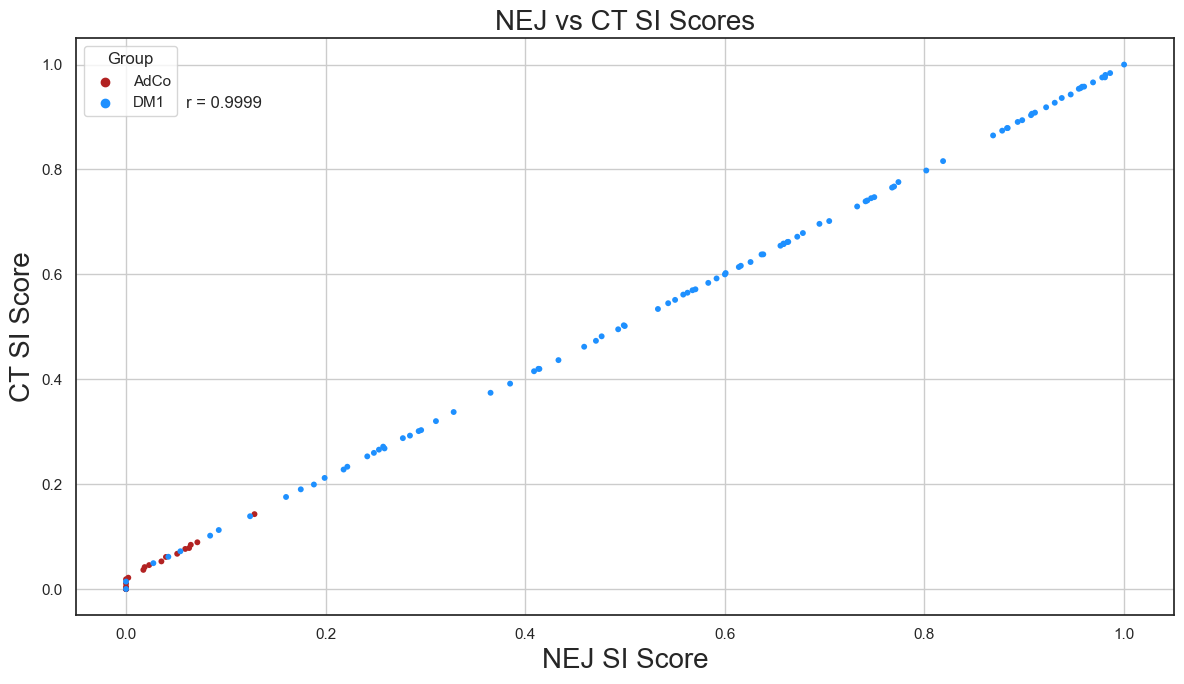

In [116]:
si_comp_df = pd.concat([si_scores, ct_si_scores], axis=1)
#merge group column from meta_amp
si_comp_df = si_comp_df.merge(meta_amp['Group'], left_index=True, right_index=True, how='left')
#filter for AdCo and DM1 groups
si_comp_df = si_comp_df[si_comp_df['Group'].isin(['AdCo', 'DM1'])]
#calculate pearson correlation coefficient
si_comp_df['si_score'] = si_comp_df['si_score'].astype(float)
si_comp_df['ct_si_score'] = si_comp_df['ct_si_score'].astype(float)
correlation_coefficient = si_comp_df['si_score'].corr(si_comp_df['ct_si_score'], method='pearson')
si_comp_df.to_csv("/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/si_comp_df.csv")
#ploit scatter plot to shw aggreance of scores
plt.figure(figsize=(12, 7))
scatterplot = sns.scatterplot(x='si_score', y='ct_si_score', data=si_comp_df,hue='Group', palette=diag_pal, s=18, linewidth=1, edgecolor='none')
plt.xlabel('NEJ SI Score', fontsize=20)
plt.ylabel('CT SI Score', fontsize=20)
plt.title('NEJ vs CT SI Scores', fontsize=20)
plt.text(0.1, 0.9, f'r = {correlation_coefficient:.4f}', transform=scatterplot.transAxes, fontsize=12, verticalalignment='top')
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"/Users/ikegamik/Documents/kikegami/splice_index/si_figs_v7/supps/nej_v_ct_si_scores.svg", format="svg", bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()